### Resources used:
**EMNIST: an extension of MNIST to handwritten letters - https://arxiv.org/abs/1702.05373v1
**A good chunk of this course: https://www.learnpytorch.io/

## Part 0 - Setting up Necessary Libraries

In [ ]:
# Importing necessary libraries for handling data
import pandas as pd
import numpy as np

# TQDM for monitoring progress of training
from tqdm import tqdm

# PyTorch dependencies that we'll be using
import torch

# PyToch Utils
from torch.utils.data import DataLoader, Subset, TensorDataset

# PyTorch Neural Network Modules
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import no_grad

# sklearn for stratified k fold
from sklearn.model_selection import StratifiedKFold

# sklearn for eval metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

# Libraries for graphing
import matplotlib.pyplot as plt
import seaborn as sns

# Checking if CUDA (GPU support) is available, else use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Setting the style for matplotlib and seaborn for better visuals
plt.style.use('ggplot')
sns.set(style='whitegrid')


Using device: cuda


In [ ]:
# I've tried to download in the standard way, but had no luck:
## Libraries for dataset / tranformation
# import torchvision.transforms as transforms
# from torchvision.datasets import EMNIST

# train_dataset = EMNIST(root='data/', split='balanced', train=True, download=True)
# test_dataset = EMNIST(root='data/', split='balanced', train=False, download=True)

#Instead, we'll use the kaggle dataset and proces the dataset as a csv.

#https://www.kaggle.com/datasets/crawford/emnist/data [accessed 29/03/2024]

#This requires that we download / upload the dataset manually each time we launch our collab notebook.

## Part 1 - Loading our dataset

When loading our dataset, we found that the images were being read incorrectly from the cv, resulting in the vertical and horizontal pixels being flipped. To resolve this, we flipped the characters vertically and rotated them by 90 degrees counter clockwise.

In [ ]:
# Function to load the dataset from a CSV file
def load_dataset(csv_file):
    # Load data into pandas DataFrame
    data = pd.read_csv(csv_file, header=None)

    # Split the DataFrame into features and labels
    labels = data.iloc[:, 0]
    features = data.iloc[:, 1:]

    # Normalize pixel values and reshape features to (num_samples, channels, height, width)
    features = features / 255.0  # Normalize pixel values to be between [0, 1]

    # Reshape the numpy array into a 2 dimensional array with one colour channel
    features = features.values.reshape(-1, 1, 28, 28)

    # Create an empty array to store the transformed images
    transformed_features = np.empty_like(features)

    # Apply transformations per image
    for i in range(len(features)):
        # Flip the orientation of the image vertically
        flipped_image = np.flipud(features[i, 0])
        # Rotate the orientation of the flipped image by 90 degrees counter-clockwise
        rotated_image = np.rot90(flipped_image, k=-1, axes=(0, 1))
        # Assign the transformed image to the new array
        transformed_features[i, 0] = rotated_image


   # Check for NaNs in the transformed features
    if np.isnan(transformed_features).any():
        print(f"Warning: NaNs detected in transformed features and will be replaced with 0.")
        transformed_features = np.nan_to_num(transformed_features)

    # Convert features and labels to PyTorch tensors
    transformed_features = torch.tensor(transformed_features, dtype=torch.float)
    labels = torch.tensor(labels.values, dtype=torch.long)

    # Create a TensorDataset from the tensors
    dataset = TensorDataset(transformed_features, labels)

    return dataset

## Part 2 - split data into a training and test dataset

In [ ]:
# Load training and test datasets
train_dataset = load_dataset('emnist-balanced-train.csv')
test_dataset = load_dataset('emnist-balanced-test.csv')

## Part 3 - Loading our dataset using DataLoaders

In [ ]:
# We can then create our data loaders to handle batching (for when we train our model later)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

## Part 4 - Understanding our data

### Data Structure

Number of training samples: 112800
Number of testing samples: 18800
Image size: [1, 28, 28]
Sample label: 45


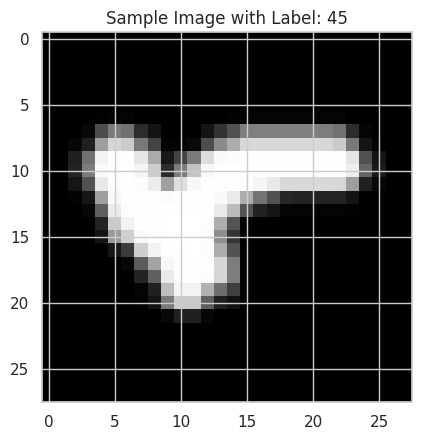

In [ ]:
# Let's start by exploring the dataset's structure
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

# We can also get a sample from the dataset to understand data format
image, label = train_dataset[0]

print(f"Image size: {list(image.size())}")
print(f"Sample label: {label}")

# Visualizing a sample image
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Sample Image with Label: {label}")
plt.show()

**These results tell us that we're working with 112,800 samples in our training dataset and 18800 samples in our test dataset.

**The size of the image [1, 28, 28] tells us that we're dealing with 28 x 28 images in black and white, since there is only one pixel value at each of the 28 x 28 pixel positions. If the images were in an rgb format, the tensor would have a depth of 3 (or higher if working with alternative representations of images).

### Understanding our Mappings

Here we define a function that loads the mappings of the labels to ASCII characters, which we have then converted to a dictionary for easy labeling reference.

In [ ]:
def load_label_mapping(mapping_file):
    # Create a dictionary to hold the mapping from label to character
    label_char_mapping = {}

    # Open the mapping file
    with open(mapping_file, 'r') as file:
        for line in file:
            # Split the line into the label and its ASCII value
            label, ascii_val = line.strip().split()
            # Convert the label and ASCII value to integers
            label, ascii_val = int(label), int(ascii_val)
            # Map the label to the corresponding character
            label_char_mapping[label] = chr(ascii_val)

    return label_char_mapping

# Load the mapping
mapping_file_path = 'emnist-balanced-mapping.txt'
label_char_mapping = load_label_mapping(mapping_file_path)

# Example usage:
print(label_char_mapping)  # Prints the entire mapping

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J', 20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T', 30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z', 36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'}


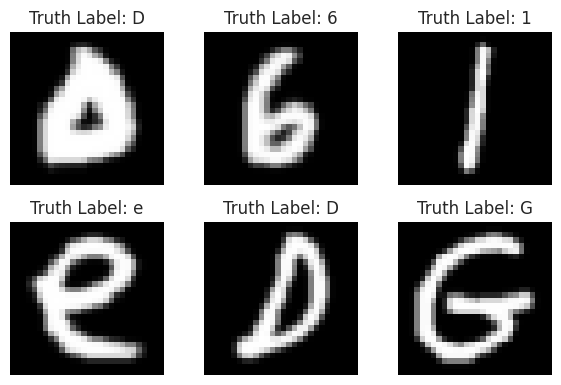

In [ ]:
# We can then get a range of samples from the dataset to visualise the format that samples take.
# First set the random seed for reproducibility
torch.manual_seed(0)

# Then we choose 6 random indices from the training dataset
indices = torch.randint(len(train_dataset), size=(6,))

# We then create a 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(6, 4))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes):
    # Get a sample from the dataset
    image, label = train_dataset[indices[i]]

    # Plot the image on the corresponding subplot
    ax.imshow(image.squeeze(), cmap='gray')

    # Set the title for the subplot
    ax.set_title(f"Truth Label: {label_char_mapping[int(label)]}")

    # Turn off axis to remove ticks and numbers
    ax.axis('off')

# Adjust the layout so titles and images don't overlap
plt.tight_layout()
plt.show()

## K-fold Cross Validation

In order to experimentally explore the hyperparameter space for the neural networks that we will train as part of this assignment, we will implement k-fold cross validation. Because this is a classification task, we'll need to use stratified k-fold validation. This approach evenly distributes the samples of each class amongst each k-fold, thus enabling balanced cross validation.


In [ ]:
# Convert PyTorch tensors to numpy arrays
features = train_dataset.tensors[0].numpy()
labels = train_dataset.tensors[1].numpy()

# Define the stratified k-fold parameters
n_splits = 5  # Number of folds
shuffle = True
random_state = 42

# Use scikit-learn's StratifiedKFold to define the stratified k-fold splitting strategy.
skf = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

# Split the dataset into folds. Each fold will be used once as a validation while the k - 1 remaining folds form the training set.
folds = skf.split(features, labels)

## Defining our training loop

**Throughout this project, we will use Cross Entropy Loss for our loss function, since this is a classification task and we essentially want to produce logits (raw output from the model) which we can map to a probability distribution of all possible classes (achieved using the softmax function).

**To make our code modular and reusable across all of our experiments with hyperparameters, we can define a custom function which trains and validates the model using the given data loaders, optimizer, and number of epochs.

In [ ]:
def train_and_validate_model(train_loader, val_loader, model, optimizer, epochs, device=device):
    """
    Trains and validates the model for a given train/val set, implements early stopping (default trigger - no improvement after 5 epochs).

    Parameters:
    - train_loader: DataLoader for the training data.
    - val_loader: DataLoader for the validation data.
    - model: The neural network model to train.
    - optimizer: The optimizer to use for training.
    - epochs: Number of epochs to train for.
    - device: The device (CPU or GPU) to use for training and evaluation.

    Returns:
    - A tuple containing the average training loss, average validation loss, and average validation accuracy.
    """

    model.to(device)
    # Track metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Early stopping setup
    estop_tolerance = 5
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()  # Set model to training mode
        train_loss = 0

        # Training loop
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Calculate average losses
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += F.cross_entropy(y_pred, y).item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= estop_tolerance:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

        # print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

    return train_losses, val_losses, val_accuracies


**We can also define a function to time our models

**Code taken from Daniel Bourke - learnpytorch

https://www.learnpytorch.io/03_pytorch_computer_vision/#32-creating-a-function-to-time-our-experiments

In [ ]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


We can then create a stratified_k_fold_cross_validation functon which takes a given training dataset, number of splits, model constructor, optimizer constructor and number of epochs as arguments.


In [ ]:

def stratified_k_fold_cross_validation(dataset, n_splits, model_constructor, optimizer_constructor, epochs=20, device=device):
    """
    Performs stratified k-fold cross-validation for the given dataset and model.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - optimizer_constructor: Function that takes a model's parameters and returns an optimizer.
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    """
    features = dataset.tensors[0].numpy()
    labels = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        # Start timing here
        fold_start_time = timer()

        # Splitting the dataset into training and validation for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Creating data loaders for the current fold
        train_loader = DataLoader(train_subset, batch_size=512, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=512, shuffle=False)

        # Initializing the model, optimizer and early stopping tollerance, for the current fold
        model = model_constructor().to(device)
        optimizer = optimizer_constructor(model.parameters())

        # Training and validation for the current fold
        train_losses, val_losses, val_accuracies = train_and_validate_model(
            train_loader, val_loader, model, optimizer, epochs, device
        )

         # End timing here
        fold_end_time = timer()

        fold_train_time = fold_end_time - fold_start_time

        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'train_time': fold_train_time
        })

        print_train_time(fold_start_time, fold_end_time, device)
        print(f"Using device: {device}")
        print(f"Fold {fold} completed. Validation accuracy: {val_accuracies[-1]:.2f}%\n")

    return fold_results



**To use our cross validation training loop, we need to define model_constructor and optimizer_constructor functions so that we ensure that a new model and optimizer are created for each fold, preventing information leakage between folds by making sure that each fold starts with an untrained model.


In [ ]:
# def model_constructor():
#     return model()  # Replace 'model' with the current model class

# def optimizer_constructor(model_params):
#     return torch.optim.SGD(model_params, lr=0.01) # Replace with the current optimiser


## Part 5 - MLPs & CNNs

## Multi Layered Perceptrons

### MLP - Depth / Number of Layers

**Let's begin by define 3 baseline MLP's to assess performance with differing amounts of layers hidden layers:

In all cases, our models start with an input layer of the same size as the flattened image. We then pass the pixel values in all 728 pixels (28 x 28) through hidden layers, using ReLU to introduce non-linearity. This enables the model to learn non-linear patterns in the data. We also use dropout techniques, which randomly turn off some of the neurons during training. This trick helps the model avoid getting too fixated on specific details and makes it better at dealing with new, unseen data. At the end, all this information goes through an output layer that sorts everything into one of 47 different categories.


#### 1 Layer MLP

In this single-layer MLP model, each 28x28 image is flattened to a 784-input vector that feeds into the first hidden layer. This layer compresses these inputs down to 512 features, using ReLU activation to introduce non-linearity and capture significant data patterns effectively. A dropout mechanism follows to mitigate overfitting by randomly omitting some neurons during training. The final step involves the output layer, which scales down the processed features to match the 47 distinct class outputs, representing various handwritten characters.

In [ ]:
# Define the MLP neural network class
class one_layerMLP(nn.Module):
    def __init__(self, num_classes=47, activation_fn=F.relu):
        super(one_layerMLP, self).__init__()
        self.activation_fn = activation_fn
        # Define the first hidden layer (input size 784)
        self.hidden1 = nn.Linear(784, 512)
        # Define the second hidden layer
        self.output = nn.Linear(512, num_classes)

    def forward(self, x):
        # Flatten the input data
        x = x.view(x.size(0), -1)
        # Pass the input data through the first hidden layer, then apply our activation function
        x = self.activation_fn(self.hidden1(x))
        # Pass the data to the output layer
        x = self.output(x)
        # Return the output logits
        return x

In [ ]:
# use model constructor function so that this specific model can be called by other function
def model_constructor():
    return one_layerMLP()

#define baseline optimizer
def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01)

# pass the model through stratified_k_fold_cross_validation function
one_layer_fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,  # Your dataset
    n_splits=5,  # Number of folds
    model_constructor=model_constructor,
    optimizer_constructor=optimizer_constructor,
    epochs=20,
    device=device

)

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:00<00:00,  3.04s/it]


Train time on cuda: 64.038 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 61.11%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:05<00:00,  3.27s/it]


Train time on cuda: 65.510 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 61.03%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:01<00:00,  3.05s/it]


Train time on cuda: 61.071 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 61.10%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:03<00:00,  3.18s/it]


Train time on cuda: 63.610 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 61.41%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:02<00:00,  3.11s/it]

Train time on cuda: 62.280 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 61.61%



#### 2 Layer MLP

In the two-layer MLP model, we begin by transforming each image from a 28x28 pixel format into a flattened vector of 784 inputs. The model then processes this data through a sequence of reductions: the first hidden layer reduces the input from 784 to 512 features, and the second layer further reduces it to 256 features. These layers utilize ReLU activation to maintain non-linearity, helping the model to capture essential patterns from the data. The final layer, equipped with dropout to prevent overfitting, outputs the data into one of 47 categories, corresponding to different characters. This setup ensures efficient processing and accurate classification by progressively refining and focusing the input data through each layer.

In [ ]:
# Define the MLP neural network class
class two_layerMLP(nn.Module):
    def __init__(self, num_classes=47, activation_fn=F.relu):
        super(two_layerMLP, self).__init__()
        self.activation_fn = activation_fn
        # Define the first hidden layer (input size 784)
        self.hidden1 = nn.Linear(784, 512)
        # Define the second hidden layer
        self.hidden2 = nn.Linear(512, 256)
        # Define the third hidden layer
        self.output = nn.Linear(256, num_classes)

    def forward(self, x):
        # Flatten the input data
        x = x.view(x.size(0), -1)
        # Pass the input data through the first hidden layer and apply an activation function
        x = self.activation_fn(self.hidden1(x))
        # Pass the data through the second hidden layer and apply an activation function
        x = self.activation_fn(self.hidden2(x))
        # Pass the data through the output layer
        x = self.output(x)
        return x

In [ ]:
# use model constructor function so that this specific model can be called by other function
def model_constructor():
    return two_layerMLP()

#define baseline optimizer
def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01)

# pass the model through stratified_k_fold_cross_validation function
two_layer_fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,  # Your dataset
    n_splits=5,  # Number of folds
    model_constructor=model_constructor,
    optimizer_constructor=optimizer_constructor,
    epochs=20,
    device=device
)

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:01<00:00,  3.05s/it]


Train time on cuda: 61.079 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 59.81%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:01<00:00,  3.07s/it]


Train time on cuda: 61.421 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 59.26%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:02<00:00,  3.13s/it]


Train time on cuda: 62.647 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 59.11%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:00<00:00,  3.05s/it]


Train time on cuda: 60.944 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 59.45%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:01<00:00,  3.07s/it]

Train time on cuda: 61.327 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 59.96%



#### 3 Layer MLP


In the 3 layer model, each EMNIST image is flattened from a 28x28 grid into 784 inputs. The first hidden layer reduces these to 512 features, simplifying data while preserving essential patterns. Subsequent layers further narrow down features—512 to 256, then to 128—enhancing the model's focus on crucial attributes. This gradual reduction ensures efficient processing and culminates in an output layer that classifies the data into one of 47 character classes, effectively balancing complexity and accuracy.

In [ ]:
class three_layerMLP(nn.Module):
    def __init__(self, num_classes=47, activation_fn=F.relu):
        super(three_layerMLP, self).__init__()
        # Save the activation function as an instance variable
        self.activation_fn = activation_fn

        # Define the first hidden layer (input size 784)
        self.hidden1 = nn.Linear(784, 512)
        # Define the second hidden layer
        self.hidden2 = nn.Linear(512, 256)
        # Define the third hidden layer
        self.hidden3 = nn.Linear(256, 128)
        # Output layer (output size 47)
        self.output = nn.Linear(128, num_classes)


    def forward(self, x):
        # Flatten the input data
        x = x.view(x.size(0), -1)
        # Pass the input data through the first hidden layer
        x = self.activation_fn(self.hidden1(x))
        # Pass the data through the second hidden layer
        x = self.activation_fn(self.hidden2(x))
        # Pass the data through the third hidden layer
        x = self.activation_fn(self.hidden3(x))
        # Pass the data through the output layer
        x = self.output(x)
        return x

training the 3 layer model

In [ ]:
# use model constructor function so that this specific model can be called by other function
def model_constructor():
    return three_layerMLP()

#define baseline optimizer
def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01)

# pass the model through stratified_k_fold_cross_validation function
three_layer_fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,  # Dataset
    n_splits=5,  # Number of folds
    model_constructor=model_constructor,
    optimizer_constructor=optimizer_constructor,
    epochs=20,
    device=device
)

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:09<00:00,  3.45s/it]


Train time on cuda: 69.038 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 50.20%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:02<00:00,  3.11s/it]


Train time on cuda: 62.312 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 47.56%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:12<00:00,  3.65s/it]


Train time on cuda: 72.938 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 46.77%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:02<00:00,  3.14s/it]


Train time on cuda: 62.908 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 47.31%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:03<00:00,  3.16s/it]

Train time on cuda: 63.206 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 49.42%



### Comparing MLPs of Different Depths

Having created and trained our MLPs of different depths, we can now iterate through the results of each and plot average train loss, average val loss and average val accuracy.

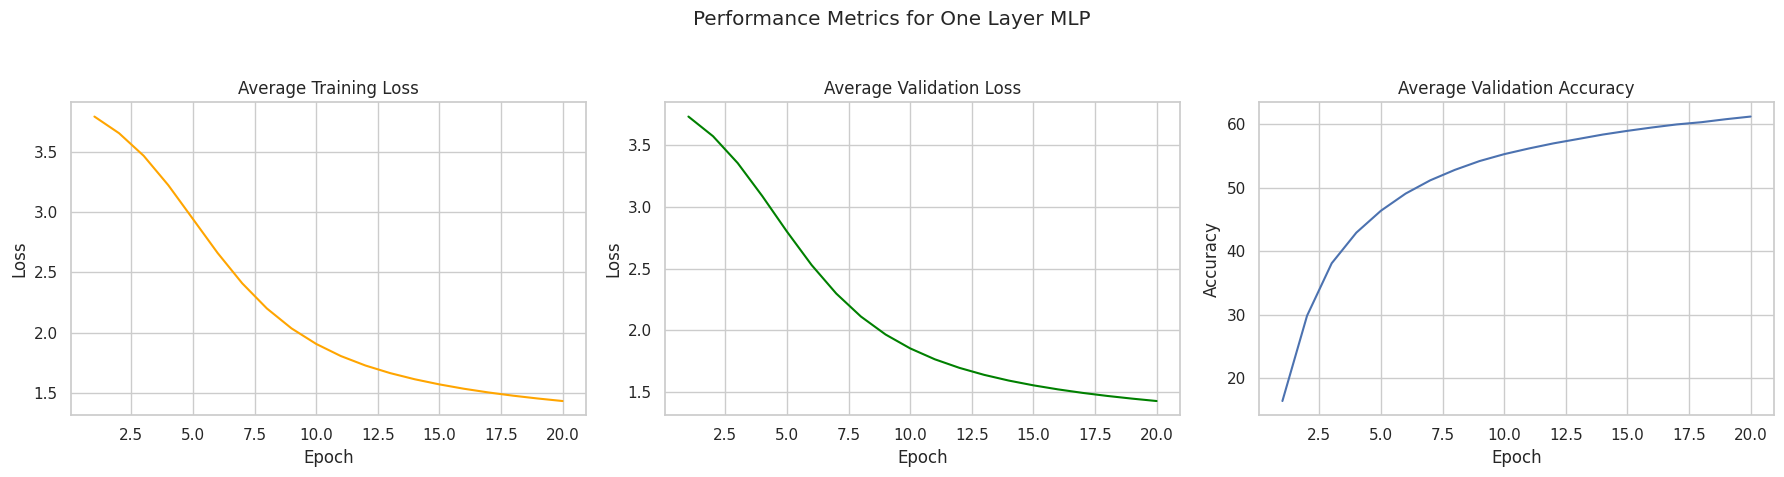

Final metrics for One Layer MLP: | Average Train Loss: 1.429853822686578 | Average Validation Loss: 1.4268700313568115 | Average Validation Accuracy: 61.25088652482269



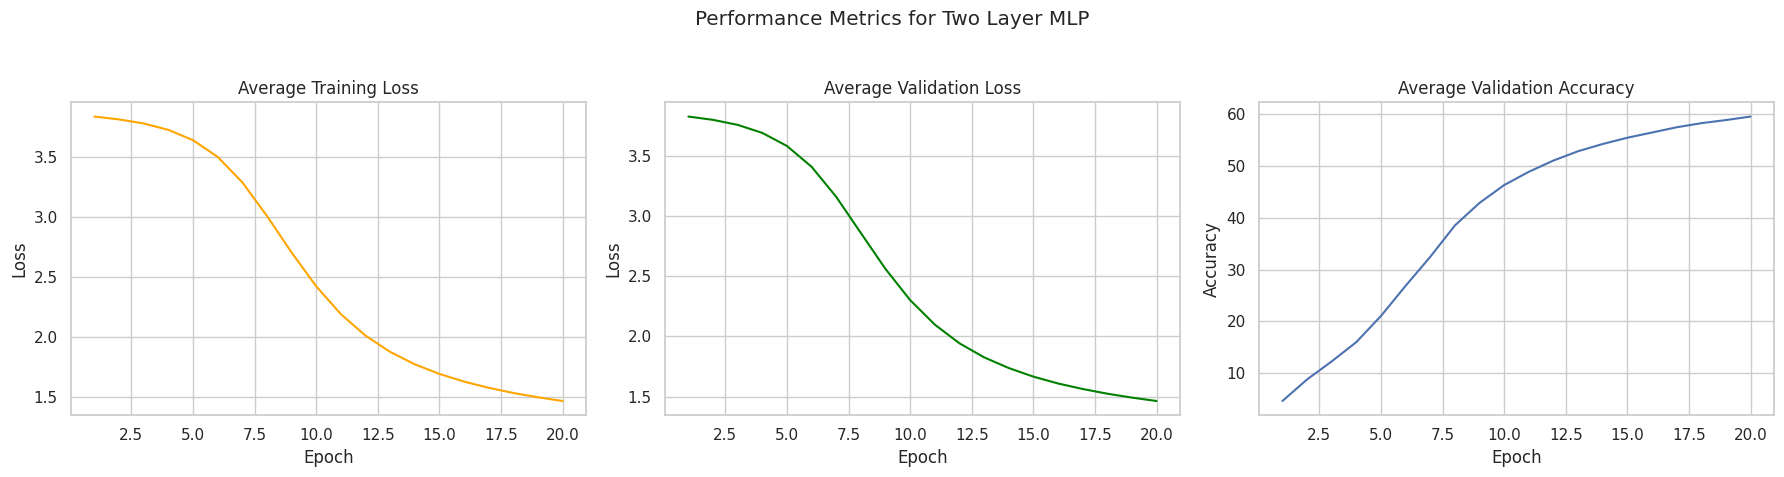

Final metrics for Two Layer MLP: | Average Train Loss: 1.4676228697017089 | Average Validation Loss: 1.4623744771215652 | Average Validation Accuracy: 59.515957446808514



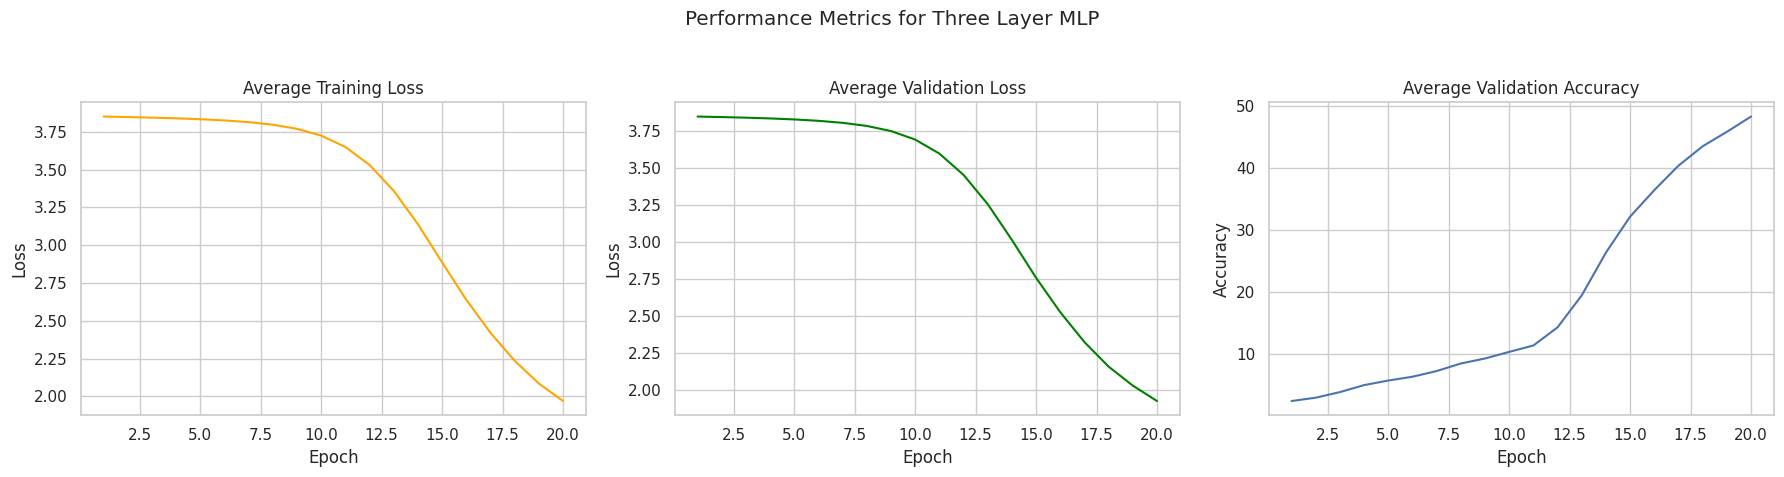

Final metrics for Three Layer MLP: | Average Train Loss: 1.9695236277445562 | Average Validation Loss: 1.925926785469055 | Average Validation Accuracy: 48.251773049645394



In [ ]:
# List of results for different numbers of layers
fold_results_list = [
    one_layer_fold_results,
    two_layer_fold_results,
    three_layer_fold_results,
]

layer_names = ['One Layer MLP', 'Two Layer MLP', 'Three Layer MLP', ]

# Loop over each set of fold results
for fold_results, name in zip(fold_results_list, layer_names):
    # Calculating the average metrics
    avg_train_loss = np.mean([results['train_losses'] for results in fold_results], axis=0)
    avg_val_loss = np.mean([results['val_losses'] for results in fold_results], axis=0)
    avg_val_accuracy = np.mean([results['val_accuracies'] for results in fold_results], axis=0)

    epochs = range(1, len(avg_val_accuracy) + 1)

    # Plotting
    plt.figure(figsize=(18, 5))
    plt.suptitle(f'Performance Metrics for {name}')

    # Plot Training Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, avg_train_loss, label='Average Training Loss', color='orange')
    plt.title('Average Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Validation Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, avg_val_loss, label='Average Validation Loss', color='green')
    plt.title('Average Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Validation Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, avg_val_accuracy, label='Average Validation Accuracy')
    plt.title('Average Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
    plt.show()

    # Print final metrics
    print(f"Final metrics for {name}: | Average Train Loss: {avg_train_loss[-1]} | Average Validation Loss: {avg_val_loss[-1]} | Average Validation Accuracy: {avg_val_accuracy[-1]}\n")



#### MLP Depth - Best results

Assessing the validation accuracy from these graphs, we find that the MLP with a single hidden layer model is the best performing model.

Therefore, we can store this setting in our model constructor

In [ ]:
# Redefining model constructor as the best performing model
def model_constructor():
    return one_layerMLP().to(device)

#### Cross Fold Plotting Function

To make the plotting process reusable for analyzing the results from grid search or any set of fold results, we can encapsulate the plotting logic into a function. This function will take fold_results as an argument and plot the averaged metrics across all folds.

In [ ]:
def plot_fold_results(fold_results, model_title):
    """
    Plots the average training loss, validation loss, and validation accuracy across all folds,
    and prints and returns the final averages along with the model title.

    Args:
    - fold_results (list): A list where each element is a dictionary containing the metrics
                           'train_losses', 'val_losses', and 'val_accuracies' for each fold.
    - model_title (str): Title of the model to include in prints and plots.

    Returns:
    - A dictionary containing the final 'average_train_loss', 'average_val_loss', and 'average_val_accuracy'
      along with the 'model_title'.
    """

    # Convert lists to DataFrames, handling variable lengths
    train_losses_df = pd.DataFrame([results['train_losses'] for results in fold_results]).T
    val_losses_df = pd.DataFrame([results['val_losses'] for results in fold_results]).T
    val_accuracies_df = pd.DataFrame([results['val_accuracies'] for results in fold_results]).T

    # Calculate the mean across columns (folds) for each metric
    avg_train_loss = train_losses_df.mean(axis=1)
    avg_val_loss = val_losses_df.mean(axis=1)
    avg_val_accuracy = val_accuracies_df.mean(axis=1)

    epochs = range(1, len(avg_val_accuracy) + 1)

    # Plotting
    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(model_title)  # Set the overall figure title

    axs[0].plot(epochs, avg_train_loss, 'orange', label='Average Training Loss')
    axs[1].plot(epochs, avg_val_loss, 'green', label='Average Validation Loss')
    axs[2].plot(epochs, avg_val_accuracy, 'blue', label='Average Validation Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    axs[0].set_ylabel('Loss')
    axs[2].set_ylabel('Accuracy')
    axs[0].set_title('Training Loss')
    axs[1].set_title('Validation Loss')
    axs[2].set_title('Validation Accuracy')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the figure title

    plt.show()

     # After plotting, print or return the final averages
    final_avg_train_loss = avg_train_loss.dropna().iloc[-1]
    final_avg_val_loss = avg_val_loss.dropna().iloc[-1]
    final_avg_val_accuracy = avg_val_accuracy.dropna().iloc[-1]

    # Printing final averages
    print(f"{model_title} - Final Average Training Loss: {final_avg_train_loss:.3f} | Final Average Validation Loss: {final_avg_val_loss:.3f} | Final Average Validation Accuracy: {final_avg_val_accuracy:.2f}%\n")

    # Return the final averages along with the model title
    return {
        'model_title': model_title,
        'final_average_train_loss': final_avg_train_loss,
        'final_average_val_loss': final_avg_val_loss,
        'final_average_val_accuracy': final_avg_val_accuracy
    }


## Optimization Techniques - MLP



### Learning Rates and Optimizers

Here we will test the three different optimizers listed below against different learning rates in order to find the best performing optimizer

three optimizers will be tested -

SGD - stochastic gradient descent, it iteratively updates model parameters using a randomly selected subset of training data, making it computationally efficient and suitable for large datasets.

ADAM - Adaptive Moment Estimation, it dynamically adjusts the learning rate for each parameter based on the gradients and past gradients' moments, effectively navigating complex optimization landscapes and accelerating convergence.

RMSprop - Root Mean Square Propagation, it adapts the learning rate for each parameter based on the magnitude of recent gradients, helping to mitigate vanishing or exploding gradients and facilitating stable training across different layers and tasks..

In [ ]:
#create function to call SGD, adam and RMSprop optimizers
def sgd_optimizer(params, lr=0.01):
    return torch.optim.SGD(params, lr=lr)

def adam_optimizer(params, lr=0.001):
    return torch.optim.Adam(params, lr=lr)

def rmsprop_optimizer(params, lr=0.001):
    return torch.optim.RMSprop(params, lr=lr)


optimizers = {
    'RMSprop': rmsprop_optimizer,
    'SGD': sgd_optimizer,
    'Adam': adam_optimizer
}

In [ ]:
# Define a set of learning rates to explore
learning_rates = [0.001, 0.01, 0.1]

### Grid Search Function

Here we define a grid search function that explores all possible combinations of Optimizers and Learning Rates, given as arguments to the function.

In [ ]:
def grid_search_optimizers_learning_rates(dataset, n_splits, model_constructor, optimizers, learning_rates, epochs, device):
    """
    Performs grid search over specified learning rates and optimizers, using stratified k-fold cross-validation.

    Parameters:
    - dataset: The dataset to use for training and validation.
    - n_splits: The number of folds for k-fold cross-validation.
    - model_constructor: Function to construct a new instance of the model.
    - optimizers: A dictionary of optimizers to explore.
    - learning_rates: A list of learning rates to explore.
    - epochs: The number of epochs to train for each fold.
    - device: The device to use for training (e.g., 'cuda' or 'cpu').

    Returns:
    - A dictionary with optimizer names and learning rates as keys and fold results as values.
    """
    all_results = {}

    for optimizer_name, optimizer_constructor in optimizers.items():
        for lr in learning_rates:
            print(f"\n**Training model with {optimizer_name} with learning rate: {lr}**\n")

            # Define the optimizer constructor with the current learning rate
            def current_optimizer_constructor(params):
                return optimizer_constructor(params, lr=lr)

            # Perform stratified k-fold cross-validation
            fold_results = stratified_k_fold_cross_validation(
                dataset=dataset,
                n_splits=n_splits,
                model_constructor=model_constructor,
                optimizer_constructor=current_optimizer_constructor,
                epochs=epochs,
                device=device
            )

            # Store the results using a combined key
            key_name = f"{optimizer_name}_LR_{lr}"
            all_results[key_name] = fold_results

    return all_results


In [ ]:
#call grid_search_optimizers_learning_rates and store results
grid_search_results = grid_search_optimizers_learning_rates(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    optimizers=optimizers,
    learning_rates=learning_rates,
    epochs=20,
    device=device
)


**Training model with RMSprop with learning rate: 0.001**

Starting fold 1/5


Epochs:  65%|██████▌   | 13/20 [00:46<00:24,  3.56s/it]


Early stopping triggered after 14 epochs.
Train time on cuda: 46.325 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 79.61%

Starting fold 2/5


Epochs:  65%|██████▌   | 13/20 [00:45<00:24,  3.48s/it]


Early stopping triggered after 14 epochs.
Train time on cuda: 45.238 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 82.62%

Starting fold 3/5


Epochs:  80%|████████  | 16/20 [00:54<00:13,  3.39s/it]


Early stopping triggered after 17 epochs.
Train time on cuda: 54.274 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 81.54%

Starting fold 4/5


Epochs:  60%|██████    | 12/20 [00:42<00:28,  3.57s/it]


Early stopping triggered after 13 epochs.
Train time on cuda: 42.851 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 82.37%

Starting fold 5/5


Epochs:  80%|████████  | 16/20 [00:55<00:13,  3.44s/it]


Early stopping triggered after 17 epochs.
Train time on cuda: 55.047 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 80.53%


**Training model with RMSprop with learning rate: 0.01**

Starting fold 1/5


Epochs:  95%|█████████▌| 19/20 [01:04<00:03,  3.38s/it]


Early stopping triggered after 20 epochs.
Train time on cuda: 64.335 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 73.87%

Starting fold 2/5


Epochs:  80%|████████  | 16/20 [00:54<00:13,  3.42s/it]


Early stopping triggered after 17 epochs.
Train time on cuda: 54.686 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 76.43%

Starting fold 3/5


Epochs:  90%|█████████ | 18/20 [01:00<00:06,  3.36s/it]


Early stopping triggered after 19 epochs.
Train time on cuda: 60.408 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 77.17%

Starting fold 4/5


Epochs:  65%|██████▌   | 13/20 [00:46<00:24,  3.54s/it]


Early stopping triggered after 14 epochs.
Train time on cuda: 46.080 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 76.03%

Starting fold 5/5


Epochs:  60%|██████    | 12/20 [00:41<00:27,  3.47s/it]


Early stopping triggered after 13 epochs.
Train time on cuda: 41.682 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 74.57%


**Training model with RMSprop with learning rate: 0.1**

Starting fold 1/5


Epochs:  75%|███████▌  | 15/20 [00:51<00:17,  3.45s/it]


Early stopping triggered after 16 epochs.
Train time on cuda: 51.801 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 2.13%

Starting fold 2/5


Epochs:  75%|███████▌  | 15/20 [00:51<00:17,  3.42s/it]


Early stopping triggered after 16 epochs.
Train time on cuda: 51.338 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 2.13%

Starting fold 3/5


Epochs:  40%|████      | 8/20 [00:29<00:44,  3.68s/it]


Early stopping triggered after 9 epochs.
Train time on cuda: 29.435 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 2.13%

Starting fold 4/5


Epochs:  55%|█████▌    | 11/20 [00:38<00:31,  3.50s/it]


Early stopping triggered after 12 epochs.
Train time on cuda: 38.565 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 2.13%

Starting fold 5/5


Epochs:  35%|███▌      | 7/20 [00:25<00:47,  3.68s/it]


Early stopping triggered after 8 epochs.
Train time on cuda: 25.763 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 2.14%


**Training model with SGD with learning rate: 0.001**

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:02<00:00,  3.13s/it]


Train time on cuda: 62.552 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 2.27%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:04<00:00,  3.20s/it]


Train time on cuda: 64.029 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 4.57%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:03<00:00,  3.18s/it]


Train time on cuda: 63.544 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 4.26%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:07<00:00,  3.37s/it]


Train time on cuda: 67.417 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 2.91%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:04<00:00,  3.20s/it]


Train time on cuda: 64.046 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 3.39%


**Training model with SGD with learning rate: 0.01**

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:04<00:00,  3.22s/it]


Train time on cuda: 64.471 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 47.86%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:23<00:00,  4.19s/it]


Train time on cuda: 83.864 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 49.76%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:44<00:00,  5.24s/it]


Train time on cuda: 104.792 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 47.98%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:14<00:00,  3.73s/it]


Train time on cuda: 74.554 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 48.42%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:04<00:00,  3.24s/it]


Train time on cuda: 64.722 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 48.49%


**Training model with SGD with learning rate: 0.1**

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:16<00:00,  3.85s/it]


Train time on cuda: 77.008 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 79.75%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:03<00:00,  3.18s/it]


Train time on cuda: 63.604 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 80.32%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:04<00:00,  3.21s/it]


Train time on cuda: 64.185 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 79.09%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:03<00:00,  3.16s/it]


Train time on cuda: 63.136 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 80.11%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:04<00:00,  3.20s/it]


Train time on cuda: 64.029 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 80.98%


**Training model with Adam with learning rate: 0.001**

Starting fold 1/5


Epochs:  85%|████████▌ | 17/20 [00:59<00:10,  3.48s/it]


Early stopping triggered after 18 epochs.
Train time on cuda: 59.190 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 85.02%

Starting fold 2/5


Epochs:  80%|████████  | 16/20 [00:54<00:13,  3.43s/it]


Early stopping triggered after 17 epochs.
Train time on cuda: 54.952 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 84.14%

Starting fold 3/5


Epochs:  70%|███████   | 14/20 [00:48<00:20,  3.45s/it]


Early stopping triggered after 15 epochs.
Train time on cuda: 48.253 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 84.85%

Starting fold 4/5


Epochs:  80%|████████  | 16/20 [00:56<00:14,  3.55s/it]


Early stopping triggered after 17 epochs.
Train time on cuda: 56.889 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 85.11%

Starting fold 5/5


Epochs:  65%|██████▌   | 13/20 [00:45<00:24,  3.49s/it]


Early stopping triggered after 14 epochs.
Train time on cuda: 45.344 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 84.70%


**Training model with Adam with learning rate: 0.01**

Starting fold 1/5


Epochs:  50%|█████     | 10/20 [00:35<00:35,  3.54s/it]


Early stopping triggered after 11 epochs.
Train time on cuda: 35.455 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 81.81%

Starting fold 2/5


Epochs:  40%|████      | 8/20 [00:29<00:44,  3.71s/it]


Early stopping triggered after 9 epochs.
Train time on cuda: 29.677 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 81.38%

Starting fold 3/5


Epochs:  40%|████      | 8/20 [00:29<00:43,  3.65s/it]


Early stopping triggered after 9 epochs.
Train time on cuda: 29.188 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 81.61%

Starting fold 4/5


Epochs:  45%|████▌     | 9/20 [00:32<00:39,  3.61s/it]


Early stopping triggered after 10 epochs.
Train time on cuda: 32.541 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 81.25%

Starting fold 5/5


Epochs:  40%|████      | 8/20 [00:30<00:45,  3.82s/it]


Early stopping triggered after 9 epochs.
Train time on cuda: 30.564 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 81.69%


**Training model with Adam with learning rate: 0.1**

Starting fold 1/5


Epochs:  30%|███       | 6/20 [00:22<00:52,  3.74s/it]


Early stopping triggered after 7 epochs.
Train time on cuda: 22.477 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 2.13%

Starting fold 2/5


Epochs:  25%|██▌       | 5/20 [00:19<00:59,  3.96s/it]


Early stopping triggered after 6 epochs.
Train time on cuda: 19.807 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 2.13%

Starting fold 3/5


Epochs:  65%|██████▌   | 13/20 [00:45<00:24,  3.52s/it]


Early stopping triggered after 14 epochs.
Train time on cuda: 45.719 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 7.27%

Starting fold 4/5


Epochs:  50%|█████     | 10/20 [00:36<00:36,  3.61s/it]


Early stopping triggered after 11 epochs.
Train time on cuda: 36.115 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 16.83%

Starting fold 5/5


Epochs:  25%|██▌       | 5/20 [00:19<00:58,  3.91s/it]

Early stopping triggered after 6 epochs.
Train time on cuda: 19.581 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 2.13%



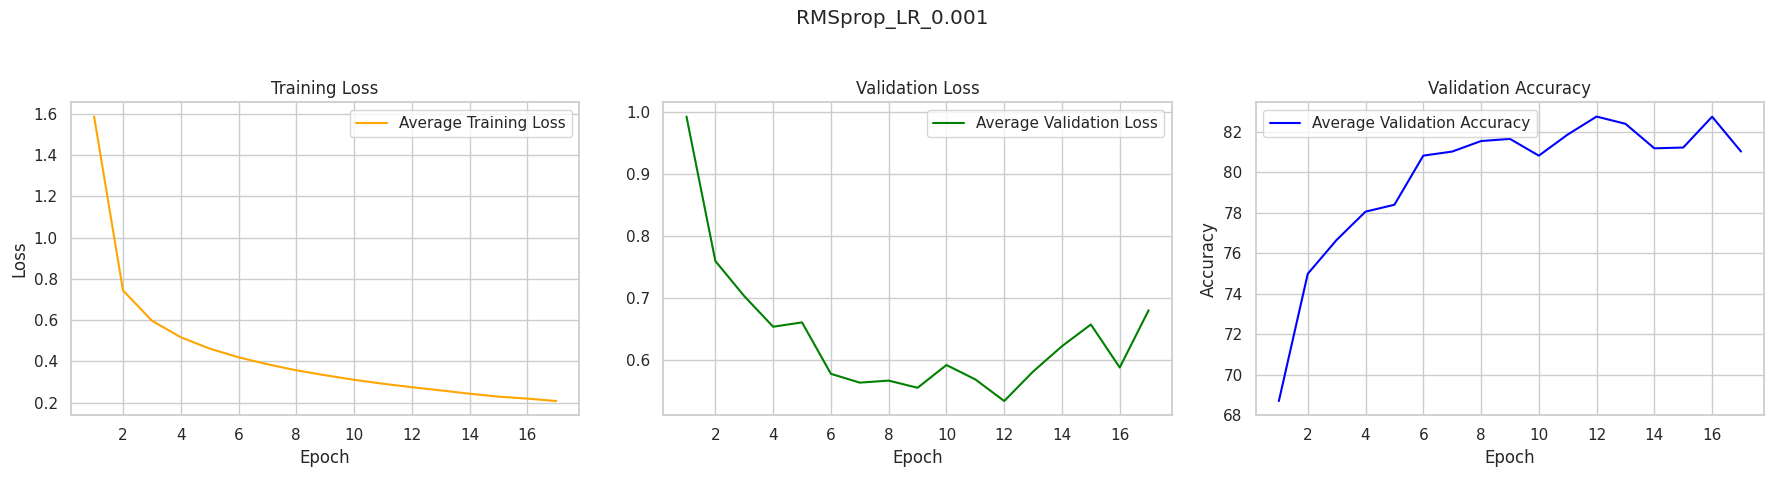

RMSprop_LR_0.001 - Final Average Training Loss: 0.208 | Final Average Validation Loss: 0.680 | Final Average Validation Accuracy: 81.04%



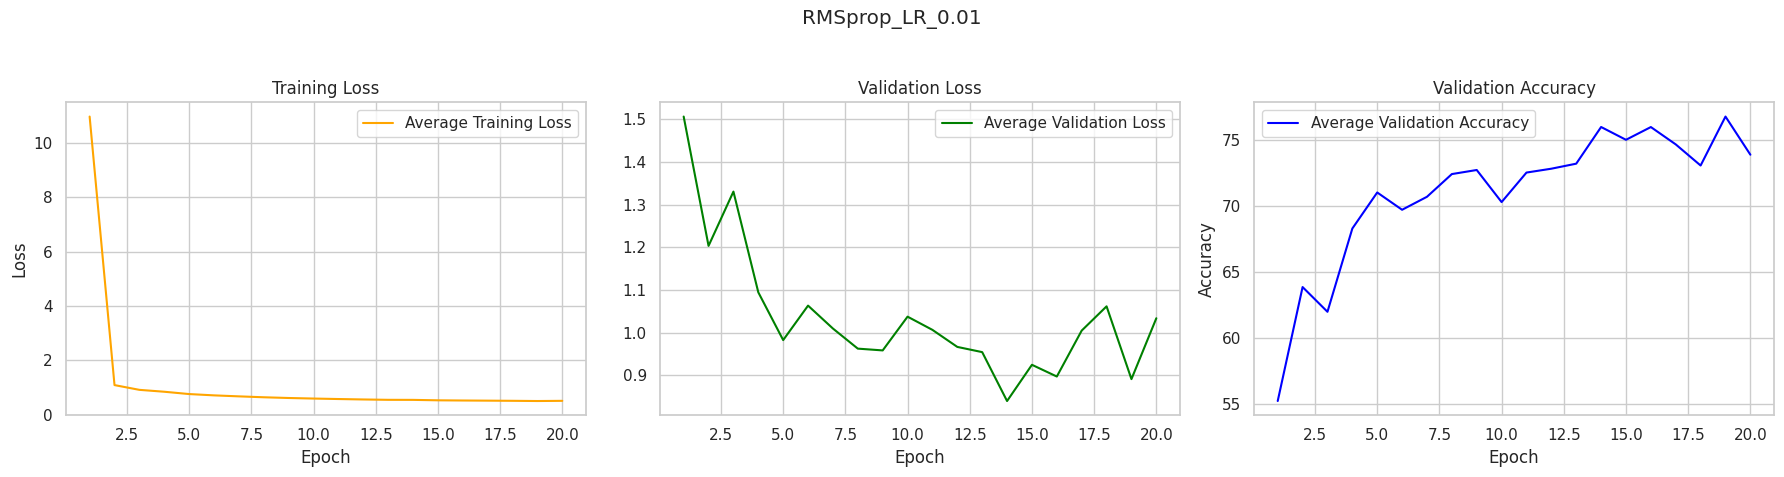

RMSprop_LR_0.01 - Final Average Training Loss: 0.515 | Final Average Validation Loss: 1.034 | Final Average Validation Accuracy: 73.87%



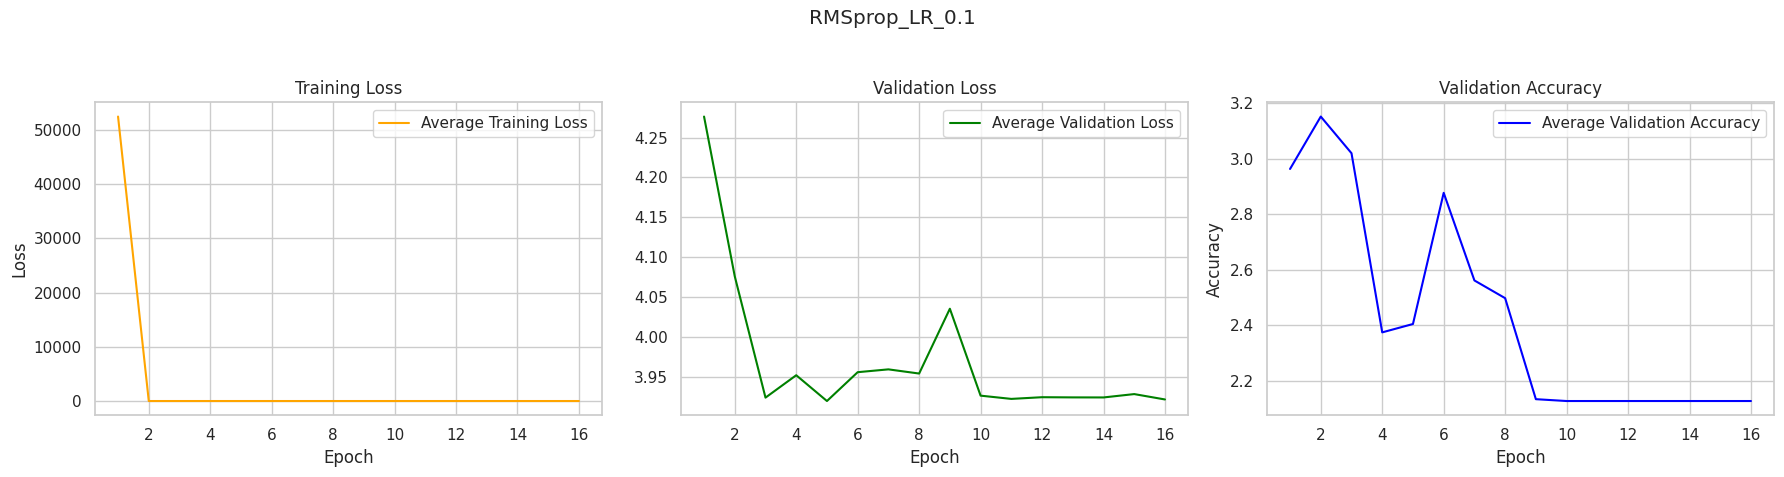

RMSprop_LR_0.1 - Final Average Training Loss: 3.859 | Final Average Validation Loss: 3.922 | Final Average Validation Accuracy: 2.13%



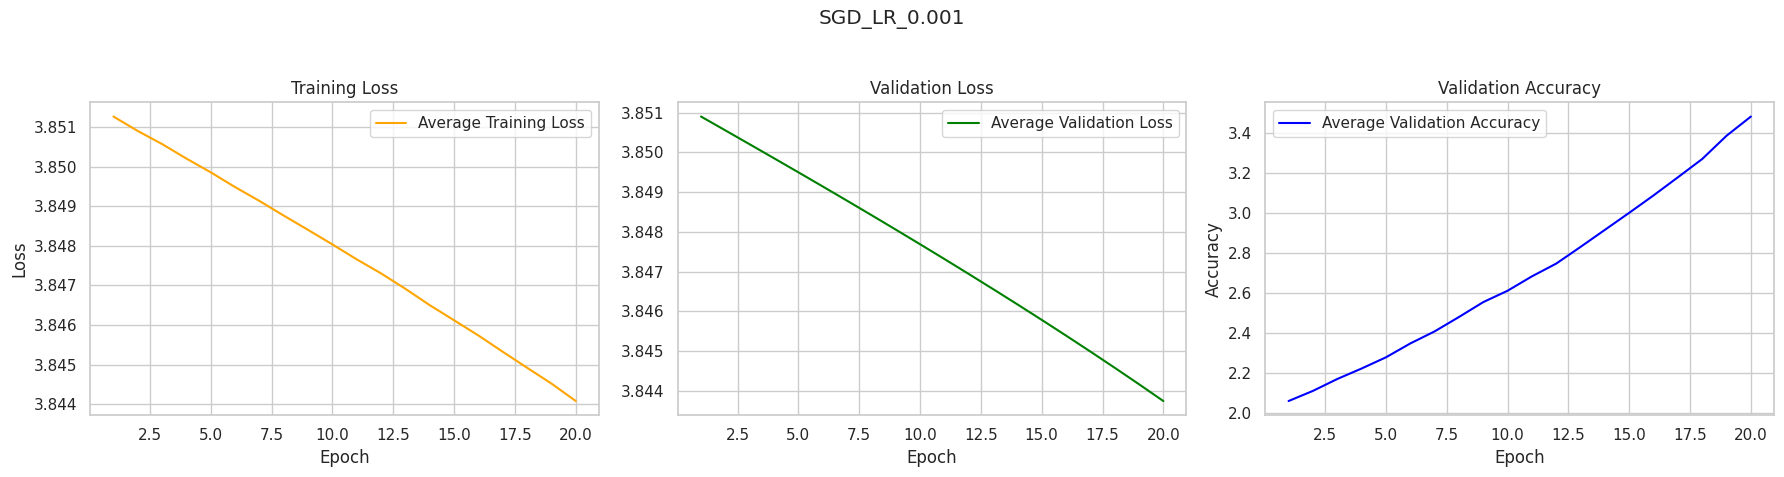

SGD_LR_0.001 - Final Average Training Loss: 3.844 | Final Average Validation Loss: 3.844 | Final Average Validation Accuracy: 3.48%



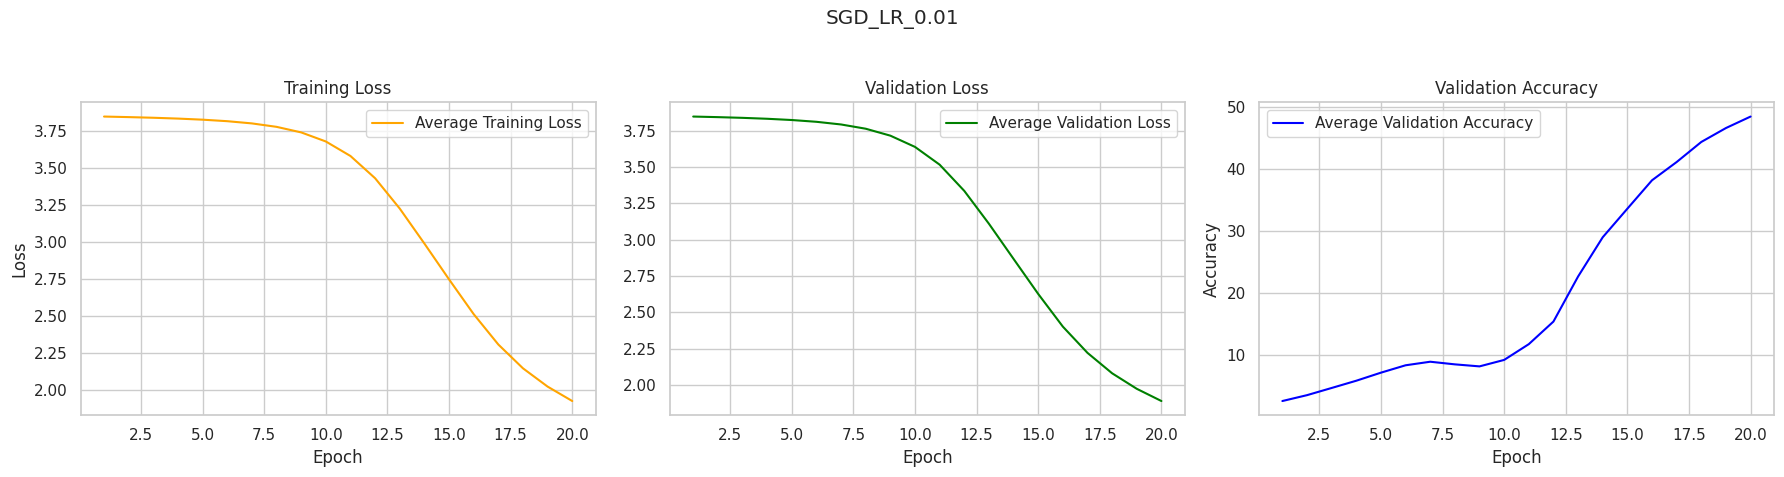

SGD_LR_0.01 - Final Average Training Loss: 1.924 | Final Average Validation Loss: 1.890 | Final Average Validation Accuracy: 48.50%



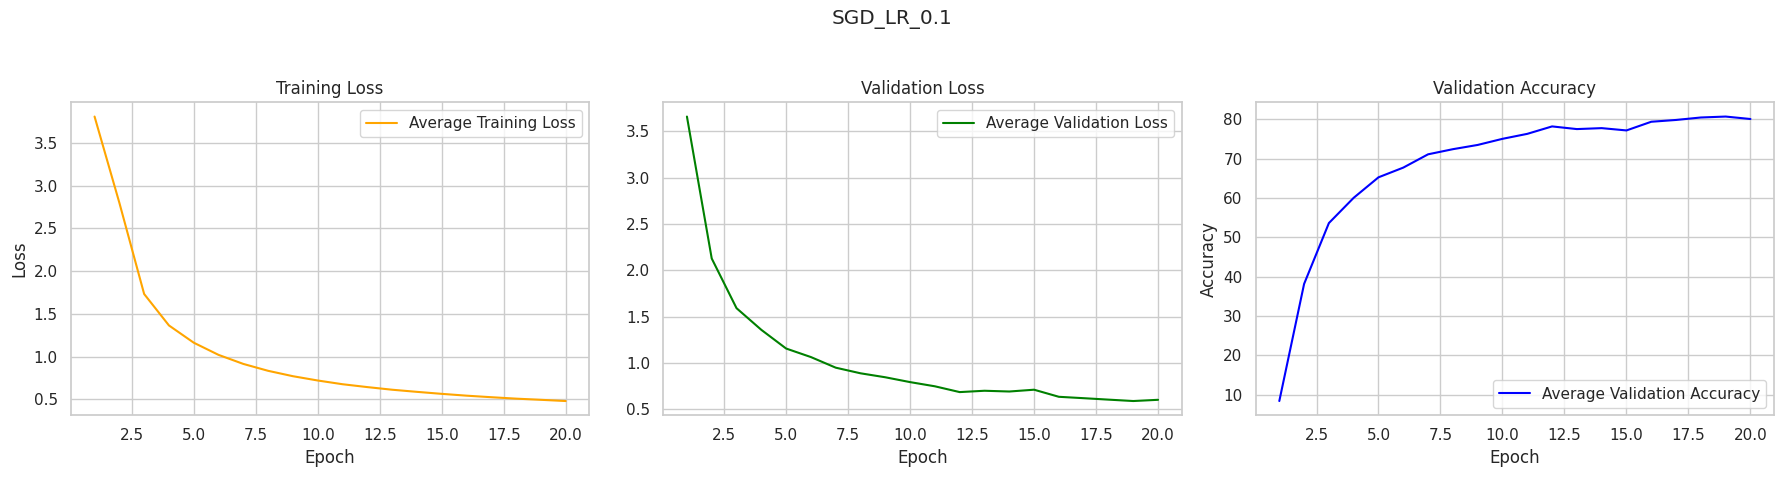

SGD_LR_0.1 - Final Average Training Loss: 0.481 | Final Average Validation Loss: 0.604 | Final Average Validation Accuracy: 80.05%



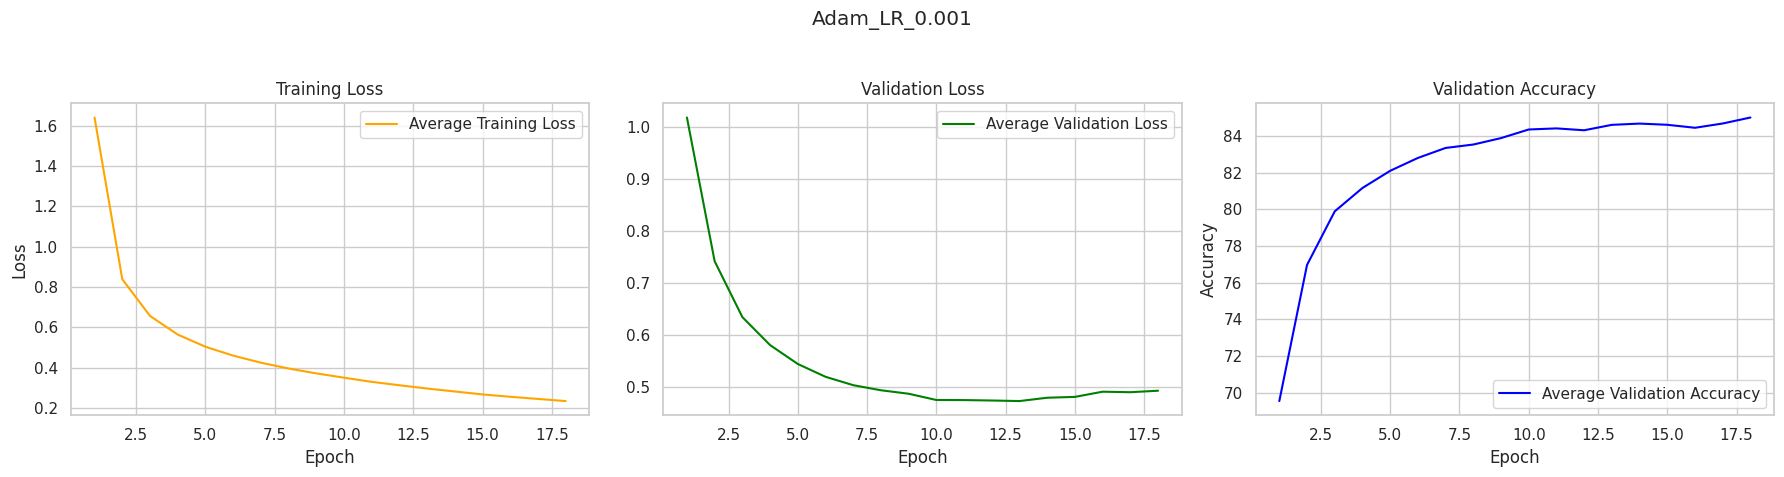

Adam_LR_0.001 - Final Average Training Loss: 0.235 | Final Average Validation Loss: 0.493 | Final Average Validation Accuracy: 85.02%



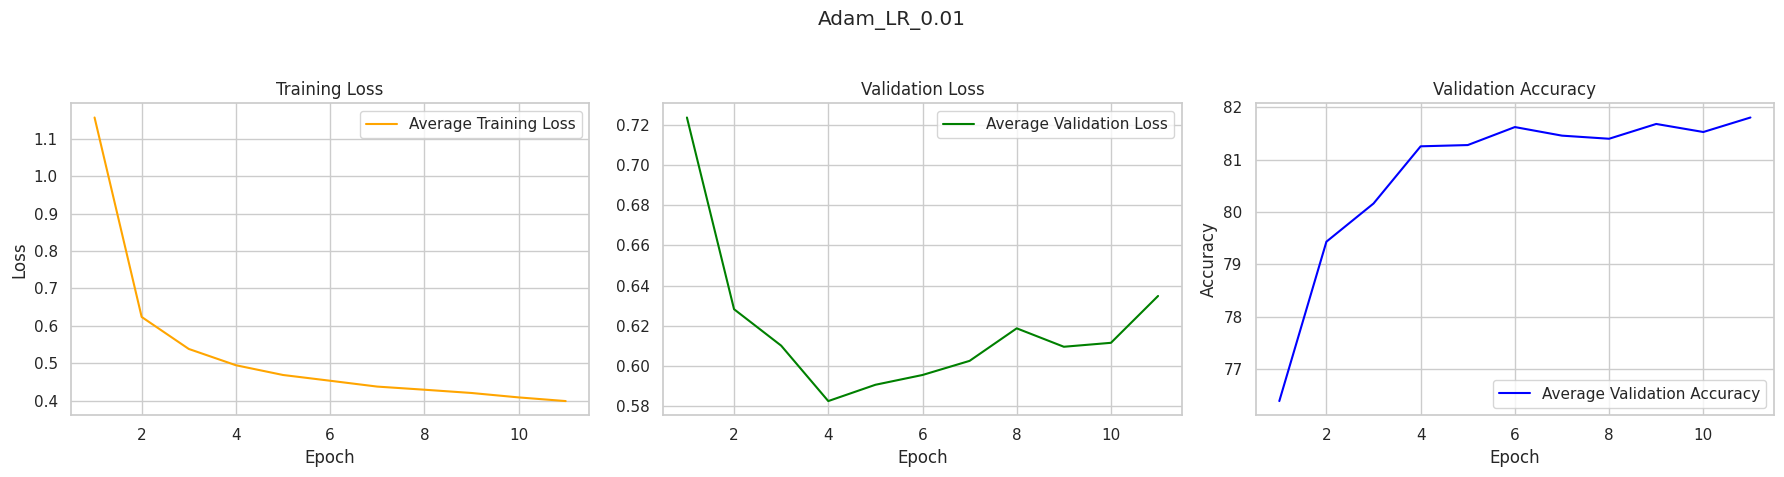

Adam_LR_0.01 - Final Average Training Loss: 0.399 | Final Average Validation Loss: 0.635 | Final Average Validation Accuracy: 81.81%



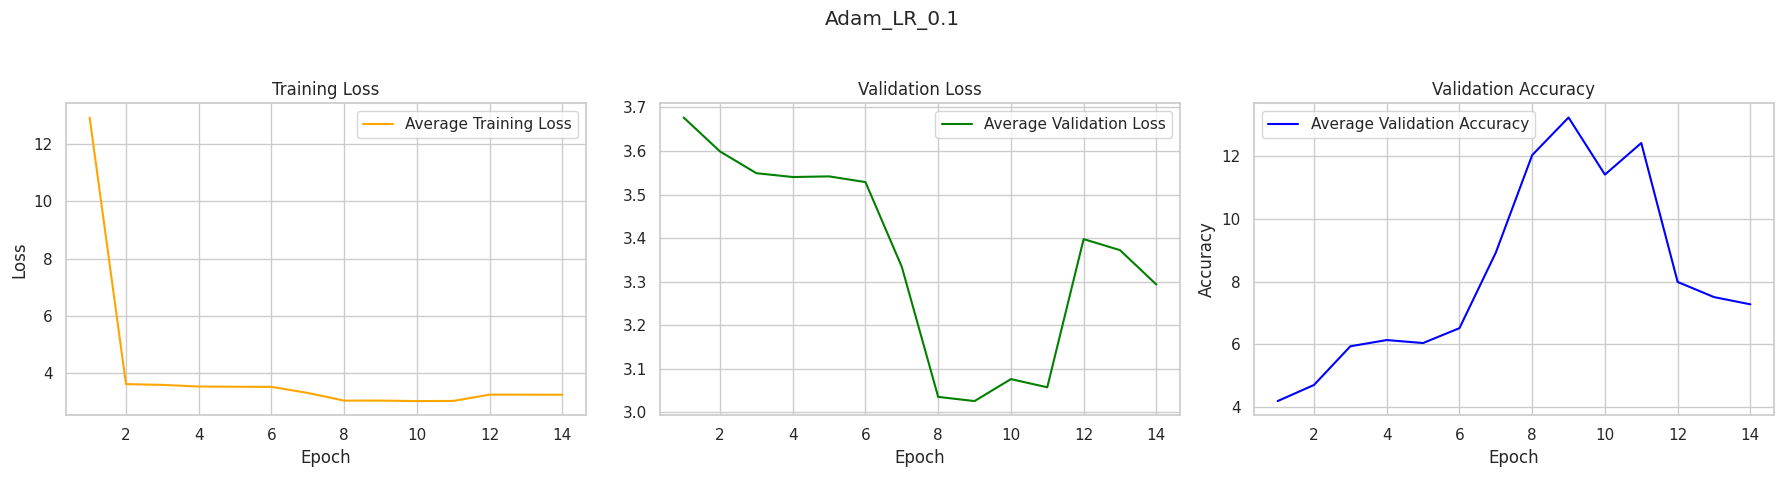

Adam_LR_0.1 - Final Average Training Loss: 3.260 | Final Average Validation Loss: 3.293 | Final Average Validation Accuracy: 7.27%



In [ ]:
# Let's initialise a list to hold a summary of the training results
results_summary_list = []

# We then loop through all combinations in grid_search_results
for combo_name, fold_results in grid_search_results.items():
    # Plot the results and capture the returned summary
    summary = plot_fold_results(fold_results, combo_name)

    # Add the summary to the list
    results_summary_list.append(summary)

In [ ]:
# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(results_summary_list)

# Ensure 'final_average_val_accuracy' is numeric (it should be, but this is just in case)
results_df['final_average_val_accuracy'] = pd.to_numeric(results_df['final_average_val_accuracy'])

# Sort the DataFrame by 'final_average_val_accuracy' in ascending order
results_df_sorted = results_df.sort_values('final_average_val_accuracy', ascending=False)

# Display the sorted DataFrame
display(results_df_sorted)

model_title  final_average_train_loss  final_average_val_loss  \
6     Adam_LR_0.001                  0.234724                0.492734   
7      Adam_LR_0.01                  0.398927                0.634777   
0  RMSprop_LR_0.001                  0.207685                0.679689   
5        SGD_LR_0.1                  0.480853                0.604032   
1   RMSprop_LR_0.01                  0.515225                1.033747   
4       SGD_LR_0.01                  1.924302                1.890391   
8       Adam_LR_0.1                  3.260089                3.293483   
3      SGD_LR_0.001                  3.844083                3.843743   
2    RMSprop_LR_0.1                  3.858666                3.921936   

   final_average_val_accuracy  
6                   85.017730  
7                   81.808511  
0                   81.035018  
5                   80.049645  
1                   73.865248  
4                   48.501773  
8                    7.273936  
3                    3.479610  
2                    2.127660

**The 3 best combinations for our MLP model were:**

- Adam Optimizer with a Learning Rate of 0.001,
- RMS Prop Optimizer with a Learning Rate of 0.001 and
- SGD with a learning rate of 0.01.

Therefore, we will use each of these in our upcoming experiments.


### Learning Rate Schedulers

To be able to explore learning rate schedulers, we need to define different optimizer and scheduler constructors, which we can also use in grid search. We'll use the 3 best optimizers that we previously discovered, and explore the impact that different learning rate schedulers have on the average validation accuracy across all k-fold

In [ ]:
def adam_optimizer(params, lr=0.001):
    return torch.optim.Adam(params, lr=lr)

def rmsprop_optimizer(params, lr=0.001):
    return torch.optim.RMSprop(params, lr=lr)

# Define lr_scheduler constructors, given a Learning Rate.

def step_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def exponential_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.2)

# We can then combine optimizers with schedulers in a dictionary, which we can loop over (effectively performing grid search).
optimizer_scheduler_combinations = {
    'SGD_StepLR': (sgd_optimizer, step_lr_scheduler, {'lr': 0.01}),
    'SGD_ExponentialLR': (sgd_optimizer, exponential_lr_scheduler, {'lr': 0.01}),
    'Adam_StepLR': (adam_optimizer, step_lr_scheduler, {'lr': 0.001}),
    'Adam_ExponentialLR': (adam_optimizer, exponential_lr_scheduler, {'lr': 0.001}),
    'RMSprop_StepLR': (rmsprop_optimizer, step_lr_scheduler, {'lr': 0.001}),
    'RMSprop_ExponentialLR': (rmsprop_optimizer, exponential_lr_scheduler, {'lr': 0.001}),
}


We then need to update our train_and_validate_model function to take scheduler as an argument.

In [ ]:
def train_and_validate_model(train_loader, val_loader, model, optimizer, scheduler, epochs, device):

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()  # Set model to training mode
        train_loss = 0

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Update the learning rate after each epoch
        scheduler.step()

        model.eval()
        val_loss = 0
        correct = 0
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += F.cross_entropy(y_pred, y).item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)

    return train_losses, val_losses, val_accuracies

We also need to modify our stratified k-fold cross validation function to accept an optimizer scheduler constructor.

In [ ]:
# We also need to modify our k-fold cross validation function:
def stratified_k_fold_cross_validation(dataset, n_splits, model_constructor, setup_optimizer_scheduler, epochs, device):
    """
    Performs stratified k-fold cross-validation for the given dataset and model.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - setup_optimizer_scheduler: Initialises the the optimizer and scheduler
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    """
    features = dataset.tensors[0].numpy()
    labels = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        # Start timing here
        fold_start_time = timer()

        # Splitting the dataset into training and validation for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Creating data loaders for the current fold
        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        # Initializing the model, optimizer and early stopping tollerance, for the current fold
        model = model_constructor().to(device)
        optimizer, scheduler = setup_optimizer_scheduler(model.parameters())

        # Training and validation for the current fold
        train_losses, val_losses, val_accuracies = train_and_validate_model(
            train_loader, val_loader, model, optimizer, scheduler, epochs, device
        )

         # End timing here
        fold_end_time = timer()

        fold_train_time = fold_end_time - fold_start_time

        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'train_time': fold_train_time
        })

        print_train_time(fold_start_time, fold_end_time, device)

        print(f"Fold {fold} completed. Validation accuracy: {val_accuracies[-1]:.2f}\n")

    return fold_results


Finally, we can define a function to manage grid search of the optimizer and learning schedulers for our model.

In [ ]:
def grid_search_optimizers_schedulers(dataset, n_splits, model_constructor, optimizer_scheduler_combinations, epochs, device):
    all_results = {}

    for name, (optimizer_constructor, scheduler_constructor, optimizer_args) in optimizer_scheduler_combinations.items():
        print(f"Testing optimizer and scheduler combination: {name}\n")

        # Adjust the function to construct both optimizer and scheduler
        def optimizer_and_scheduler_constructor(params):
            optimizer = optimizer_constructor(params, **optimizer_args)
            scheduler = scheduler_constructor(optimizer)
            return optimizer, scheduler

        fold_results = stratified_k_fold_cross_validation(
            dataset=dataset,
            n_splits=n_splits,
            model_constructor=model_constructor,
            setup_optimizer_scheduler=optimizer_and_scheduler_constructor,
            epochs=epochs,
            device=device
        )

        all_results[name] = fold_results

    return all_results

In [ ]:
# call grid_search_optimizers_schedulers function and store results
optim_schedule_grid_search = grid_search_optimizers_schedulers(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    optimizer_scheduler_combinations=optimizer_scheduler_combinations,
    epochs=20,
    device=device
)

Testing optimizer and scheduler combination: SGD_StepLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:23<00:00,  4.19s/it]


Train time on cuda: 83.781 seconds
Fold 1 completed. Validation accuracy: 67.28

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:22<00:00,  4.14s/it]


Train time on cuda: 82.817 seconds
Fold 2 completed. Validation accuracy: 65.66

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:22<00:00,  4.13s/it]


Train time on cuda: 82.594 seconds
Fold 3 completed. Validation accuracy: 66.83

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


Train time on cuda: 81.763 seconds
Fold 4 completed. Validation accuracy: 66.40

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.06s/it]


Train time on cuda: 81.145 seconds
Fold 5 completed. Validation accuracy: 67.19

Testing optimizer and scheduler combination: SGD_ExponentialLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.10s/it]


Train time on cuda: 82.007 seconds
Fold 1 completed. Validation accuracy: 6.63

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.09s/it]


Train time on cuda: 81.726 seconds
Fold 2 completed. Validation accuracy: 4.69

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:22<00:00,  4.10s/it]


Train time on cuda: 82.015 seconds
Fold 3 completed. Validation accuracy: 6.07

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.05s/it]


Train time on cuda: 81.058 seconds
Fold 4 completed. Validation accuracy: 7.62

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.07s/it]


Train time on cuda: 81.444 seconds
Fold 5 completed. Validation accuracy: 6.09

Testing optimizer and scheduler combination: Adam_StepLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:26<00:00,  4.32s/it]


Train time on cuda: 86.482 seconds
Fold 1 completed. Validation accuracy: 86.07

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:25<00:00,  4.26s/it]


Train time on cuda: 85.140 seconds
Fold 2 completed. Validation accuracy: 85.74

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:25<00:00,  4.29s/it]


Train time on cuda: 85.855 seconds
Fold 3 completed. Validation accuracy: 85.89

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:25<00:00,  4.28s/it]


Train time on cuda: 85.695 seconds
Fold 4 completed. Validation accuracy: 85.99

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:38<00:00,  4.91s/it]


Train time on cuda: 98.243 seconds
Fold 5 completed. Validation accuracy: 85.59

Testing optimizer and scheduler combination: Adam_ExponentialLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:51<00:00,  5.56s/it]


Train time on cuda: 111.244 seconds
Fold 1 completed. Validation accuracy: 82.26

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:48<00:00,  5.41s/it]


Train time on cuda: 108.205 seconds
Fold 2 completed. Validation accuracy: 81.45

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


Train time on cuda: 95.506 seconds
Fold 3 completed. Validation accuracy: 81.63

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:34<00:00,  4.73s/it]


Train time on cuda: 94.642 seconds
Fold 4 completed. Validation accuracy: 81.89

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:55<00:00,  5.79s/it]


Train time on cuda: 115.733 seconds
Fold 5 completed. Validation accuracy: 81.92

Testing optimizer and scheduler combination: RMSprop_StepLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:24<00:00,  4.24s/it]


Train time on cuda: 84.739 seconds
Fold 1 completed. Validation accuracy: 85.98

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:24<00:00,  4.23s/it]


Train time on cuda: 84.571 seconds
Fold 2 completed. Validation accuracy: 85.56

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:24<00:00,  4.24s/it]


Train time on cuda: 84.883 seconds
Fold 3 completed. Validation accuracy: 85.56

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:24<00:00,  4.20s/it]


Train time on cuda: 84.021 seconds
Fold 4 completed. Validation accuracy: 86.17

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:24<00:00,  4.23s/it]


Train time on cuda: 84.647 seconds
Fold 5 completed. Validation accuracy: 85.70

Testing optimizer and scheduler combination: RMSprop_ExponentialLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:25<00:00,  4.25s/it]


Train time on cuda: 85.030 seconds
Fold 1 completed. Validation accuracy: 82.84

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:23<00:00,  4.19s/it]


Train time on cuda: 83.888 seconds
Fold 2 completed. Validation accuracy: 82.64

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:26<00:00,  4.30s/it]


Train time on cuda: 86.075 seconds
Fold 3 completed. Validation accuracy: 83.13

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:24<00:00,  4.22s/it]


Train time on cuda: 84.480 seconds
Fold 4 completed. Validation accuracy: 83.12

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:24<00:00,  4.25s/it]

Train time on cuda: 84.934 seconds
Fold 5 completed. Validation accuracy: 82.73



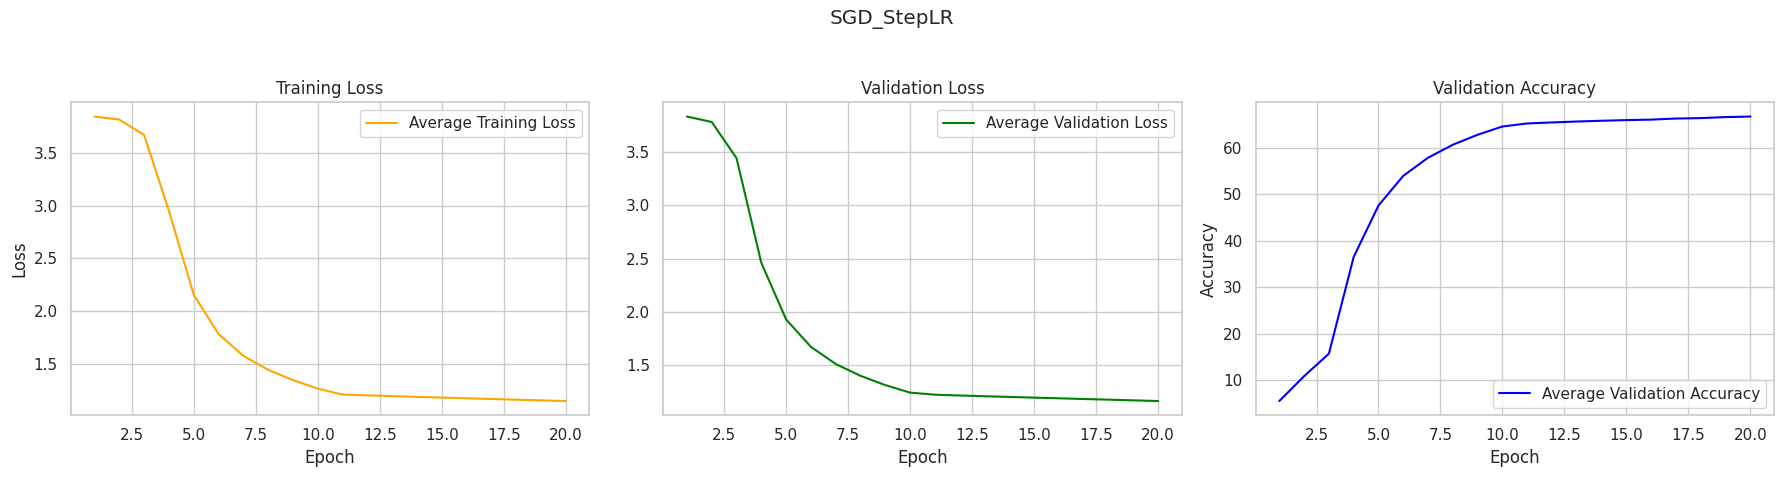

SGD_StepLR - Final Average Training Loss: 1.150 | Final Average Validation Loss: 1.162 | Final Average Validation Accuracy: 66.67%



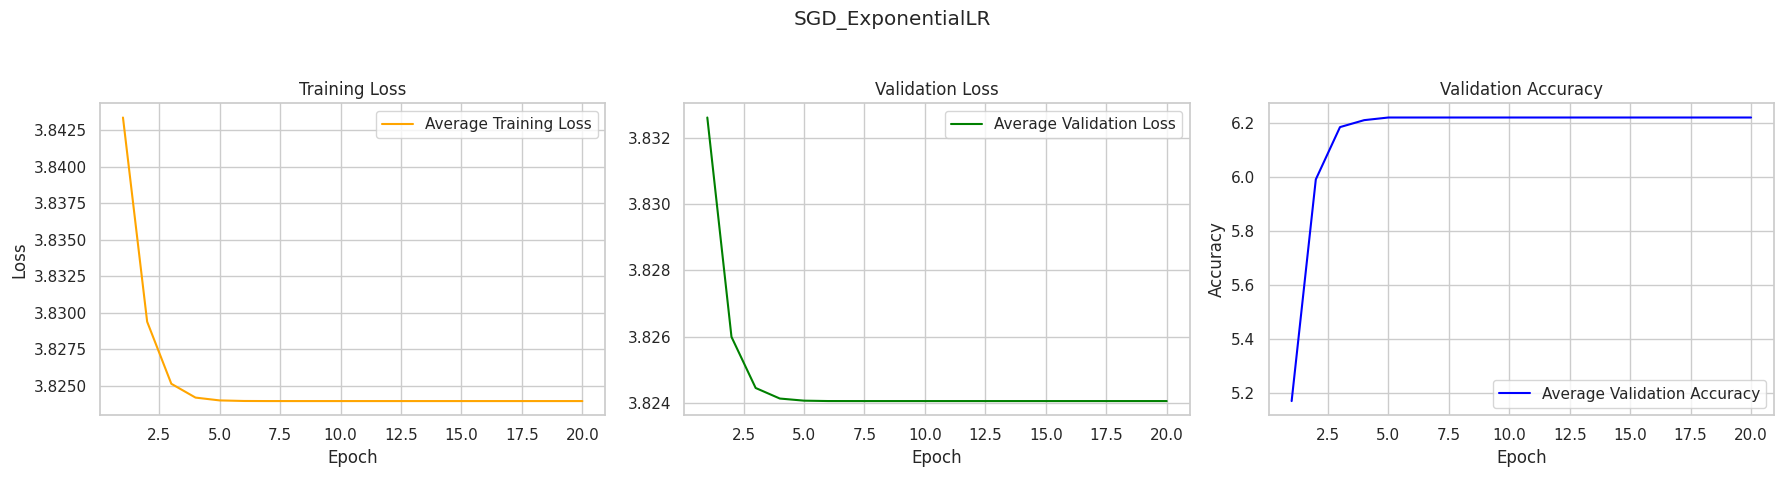

SGD_ExponentialLR - Final Average Training Loss: 3.824 | Final Average Validation Loss: 3.824 | Final Average Validation Accuracy: 6.22%



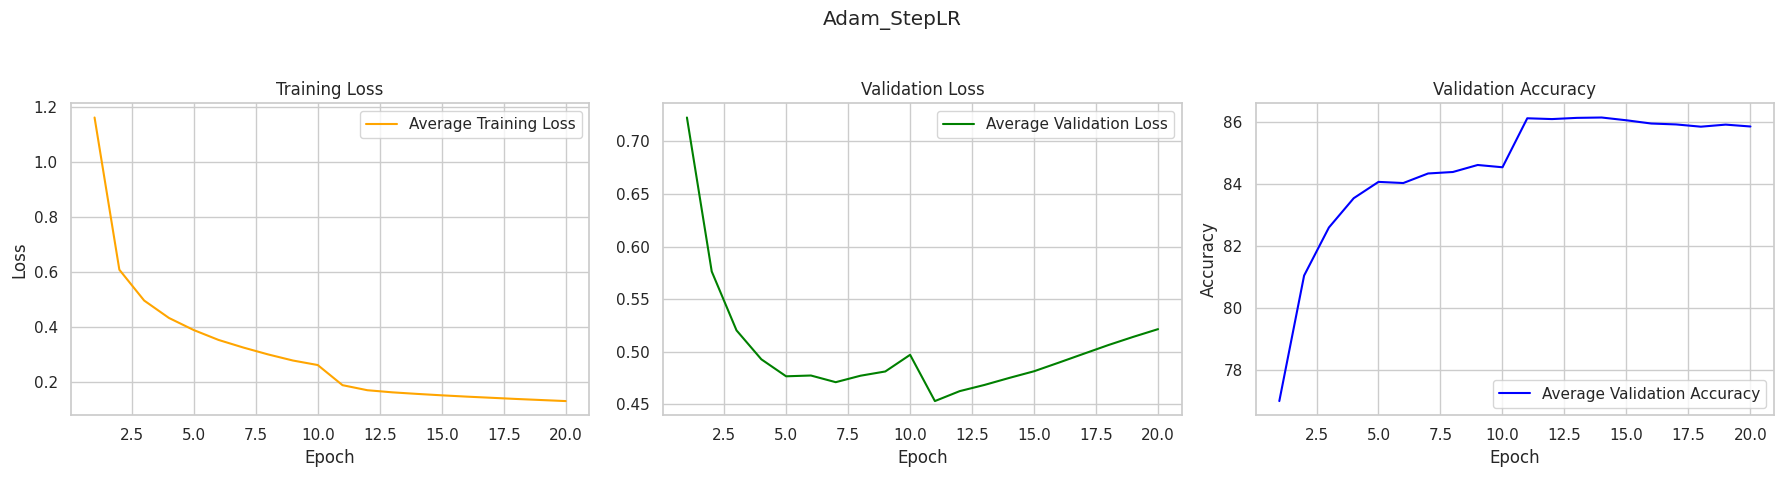

Adam_StepLR - Final Average Training Loss: 0.131 | Final Average Validation Loss: 0.522 | Final Average Validation Accuracy: 85.86%



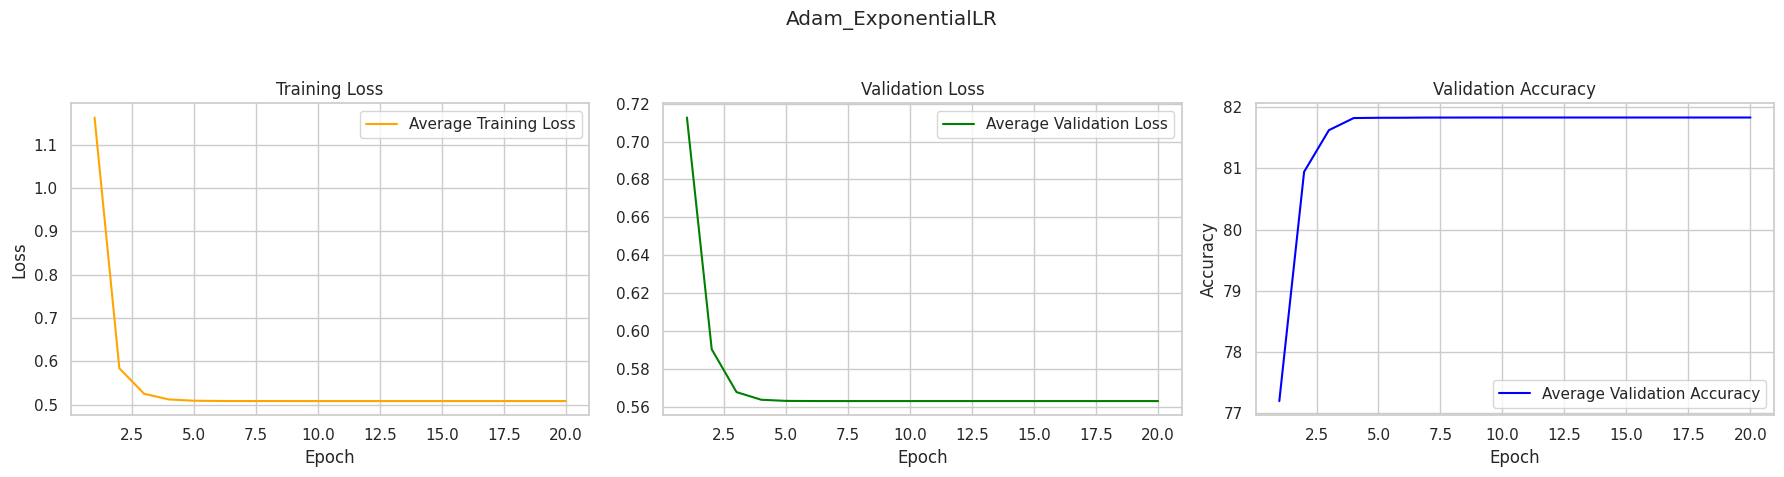

Adam_ExponentialLR - Final Average Training Loss: 0.508 | Final Average Validation Loss: 0.563 | Final Average Validation Accuracy: 81.83%



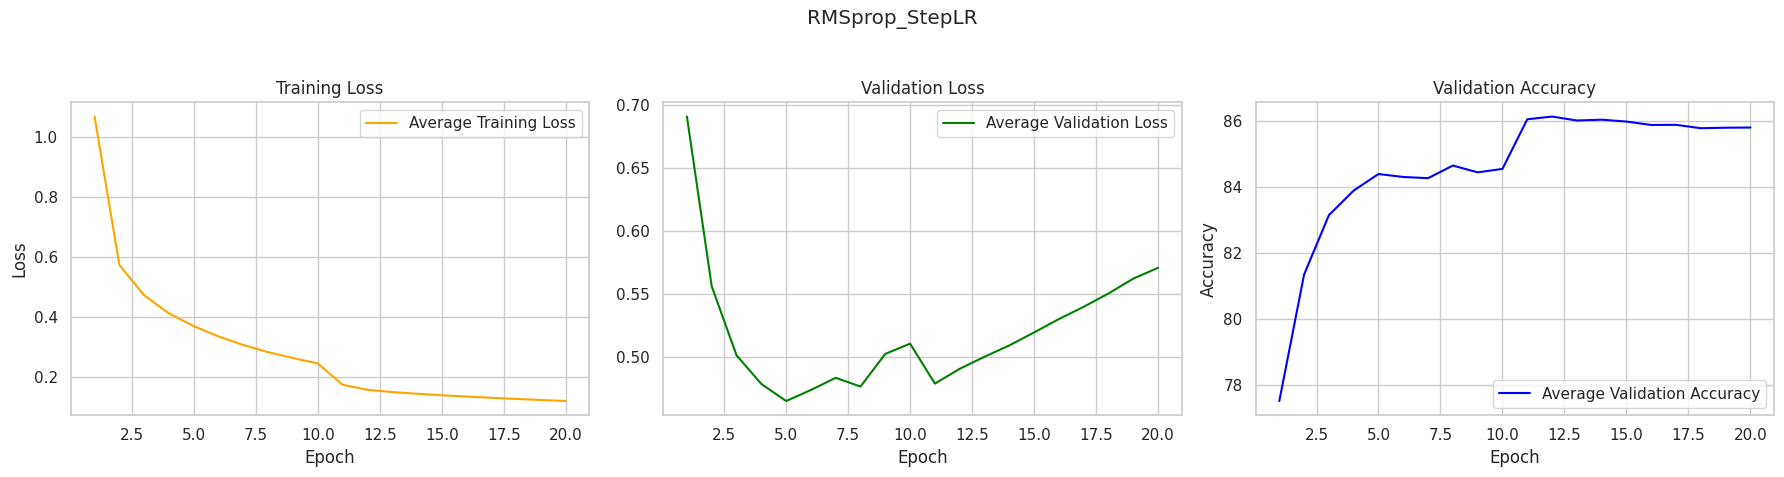

RMSprop_StepLR - Final Average Training Loss: 0.118 | Final Average Validation Loss: 0.571 | Final Average Validation Accuracy: 85.79%



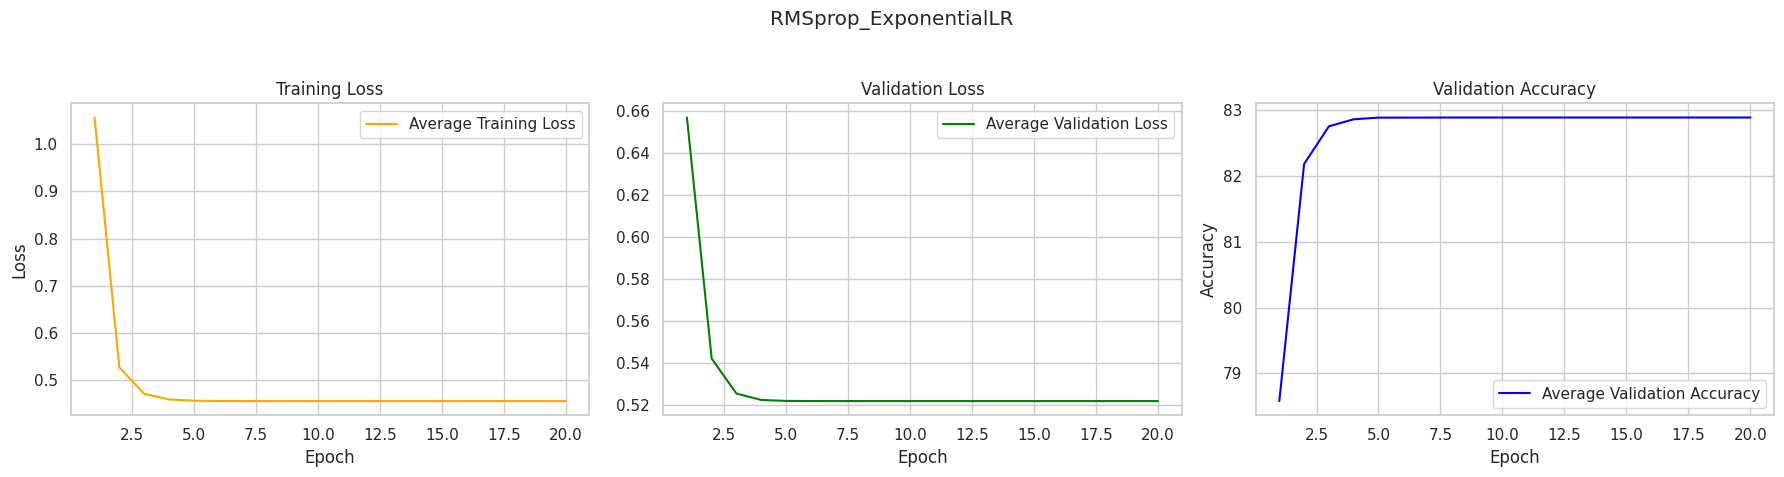

RMSprop_ExponentialLR - Final Average Training Loss: 0.456 | Final Average Validation Loss: 0.522 | Final Average Validation Accuracy: 82.89%



In [ ]:
# Let's initialise a new list to hold a summary of the training results
scheduler_results_summary_list = []

# We then loop through all combinations in grid_search_results
for combo_name, fold_results in optim_schedule_grid_search.items():
    # Plot the results and capture the returned summary
    summary = plot_fold_results(fold_results, combo_name)

    # Add the summary to the list
    scheduler_results_summary_list.append(summary)


In [ ]:
# Convert the list of dictionaries into a DataFrame
scheduler_results_df = pd.DataFrame(scheduler_results_summary_list)

# Ensure 'final_average_val_accuracy' is numeric (it should be, but this is just in case)
scheduler_results_df['final_average_val_accuracy'] = pd.to_numeric(scheduler_results_df['final_average_val_accuracy'])

# Sort the DataFrame by 'final_average_val_accuracy' in ascending order
scheduler_results_df_sorted = scheduler_results_df.sort_values('final_average_val_accuracy', ascending=False)

# Display the sorted DataFrame
display(scheduler_results_df_sorted)

model_title  final_average_train_loss  final_average_val_loss  \
2            Adam_StepLR                  0.130764                0.521547   
4         RMSprop_StepLR                  0.118186                0.570590   
5  RMSprop_ExponentialLR                  0.456040                0.521804   
3     Adam_ExponentialLR                  0.508460                0.563130   
0             SGD_StepLR                  1.150225                1.162019   
1      SGD_ExponentialLR                  3.823938                3.824050   

   final_average_val_accuracy  
2                   85.855496  
4                   85.794326  
5                   82.892730  
3                   81.828014  
0                   66.671099  
1                    6.219858

as shown, the ADAM optimizer, using the stepLR scheduler returns the highest validation accuracy, and will therefore be considered our current best model and will be to test other hyperparameters

### Activation Functions

we will compare The performance of 3 different activation functions On the current best performing model, that being the ADAM optimizer using the StepLR scheduler with a single-layer MLP model

In [ ]:
# define activation functions
activation_functions = {
    'ReLU': F.relu,
    'LeakyReLU': F.leaky_relu,
    'ELU': F.elu
}

In [ ]:
# This utility function enables us to define a custom model_constructor for each kind of activation function.
def get_model_constructor(activation_fn):
    def model_constructor(activation_fn):
        return one_layerMLP(activation_fn=activation_fn)
    return model_constructor

Running cross-validation with ReLU activation function.
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:26<00:00,  4.31s/it]


Train time on cuda: 86.310 seconds
Fold 1 completed. Validation accuracy: 86.13

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:26<00:00,  4.32s/it]


Train time on cuda: 86.335 seconds
Fold 2 completed. Validation accuracy: 85.70

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:30<00:00,  4.53s/it]


Train time on cuda: 90.549 seconds
Fold 3 completed. Validation accuracy: 85.68

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:27<00:00,  4.39s/it]


Train time on cuda: 87.880 seconds
Fold 4 completed. Validation accuracy: 86.18

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:28<00:00,  4.43s/it]


Train time on cuda: 88.681 seconds
Fold 5 completed. Validation accuracy: 85.85



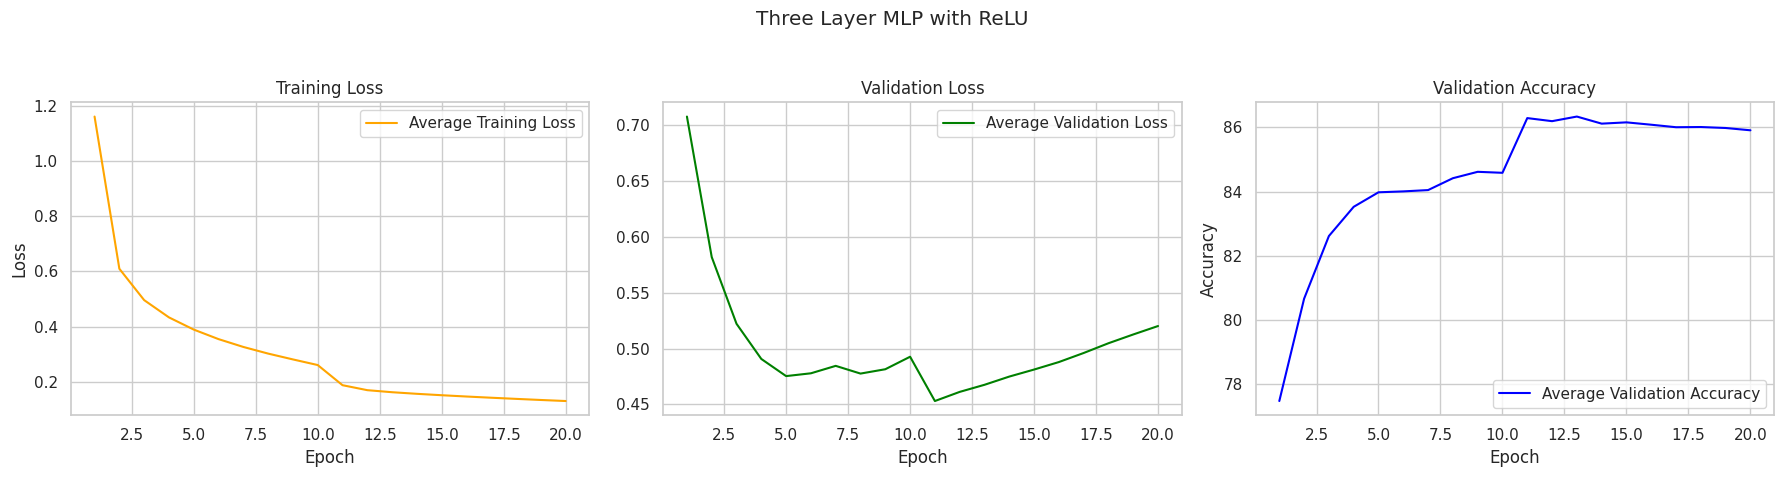

Three Layer MLP with ReLU - Final Average Training Loss: 0.130 | Final Average Validation Loss: 0.520 | Final Average Validation Accuracy: 85.91%

Running cross-validation with LeakyReLU activation function.
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:25<00:00,  4.27s/it]


Train time on cuda: 85.515 seconds
Fold 1 completed. Validation accuracy: 86.20

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:26<00:00,  4.35s/it]


Train time on cuda: 86.934 seconds
Fold 2 completed. Validation accuracy: 85.65

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:25<00:00,  4.28s/it]


Train time on cuda: 85.672 seconds
Fold 3 completed. Validation accuracy: 85.46

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:26<00:00,  4.32s/it]


Train time on cuda: 86.404 seconds
Fold 4 completed. Validation accuracy: 86.11

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:26<00:00,  4.31s/it]


Train time on cuda: 86.282 seconds
Fold 5 completed. Validation accuracy: 85.56



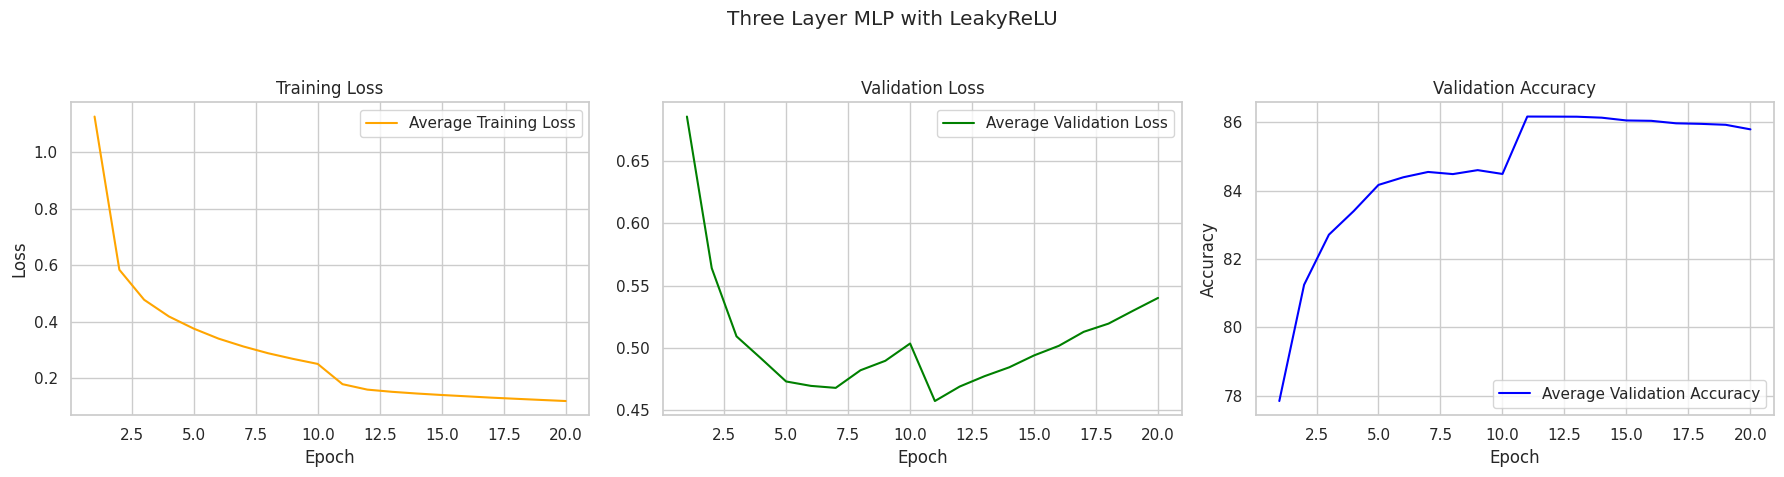

Three Layer MLP with LeakyReLU - Final Average Training Loss: 0.118 | Final Average Validation Loss: 0.540 | Final Average Validation Accuracy: 85.80%

Running cross-validation with ELU activation function.
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:26<00:00,  4.33s/it]


Train time on cuda: 86.577 seconds
Fold 1 completed. Validation accuracy: 86.23

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:27<00:00,  4.39s/it]


Train time on cuda: 87.825 seconds
Fold 2 completed. Validation accuracy: 85.54

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:27<00:00,  4.38s/it]


Train time on cuda: 87.666 seconds
Fold 3 completed. Validation accuracy: 85.91

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:27<00:00,  4.39s/it]


Train time on cuda: 87.743 seconds
Fold 4 completed. Validation accuracy: 86.22

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:27<00:00,  4.37s/it]


Train time on cuda: 87.489 seconds
Fold 5 completed. Validation accuracy: 85.74



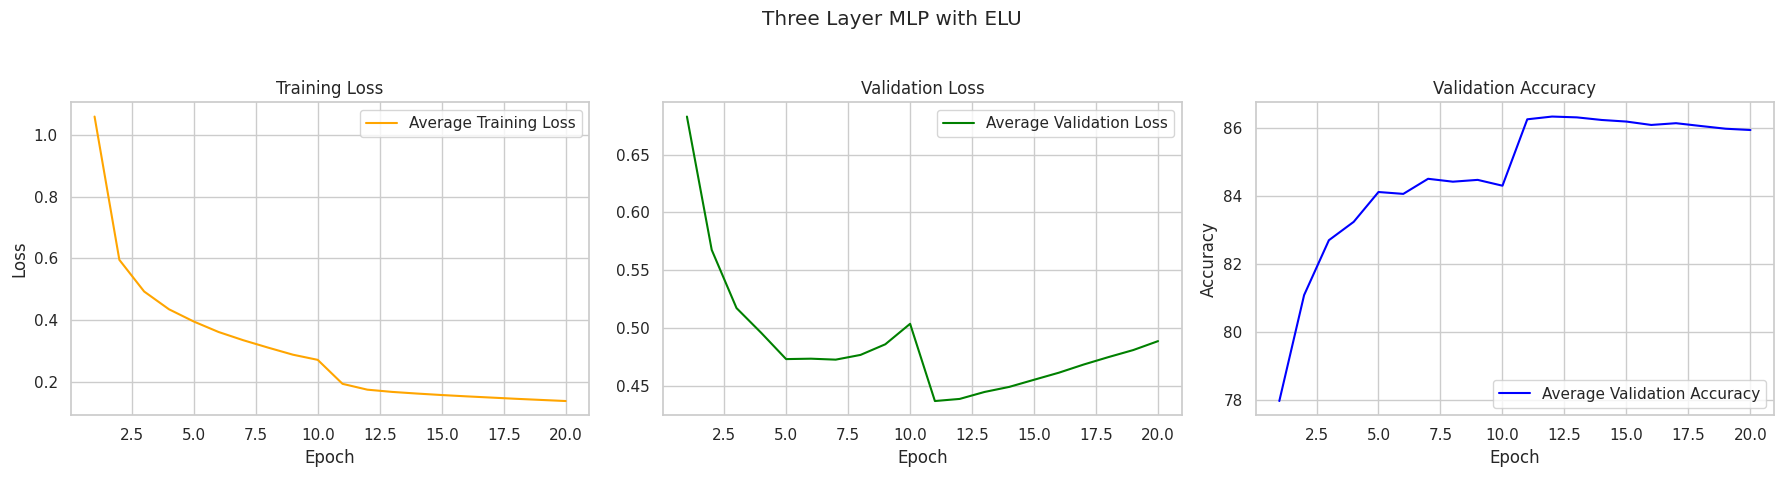

Three Layer MLP with ELU - Final Average Training Loss: 0.139 | Final Average Validation Loss: 0.489 | Final Average Validation Accuracy: 85.93%



In [ ]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001)  # Best optimizer from previous experiment.
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

activation_metrics_list = []

for activation_fn_name, activation_fn in activation_functions.items():
    print(f"Running cross-validation with {activation_fn_name} activation function.")

    # Get a model constructor for the current activation function
    model_constructor = get_model_constructor(activation_fn)

    # Perform stratified k-fold cross-validation
    fold_results = stratified_k_fold_cross_validation(
        dataset=train_dataset,
        n_splits=5,
        model_constructor=model_constructor,
        setup_optimizer_scheduler=setup_optimizer_scheduler,
        epochs=20,
        device=device
    )

    # Plot the results
    plot_fold_results(fold_results, f"One Layer MLP with {activation_fn_name}")

    # Calculate summary statistics
    avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
    avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
    avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

    # Append metrics to metrics list
    activation_metrics_list.append({
        'Activation Function': activation_fn_name,
        'Average Final Training Loss': avg_final_train_loss,
        'Average Final Validation Loss': avg_final_val_loss,
        'Average Final Validation Accuracy': avg_final_val_accuracy
    })


In [ ]:
# Convert the list of dictionaries to a DataFrame
activation_metrics_df = pd.DataFrame(activation_metrics_list)

# Sort the DataFrame by 'Average Final Validation Accuracy'
sorted_activation_metrics_df = activation_metrics_df.sort_values('Average Final Validation Accuracy', ascending=False)

# Display the sorted DataFrame
display(sorted_activation_metrics_df)

Activation Function  Average Final Training Loss  \
2                 ELU                     0.138803   
0                ReLU                     0.130112   
1           LeakyReLU                     0.118257   

   Average Final Validation Loss  Average Final Validation Accuracy  
2                       0.488624                          85.929078  
0                       0.520154                          85.907801  
1                       0.540074                          85.796099

The results show that the ELU activation function performs the best, with an Average Final Validation Accuracy of 85.93, while only slightly better that the other activation functions, ELU will be used in following tests

### Batch Normalisation

Batch normalization will be used to normalize the activations of each layer by adjusting and scaling them based on the mean and variance of the mini-batch during training.

Batch normalisation is implemented by re-defining the MLP model to accept a boolean parameter that will include batch normalisation functions within the model if a condition is met (boolean = True), allowing for ease of use when testing Batch normalisation.

In [ ]:
class one_layer_BN_MLP(nn.Module):
    def __init__(self, num_classes=47, use_bn=False, activation_fn=F.elu):
        super(one_layer_BN_MLP, self).__init__()
        # Save the activation function as an instance variable
        self.activation_fn = activation_fn

        # Define the first hidden layer (input size 784)
        self.hidden1 = nn.Linear(784, 512)
        # batch normalisation condition after first layer
        if use_bn:
            self.bn1 = nn.BatchNorm1d(512)

        # Output layer (output size 47)
        self.output = nn.Linear(512, num_classes)


    def forward(self, x):
        # Flatten the input data (if it's multidimensional)
        x = x.view(x.size(0), -1)

        # Pass the input data through the first hidden layer, optionally apply BN, followed by the activation function
        x = self.hidden1(x)
        if hasattr(self, 'bn1'):
            x = self.bn1(x)
        x = self.activation_fn(x)

        # Pass the data through the output layer
        x = self.output(x)
        return x

Running cross-validation with Batch normalisation on current best model
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:36<00:00,  4.82s/it]


Train time on cuda: 96.344 seconds
Fold 1 completed. Validation accuracy: 85.59

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


Train time on cuda: 95.495 seconds
Fold 2 completed. Validation accuracy: 84.94

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:35<00:00,  4.77s/it]


Train time on cuda: 95.345 seconds
Fold 3 completed. Validation accuracy: 84.28

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


Train time on cuda: 95.791 seconds
Fold 4 completed. Validation accuracy: 85.05

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:34<00:00,  4.74s/it]


Train time on cuda: 94.721 seconds
Fold 5 completed. Validation accuracy: 85.03



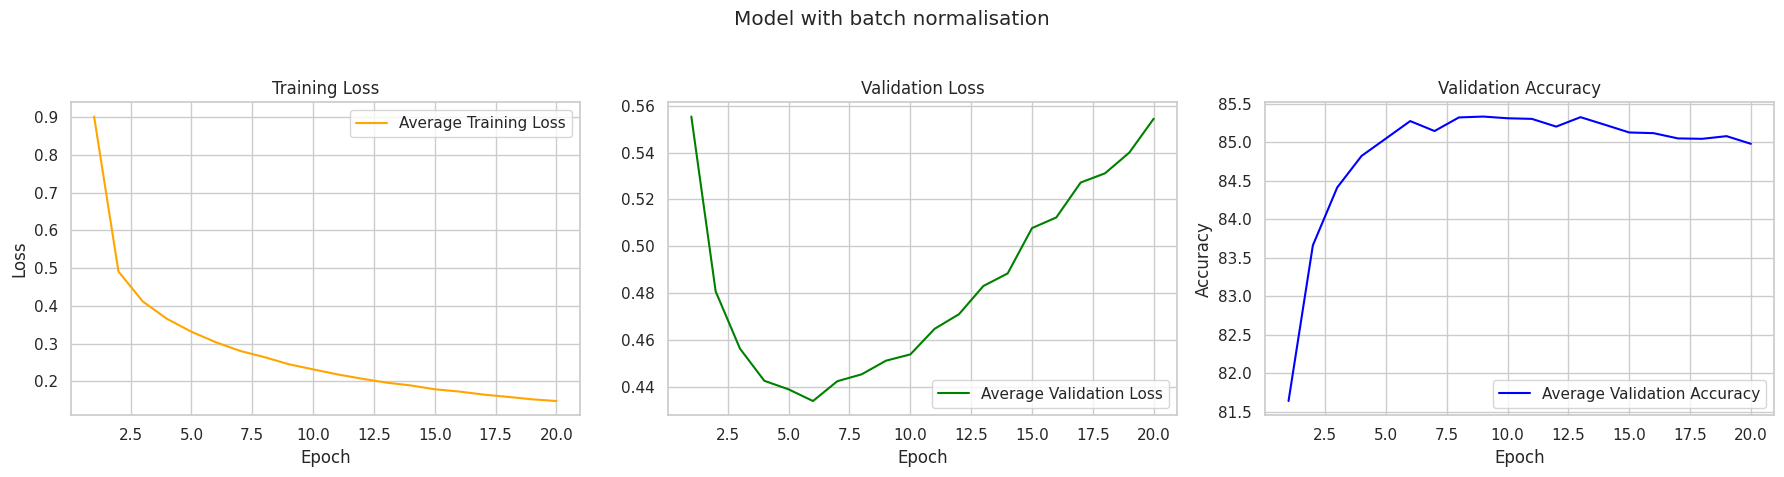

Model with batch normalisation - Final Average Training Loss: 0.148 | Final Average Validation Loss: 0.554 | Final Average Validation Accuracy: 84.98%



In [ ]:
#define the model constructor
def model_constructor():
    return one_layer_BN_MLP(use_bn = True, activation_fn= F.elu) #best performing activation function

def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001)  # Best optimizer from previous experiment.
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

BN_metrics_list = []

print(f"Running cross-validation with Batch normalisation on current best model")

fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device
)

    # Plot the results
plot_fold_results(fold_results, f"Model with batch normalisation")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

# Append metrics to metrics list
BN_metrics_list.append({
    'Average Final Training Loss': avg_final_train_loss,
    'Average Final Validation Loss': avg_final_val_loss,
    'Average Final Validation Accuracy': avg_final_val_accuracy
})

Using Batch normalisation we find a final average Validation accuracy of 84.98%, comparing this to the 85.92 we found without using batch normalisation, we can conclude that batch normalisation does not improve our model performance

### L1 and L2 regularisation

L1 and L2 regularization are used to prevent overfitting by adding penalty terms to the loss function based on the magnitudes of model weights.

L1 regularization encourages sparsity by penalizing the absolute values of weights, while L2 regularization penalizes the squared magnitudes, promoting smoother and more generalized models.

In [ ]:
def model_constructor():
    return one_layerMLP(activation_fn= F.elu) #best performing activation function


### L2 regularisation

L2 regularisation can be implemented by adding weight decay > 0, this is because it is simply an addition of alpha * weight for gradient of every weight, which is exactly what pytorch uses in weight_decay


Running cross-validation with best MLP model using L2 regularisation
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:50<00:00,  5.51s/it]


Train time on cuda: 110.245 seconds
Fold 1 completed. Validation accuracy: 84.69

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:50<00:00,  5.52s/it]


Train time on cuda: 110.332 seconds
Fold 2 completed. Validation accuracy: 84.86

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:36<00:00,  4.80s/it]


Train time on cuda: 96.019 seconds
Fold 3 completed. Validation accuracy: 85.09

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:45<00:00,  5.26s/it]


Train time on cuda: 105.238 seconds
Fold 4 completed. Validation accuracy: 85.16

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:35<00:00,  4.79s/it]


Train time on cuda: 95.818 seconds
Fold 5 completed. Validation accuracy: 84.94



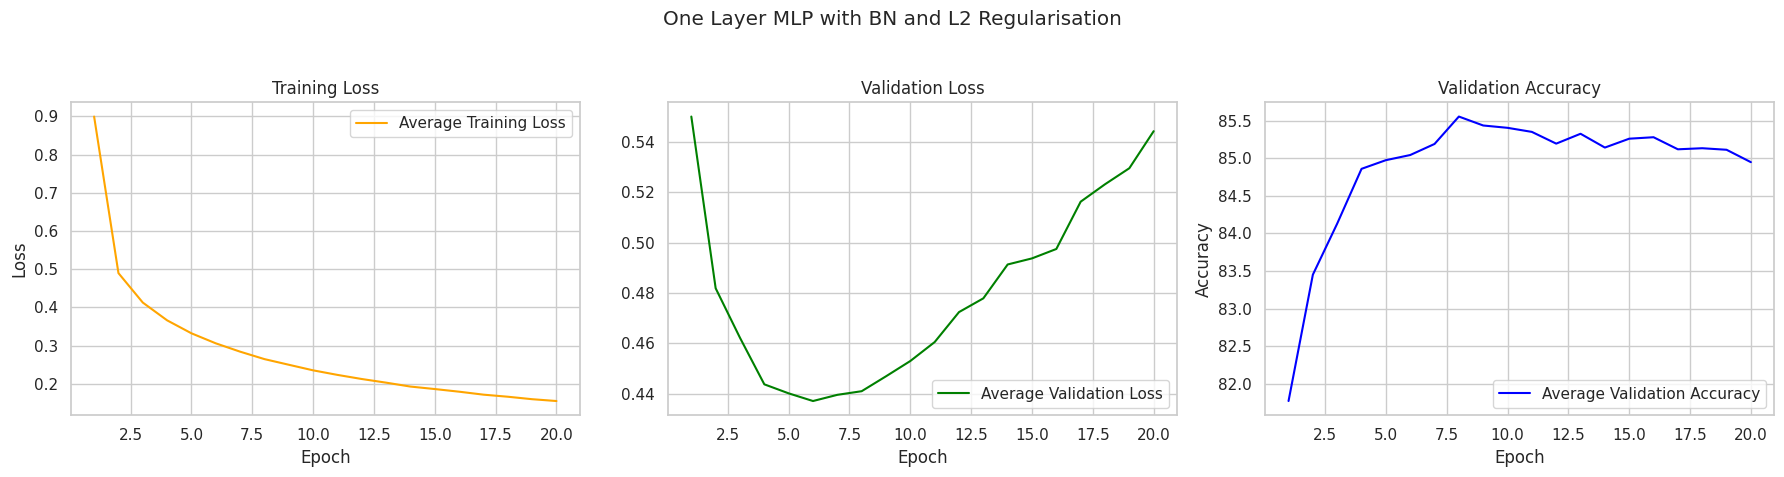

One Layer MLP with BN and L2 Regularisation - Final Average Training Loss: 0.155 | Final Average Validation Loss: 0.544 | Final Average Validation Accuracy: 84.95%

Average final train loss: 0.15499695155637486
Average final validation loss: 0.5441080197102606
Average final validation accuracy: 84.947695035461


In [ ]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=1e-5)  # implementing l2 Regularisation
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler


print(f"Running cross-validation with best MLP model using L2 regularisation")

fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device
)

    # Plot the results
plot_fold_results(fold_results, f"One Layer MLP with BN and L2 Regularisation")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

print("Average final train loss:", avg_final_train_loss)
print("Average final validation loss:", avg_final_val_loss)
print("Average final validation accuracy:", avg_final_val_accuracy)


 Here we see no improvement in performance using L2 regularisation, since the final average validation accuracy drops to 84.95.

### L1 regularisation

L1 regularisation can be implemented by computing the L1 norm of the model parameters and adding it to the original loss function with a scaling factor (lambda_l1) to control the regularization strength. This is typically achieved by summing the absolute values of each parameter in the model and then adding this term to the original loss function.

To do this, we must re-define the train and validate function and stratified k-fold function to compute L1 regularisation and handle the cross validation

In [ ]:
def train_and_validate_model_with_l1(train_loader, val_loader, model, optimizer, scheduler, epochs, device, lambda_l1):
    """
    Trains and validates the model using the given data loaders, optimizer, scheduler, and number of epochs, including L1 regularization.

    Parameters:
    - train_loader: DataLoader for the training data.
    - val_loader: DataLoader for the validation data.
    - model: The neural network model to train.
    - optimizer: The optimizer to use for training.
    - scheduler: The scheduler to use for training.
    - epochs: Number of epochs to train for.
    - device: The device (CPU or GPU) to use for training and evaluation.
    - lambda_l1: L1 regularization strength.

    Returns:
    - A tuple containing the average training loss, average validation loss, and average validation accuracy.
    """
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()
        train_loss = 0

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)

            # Compute the L1 loss (regularization) term
            l1_norm = sum(p.abs().sum() for p in model.parameters())

            # Combine the cross-entropy loss and L1 regularization
            loss += lambda_l1 * l1_norm

            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        scheduler.step()

        model.eval()
        val_loss = 0
        correct = 0
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = F.cross_entropy(y_pred, y)

                val_loss += loss.item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)

    return train_losses, val_losses, val_accuracies

In [ ]:
def stratified_k_fold_cross_validation_with_l1(dataset, n_splits, model_constructor, setup_optimizer_scheduler, epochs, device, l1):
    """
    Performs stratified k-fold cross-validation for the given dataset, model, and includes L1 regularization.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - setup_optimizer_scheduler: Function that takes a model's parameters and returns a tuple of optimizer and scheduler.
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    - l1: L1 regularization strength.
    """
    features = dataset.tensors[0].numpy()
    labels = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        # Timer start
        fold_start_time = timer()

        # Splitting the dataset into training and validation subsets for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Creating data loaders
        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        # Initializing the model, optimizer, and scheduler for the current fold
        model = model_constructor().to(device)
        optimizer, scheduler = setup_optimizer_scheduler(model.parameters())

        # Training and validating the model with L1 regularization
        train_losses, val_losses, val_accuracies = train_and_validate_model_with_l1(
            train_loader, val_loader, model, optimizer, scheduler, epochs, device, l1
        )

        # Timer end
        fold_end_time = timer()

        # Calculating fold training time
        fold_train_time = fold_end_time - fold_start_time

        # Collecting results for this fold
        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'train_time': fold_train_time
        })

        print(f"Fold {fold} completed. Validation accuracy: {val_accuracies[-1]:.2f}\n")

    return fold_results

Running cross-validation with best model using L1 regularisation
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [02:05<00:00,  6.30s/it]


Fold 1 completed. Validation accuracy: 61.95

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [02:07<00:00,  6.39s/it]


Fold 2 completed. Validation accuracy: 61.90

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:57<00:00,  5.87s/it]


Fold 3 completed. Validation accuracy: 61.31

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:58<00:00,  5.92s/it]


Fold 4 completed. Validation accuracy: 60.91

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:58<00:00,  5.91s/it]


Fold 5 completed. Validation accuracy: 61.77



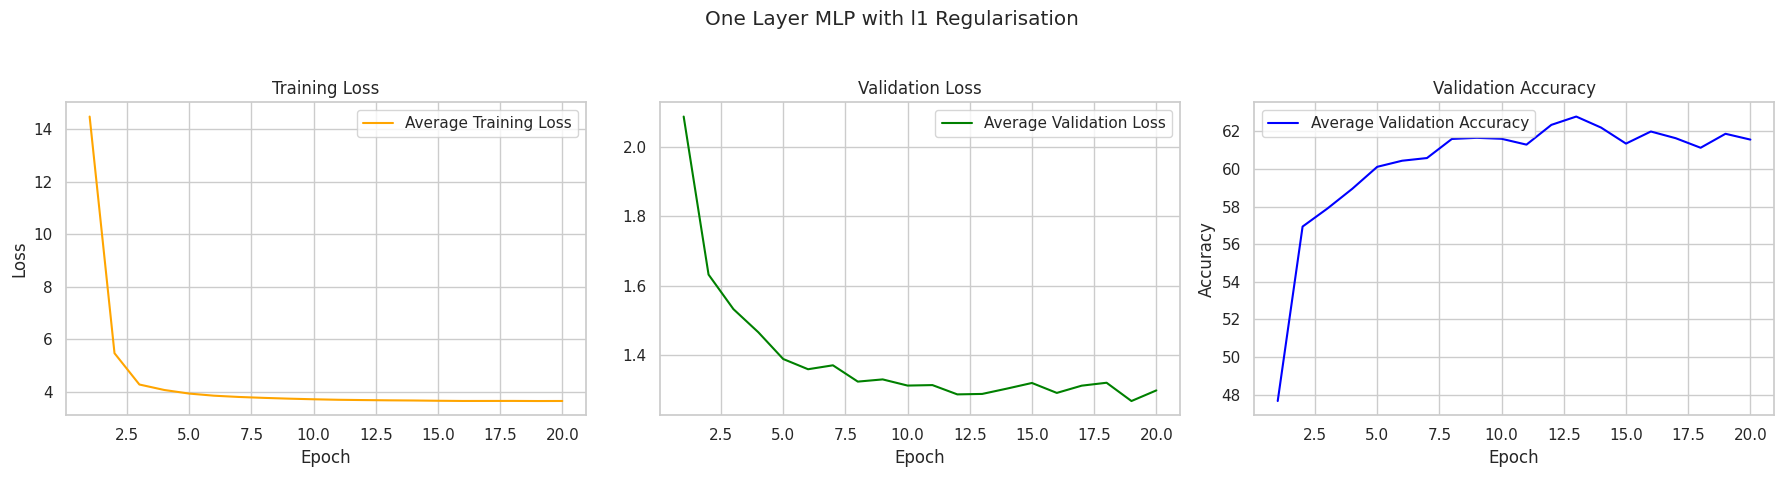

One Layer MLP with l1 Regularisation - Final Average Training Loss: 3.657 | Final Average Validation Loss: 1.298 | Final Average Validation Accuracy: 61.57%



In [ ]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001, weight_decay=1e-5)  # We will continue to use l2 Regularisation
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

metric_list = []

print(f"Running cross-validation with best model using L1 regularisation")

fold_results = stratified_k_fold_cross_validation_with_l1(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device,
    l1 = 0.01
)

    # Plot the results
plot_fold_results(fold_results, f"One Layer MLP with l1 Regularisation")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

# Append metrics to metrics list
metric_list.append({
    'Average Final Training Loss': avg_final_train_loss,
    'Average Final Validation Loss': avg_final_val_loss,
    'Average Final Validation Accuracy': avg_final_val_accuracy
})

Here we see that using L1 regularisation actually reduces the performance of our model, and we therefore won't use it.

For further notes, see:

from : https://discuss.pytorch.org/t/how-is-your-experience-of-using-l1-regularization/153565/2

L2 pushes large parameters strongly towards zero, but pushes small
parameters only weakly, whereas L1 pushes all parameters with the
same strength, regardless of their size. So, according to my intuition,
L2 gives more “breathing room” to small (and moderate) parameters,
while pushing back on abnormally large parameters. On the other hand,
L1 might be preventing small and moderate parameters from reaching
their riate values.iate v

This could explain the poor performance witmodel valuesl

**Because there was no notable performance improvement using either L1 or L2 regularisation, we will incorporate these into our models**

### Dropout


During training, randomly zeroes some of the elements of the input tensor with probability p.

The zeroed elements are chosen independently for each forward call and are sampled from a Bernoulli distribution.

Each channel will be zeroed out independently on every forward call.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons as described in the paper Improving neural networks by preventing co-adaptation of feature detectors

https://arxiv.org/abs/1207.0580

from : https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

In [ ]:
class one_layer_dropout_MLP(nn.Module):
    def __init__(self, num_classes=47, activation_fn=F.elu):
        super(one_layer_dropout_MLP, self).__init__()
        # Save the activation function as an instance variable
        self.activation_fn = activation_fn

        # Define the first hidden layer (input size 784)
        self.hidden1 = nn.Linear(784, 512)
        # Batch normalization after the first layer

        # Output layer (output size 47)
        self.output = nn.Linear(512, num_classes)

        # Dropout layer with p=0.3
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        # Flatten the input data (if it's multidimensional)
        x = x.view(x.size(0), -1)

        # Pass the input data through the first hidden layer, this time apply dropout
        x = self.hidden1(x)
        x = self.activation_fn(x)
        x = self.dropout(x)

        # Pass the data through the output layer
        x = self.output(x)
        return x


In [ ]:
def model_constructor():
    return one_layer_dropout_MLP() # Best performing activation function


Running cross-validation with best model using dropout
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:36<00:00,  4.84s/it]


Train time on cuda: 96.716 seconds
Fold 1 completed. Validation accuracy: 85.10

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:37<00:00,  4.85s/it]


Train time on cuda: 97.035 seconds
Fold 2 completed. Validation accuracy: 84.53

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:22<00:00,  4.15s/it]


Train time on cuda: 82.926 seconds
Fold 3 completed. Validation accuracy: 84.76

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:36<00:00,  4.81s/it]


Train time on cuda: 96.313 seconds
Fold 4 completed. Validation accuracy: 84.78

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:21<00:00,  4.07s/it]


Train time on cuda: 81.332 seconds
Fold 5 completed. Validation accuracy: 84.69



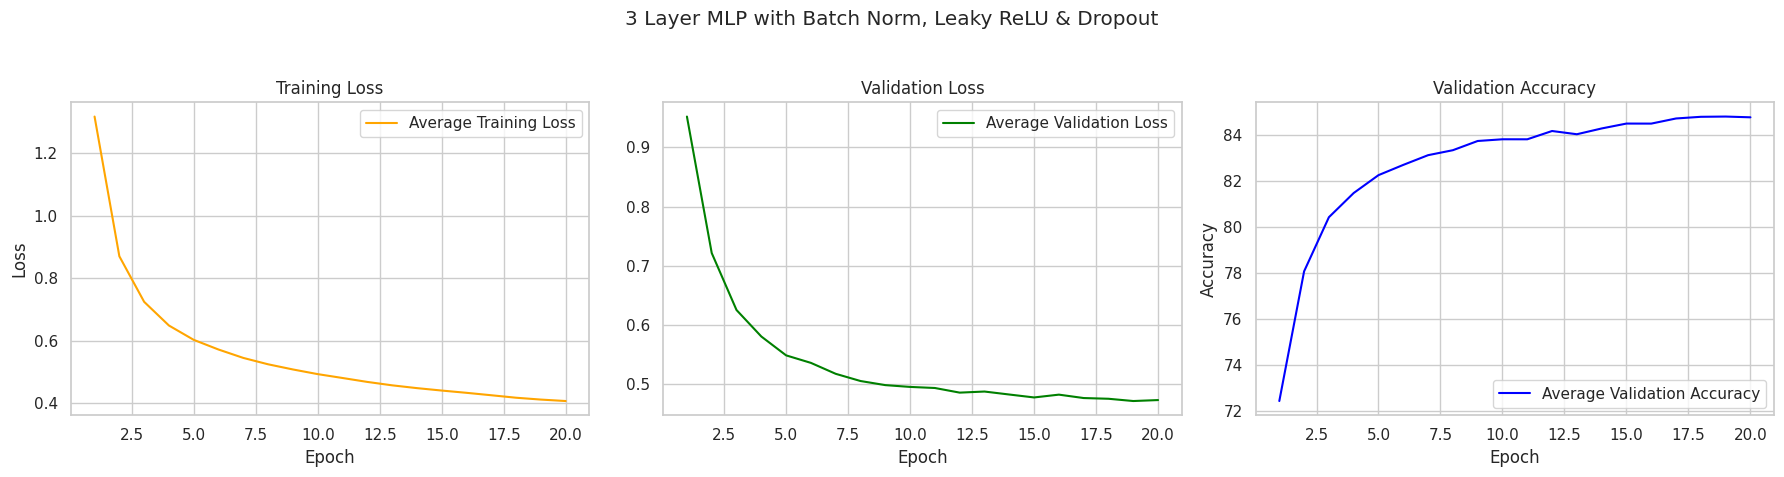

3 Layer MLP with Batch Norm, Leaky ReLU & Dropout - Final Average Training Loss: 0.407 | Final Average Validation Loss: 0.474 | Final Average Validation Accuracy: 84.77%



In [ ]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001,)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

metric_list = []

print(f"Running cross-validation with best model using dropout")

fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device
)

    # Plot the results
plot_fold_results(fold_results, f"One Layer MLP with Dropout")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

# Append metrics to metrics list
metric_list.append({
    'Average Final Training Loss': avg_final_train_loss,
    'Average Final Validation Loss': avg_final_val_loss,
    'Average Final Validation Accuracy': avg_final_val_accuracy
})

**Comparing the models we see that using dropout negatively impacts model performance. With dropout, we see a final validation accuracy of 84.77%, however, without dropout we see a performance of 85.93%**

Now that we have tested all hyperparameters, we can train the model on the full training dataset and assess its performance metrics on the test dataset.

### Training our best performing MLP model

In [ ]:
# Best Model
best_mlp_model = one_layerMLP(activation_fn = F.elu).to(device) #best performing mode, no droput,
optimizer = torch.optim.Adam(best_mlp_model.parameters(), lr=0.001)  # No Regularization, Best LR
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.

Epoch: 1 |Train Loss: 1.4262172153632566 | Test Loss: 1.1149090093535345 | Test Accuracy: 68.77%
Epoch: 2 |Train Loss: 0.9470667402129368 | Test Loss: 0.8584137365624711 | Test Accuracy: 75.44%
Epoch: 3 |Train Loss: 0.7367562867397637 | Test Loss: 0.7069407395414404 | Test Accuracy: 79.11%
Epoch: 4 |Train Loss: 0.6187972000281735 | Test Loss: 0.6322341690192351 | Test Accuracy: 80.75%
Epoch: 5 |Train Loss: 0.5481683516124795 | Test Loss: 0.5840664924802007 | Test Accuracy: 82.04%
Epoch: 6 |Train Loss: 0.500562268010092 | Test Loss: 0.5493070120747024 | Test Accuracy: 82.88%
Epoch: 7 |Train Loss: 0.4655270506353939 | Test Loss: 0.5288523959146963 | Test Accuracy: 83.16%
Epoch: 8 |Train Loss: 0.43686294285959787 | Test Loss: 0.5118241970603531 | Test Accuracy: 83.70%
Epoch: 9 |Train Loss: 0.41347606338526866 | Test Loss: 0.5022154385979111 | Test Accuracy: 83.88%
Epoch: 10 |Train Loss: 0.39160565890338084 | Test Loss: 0.49262823124189636 | Test Accuracy: 84.38%
Epoch: 11 |Train Loss: 0.3

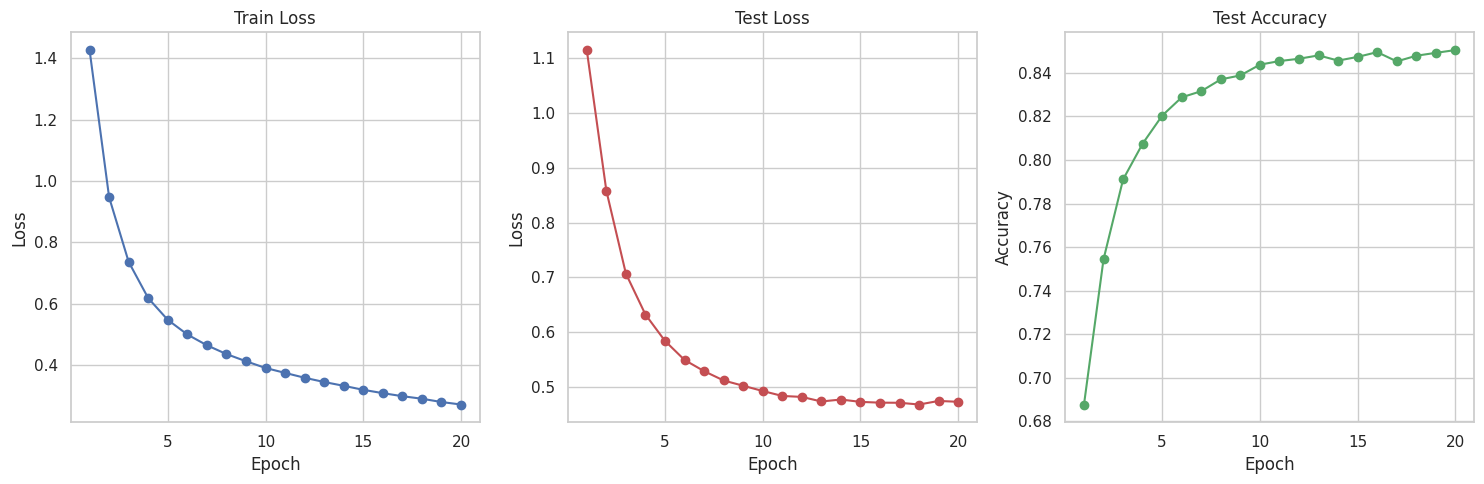

In [ ]:
# Set the number of epochs
num_epochs = 20

# Record our model loss through training.
train_losses = []
test_losses = []
test_accuracies = []

# Training loop
for epoch in range(num_epochs):
    # Set model to train mode
    best_mlp_model.train()

    # Initialize variables to track loss and accuracy
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training loop
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = best_mlp_model(X)
        loss = F.cross_entropy(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Calculate average training loss across the data
    avg_train_loss = total_loss / len(train_loader)

    # Append to our recording
    train_losses.append(avg_train_loss)

    # Set model to evaluation mode
    best_mlp_model.eval()

    # Initialize variables to track loss and accuracy for testing
    test_loss = 0.0
    correct = 0
    total = 0

    # Initialize variables to track evaluation metrics
    evaluation_metrics = {}

    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Test loop
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = best_mlp_model(X_test)
            loss = F.cross_entropy(outputs, y_test)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()

            # Append true labels and predicted labels
            true_labels.extend(y_test.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Calculate average testing loss across the data
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    test_accuracies.append(correct / total)

    print(f"Epoch: {epoch+1} |Train Loss: {avg_train_loss} | Test Loss: {avg_test_loss} | Test Accuracy: {(correct / total) * 100:.2f}%")


# Plot all graphs on separate subfigures
plt.figure(figsize=(15, 5))

# Plot train losses
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='b')
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot test losses
plt.subplot(1, 3, 2)
plt.plot(epochs, test_losses, marker='o', linestyle='-', color='r')
plt.title('Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

# Plot test accuracies
plt.subplot(1, 3, 3)
plt.plot(epochs, test_accuracies, marker='o', linestyle='-', color='g')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

### Evaluating our Best MLP

Now that we've trained our best model, we can use it to make predictions on the test data:

In [ ]:
# from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Evaluate model on test set
best_mlp_model.eval()  # Set model to evaluation mode
true_labels = []
best_mlp_preds = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = best_mlp_model(X_test)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(y_test.cpu().numpy())
        best_mlp_preds.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for compatibility with scikit-learn metrics
true_labels = np.array(true_labels)
best_mlp_preds = np.array(best_mlp_preds)

final_model_metrics = []

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, best_mlp_preds)
precision = precision_score(true_labels, best_mlp_preds, average='macro')
recall = recall_score(true_labels, best_mlp_preds, average='macro')
f1 = f1_score(true_labels, best_mlp_preds, average='macro')

final_model_metrics.append({'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1})

# Print all evaluation results
print("Best MLP Results:")
print('Accuracy: %.4f' % accuracy)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 Score: %.4f' % f1)




Best MLP Results:
Accuracy: 0.8505
Precision: 0.8530
Recall: 0.8505
F1 Score: 0.8506


Here, we can print the top 6 (first six?) images and their respective truth labels:

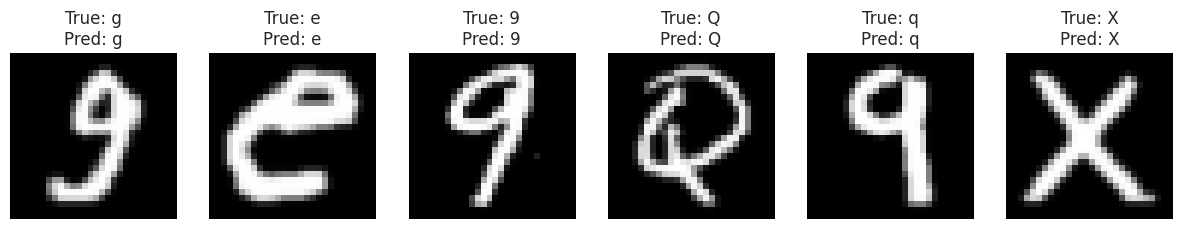

In [ ]:
def plot_top_samples(test_loader, label_char_mapping, predicted_labels):
    plt.figure(figsize=(15, 3))
    count = 0
    for images, true_labels in test_loader:
        for image, true_label, pred_label in zip(images, true_labels, predicted_labels):
            count += 1
            plt.subplot(1, 6, count)
            # Reshape the image to 2D (28, 28)
            image = image.squeeze().numpy()  # Assuming image is a torch tensor
            plt.imshow(image, cmap='gray')
            # Use label_char_mapping to convert indices to characters
            true_char = label_char_mapping.get(int(true_label), '?')  # Convert and handle missing with '?'
            pred_char = label_char_mapping.get(int(pred_label), '?')  # Convert and handle missing with '?'
            plt.title(f'True: {true_char}\nPred: {pred_char}')
            plt.axis('off')
            if count == 6:
                break
        if count == 6:
            break
    plt.show()


plot_top_samples(test_loader, label_char_mapping, best_mlp_preds)

We can also create a confusion matrix to clearly show where the model is making mistakes:

In [ ]:
mapping_file_path = 'emnist-balanced-mapping.txt'
label_char_mapping = load_label_mapping(mapping_file_path)

In [ ]:
def plot_confusion_matrix(labels, preds, label_char_mapping=label_char_mapping, num_classes=47):
    """
    Plot confusion matrix using matplotlib and seaborn with custom labels from EMNIST.
    """
    cm = confusion_matrix(labels, preds, labels=range(num_classes))
    plt.figure(figsize=(20, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[label_char_mapping[i] for i in range(num_classes)],
                yticklabels=[label_char_mapping[i] for i in range(num_classes)])
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

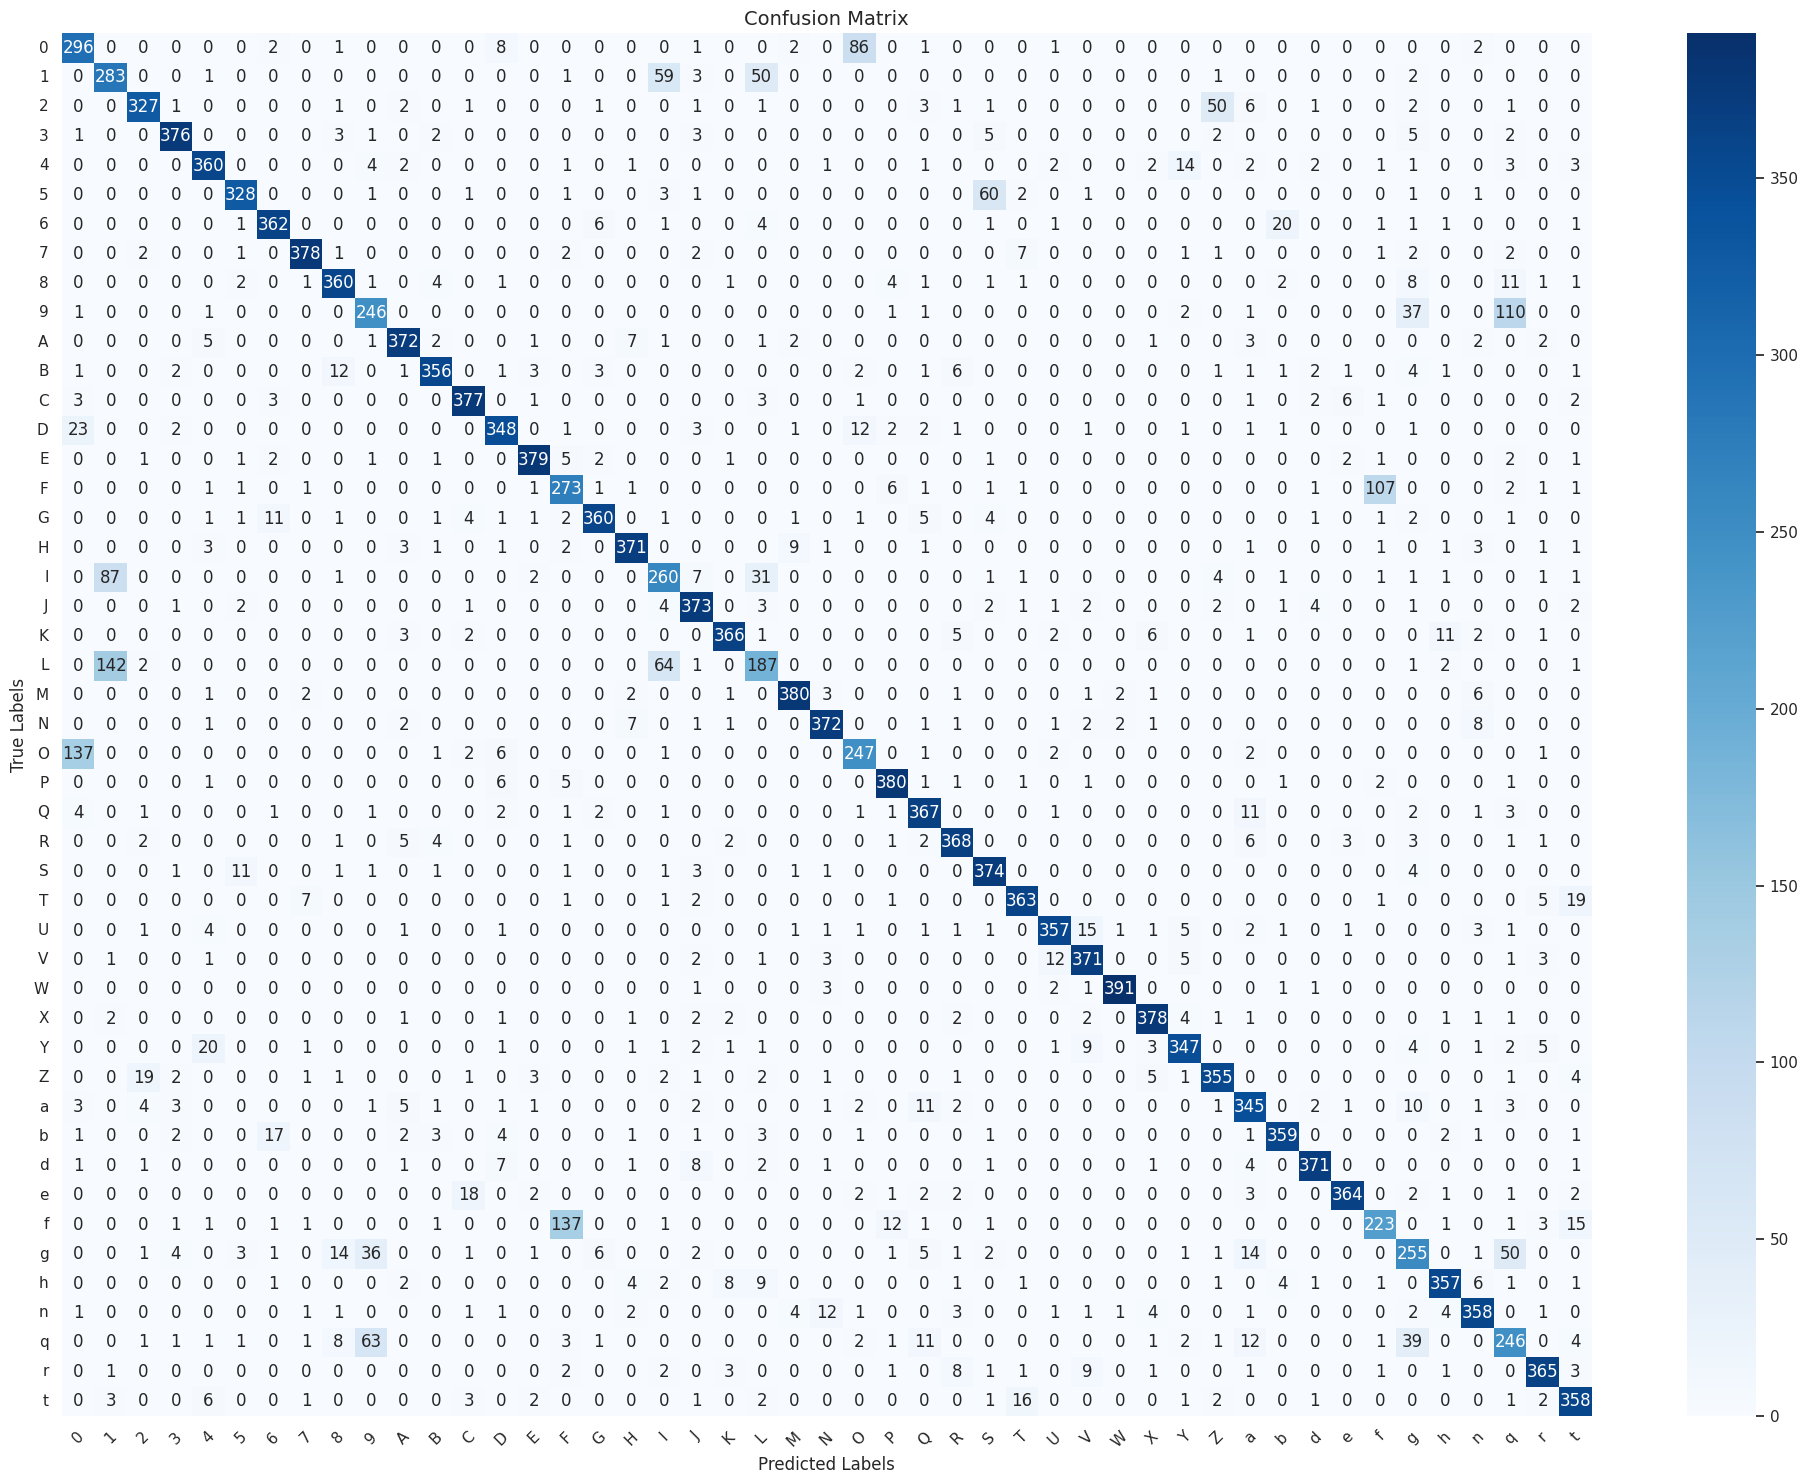

In [ ]:
plot_confusion_matrix(true_labels, best_mlp_preds)

## Convolutional Neural Network

First we need to re-initialise the train_and_validate_model function and the stratified_k_fold_cross_validation function, as they have been changed throughout the development of the MLP model


In [ ]:
def train_and_validate_model(train_loader, val_loader, model, optimizer, epochs, device=device):
    """
    Trains and validates the model for a given train/val set, implements early stopping (default trigger - no improvement after 5 epochs).

    Parameters:
    - train_loader: DataLoader for the training data.
    - val_loader: DataLoader for the validation data.
    - model: The neural network model to train.
    - optimizer: The optimizer to use for training.
    - epochs: Number of epochs to train for.
    - device: The device (CPU or GPU) to use for training and evaluation.

    Returns:
    - A tuple containing the average training loss, average validation loss, and average validation accuracy.
    """

    model.to(device)
    # Track metrics
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Early stopping setup
    estop_tolerance = 5
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()  # Set model to training mode
        train_loss = 0

        # Training loop
        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Calculate average losses
        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += F.cross_entropy(y_pred, y).item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)

        # Early Stopping Check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= estop_tolerance:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

        # print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {accuracy:.2f}%")

    return train_losses, val_losses, val_accuracies


In [ ]:

def stratified_k_fold_cross_validation(dataset, n_splits, model_constructor, optimizer_constructor, epochs=20, device=device):
    """
    Performs stratified k-fold cross-validation for the given dataset and model.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - optimizer_constructor: Function that takes a model's parameters and returns an optimizer.
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    """
    features = dataset.tensors[0].numpy()
    labels = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        # Start timing here
        fold_start_time = timer()

        # Splitting the dataset into training and validation for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Creating data loaders for the current fold
        train_loader = DataLoader(train_subset, batch_size=512, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=512, shuffle=False)

        # Initializing the model, optimizer and early stopping tollerance, for the current fold
        model = model_constructor().to(device)
        optimizer = optimizer_constructor(model.parameters())

        # Training and validation for the current fold
        train_losses, val_losses, val_accuracies = train_and_validate_model(
            train_loader, val_loader, model, optimizer, epochs, device
        )

         # End timing here
        fold_end_time = timer()

        fold_train_time = fold_end_time - fold_start_time

        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'train_time': fold_train_time
        })

        print_train_time(fold_start_time, fold_end_time, device)
        print(f"Using device: {device}")
        print(f"Fold {fold} completed. Validation accuracy: {val_accuracies[-1]:.2f}%\n")

    return fold_results


### Defining a Baseline CNN model

To find the best performing baseline model, we want to test different amounts of hidden layers and assess the performance.

The CNN models differ from the MLP models as they include Convolutional rather than Linear Layers, and make use of Max pooling to Apply a 2D max pooling over an input signal composed of several input planes

We will create CNN models with 2,3 and 4 hidden layers and assess performance

First we'll define a Two Layer CNN model. For each convolutional layer of our CNN, we use the format of:

* Covolution
* Batch Noramlisation (if used)
* Activation Function
* Max Pooling



In [ ]:
class TwoLayerCNN(nn.Module):
    def __init__(self, num_classes=47, use_dropout=True, activation_fn=F.relu):
        super(TwoLayerCNN, self).__init__()

        self.activation_fn = activation_fn

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channels, output channels, kernel size
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (32, 14, 14)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (64, 7, 7)

        # Define the output layer
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()
        self.fc = nn.Linear(64 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.pool1(self.activation_fn(self.conv1(x)))
        x = self.pool2(self.activation_fn(self.conv2(x)))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

Training the two layer model

In [ ]:
def model_constructor():
    return TwoLayerCNN(activation_fn = F.relu)

def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01)

two_layer_cnn_fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    optimizer_constructor=optimizer_constructor,
    epochs=20,
    device=device
)

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:46<00:00,  5.31s/it]


Train time on cuda: 106.134 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 78.40%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:44<00:00,  5.21s/it]


Train time on cuda: 104.139 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 78.57%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:42<00:00,  5.15s/it]


Train time on cuda: 103.007 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 79.08%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:41<00:00,  5.10s/it]


Train time on cuda: 101.939 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 79.42%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:50<00:00,  5.53s/it]

Train time on cuda: 110.548 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 78.64%



Defining the Three layer model

In [ ]:
class ThreeLayerCNN(nn.Module):
    def __init__(self, num_classes=47, use_dropout=True, activation_fn=F.relu):
        super(ThreeLayerCNN, self).__init__()
        self.activation_fn = activation_fn

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input channels, output channels, kernel size
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (32, 14, 14)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (64, 7, 7)

        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (128, 3, 3)

        # Define the output layer
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()
        self.fc = nn.Linear(128 * 3 * 3, num_classes)

    def forward(self, x):
        x = self.pool1(self.activation_fn(self.conv1(x)))
        x = self.pool2(self.activation_fn(self.conv2(x)))
        x = self.pool3(self.activation_fn(self.conv3(x)))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

Training the three layer model

In [ ]:
# Let's train out first neural network on the training dataset using k-fold cross val:

def model_constructor():
    return ThreeLayerCNN(activation_fn = F.relu)

def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01)

three_layer_cnn_fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    optimizer_constructor=optimizer_constructor,
    epochs=20,
    device=device
)

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [02:01<00:00,  6.10s/it]


Train time on cuda: 121.931 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 81.77%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [02:04<00:00,  6.25s/it]


Train time on cuda: 124.987 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 80.35%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [02:06<00:00,  6.30s/it]


Train time on cuda: 126.055 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 80.68%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [02:08<00:00,  6.41s/it]


Train time on cuda: 128.155 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 81.86%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [02:01<00:00,  6.05s/it]

Train time on cuda: 121.032 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 81.56%



Defining our four layer CNN

In [ ]:
class FourLayerCNN(nn.Module):
    def __init__(self, num_classes=47, use_dropout=True, activation_fn=F.relu):
        super(FourLayerCNN, self).__init__()
        self.activation_fn = activation_fn

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input size (1, 28, 28)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (32, 14, 14)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (64, 7, 7)

        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Define the fourth convolutional layer
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (128, 3, 3)

        # Define the output layer
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()
        self.fc = nn.Linear(128 * 3 * 3, num_classes)

    def forward(self, x):
        x = self.pool1(self.activation_fn((self.conv1(x))))
        x = self.pool2(self.activation_fn(self.conv2(x)))
        x = self.activation_fn(self.conv3(x))
        x = self.pool4(self.activation_fn(self.conv4(x)))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

Training the 4 layer CNN model

In [ ]:
# use model constructor function so that this specific model can be called by other functions
def model_constructor():
    return FourLayerCNN(activation_fn = F.relu)

#define baseline optimizer
def optimizer_constructor(model_params):
    return torch.optim.SGD(model_params, lr=0.01)

# pass the model through stratified_k_fold_cross_validation function
four_layer_cnn_fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,  # Your dataset
    n_splits=5,  # Number of folds
    model_constructor=model_constructor,
    optimizer_constructor=optimizer_constructor,
    epochs=20,
    device=device
)

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [02:28<00:00,  7.42s/it]


Train time on cuda: 148.376 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 81.29%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [02:19<00:00,  6.97s/it]


Train time on cuda: 139.490 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 82.30%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [02:16<00:00,  6.82s/it]


Train time on cuda: 136.326 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 81.86%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [02:18<00:00,  6.92s/it]


Train time on cuda: 138.479 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 81.72%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [02:10<00:00,  6.54s/it]

Train time on cuda: 130.733 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 81.77%



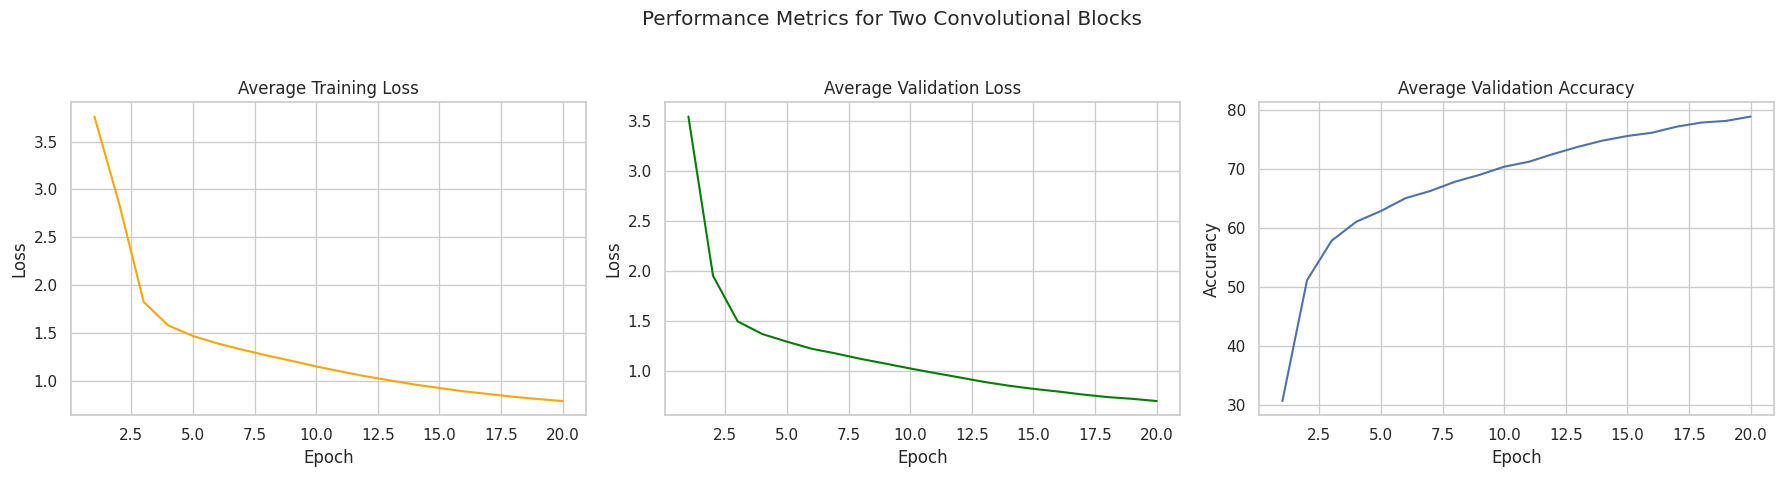

Final metrics for Two Convolutional Blocks: | Average Train Loss: 0.7932003823377318 | Average Validation Loss: 0.7030182377497356 | Average Validation Accuracy: 78.8209219858156



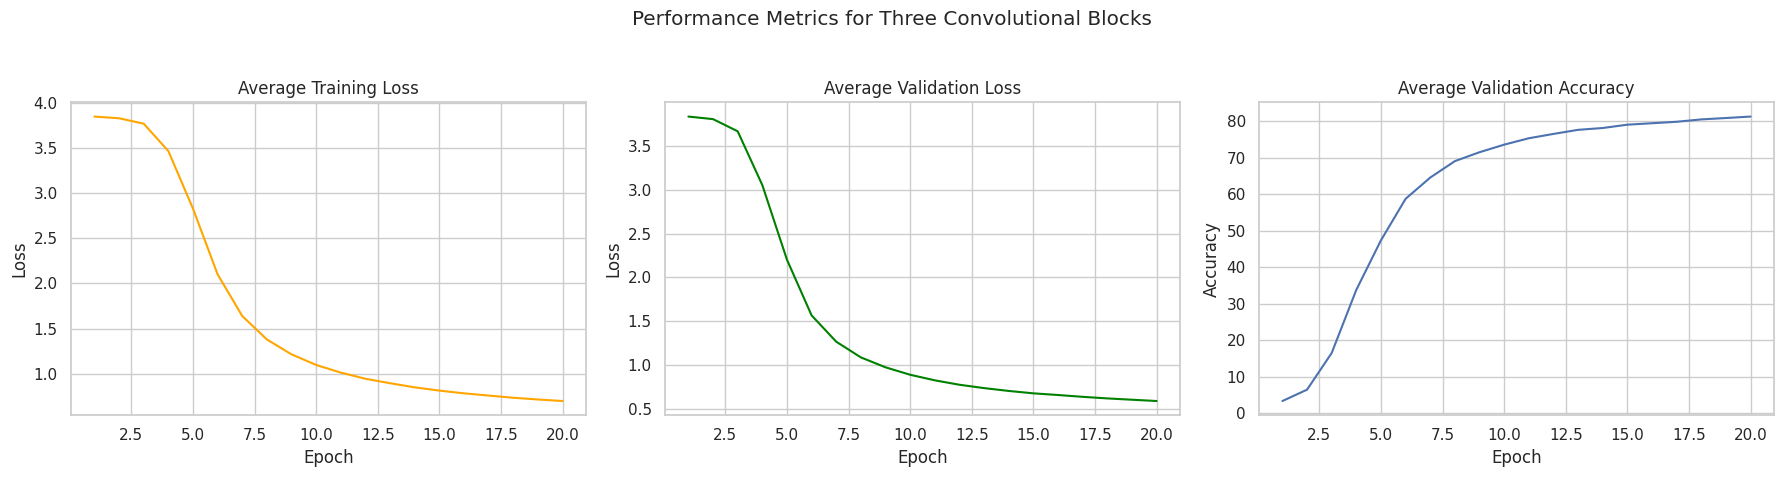

Final metrics for Three Convolutional Blocks: | Average Train Loss: 0.7008377822105494 | Average Validation Loss: 0.589760213163164 | Average Validation Accuracy: 81.24468085106382



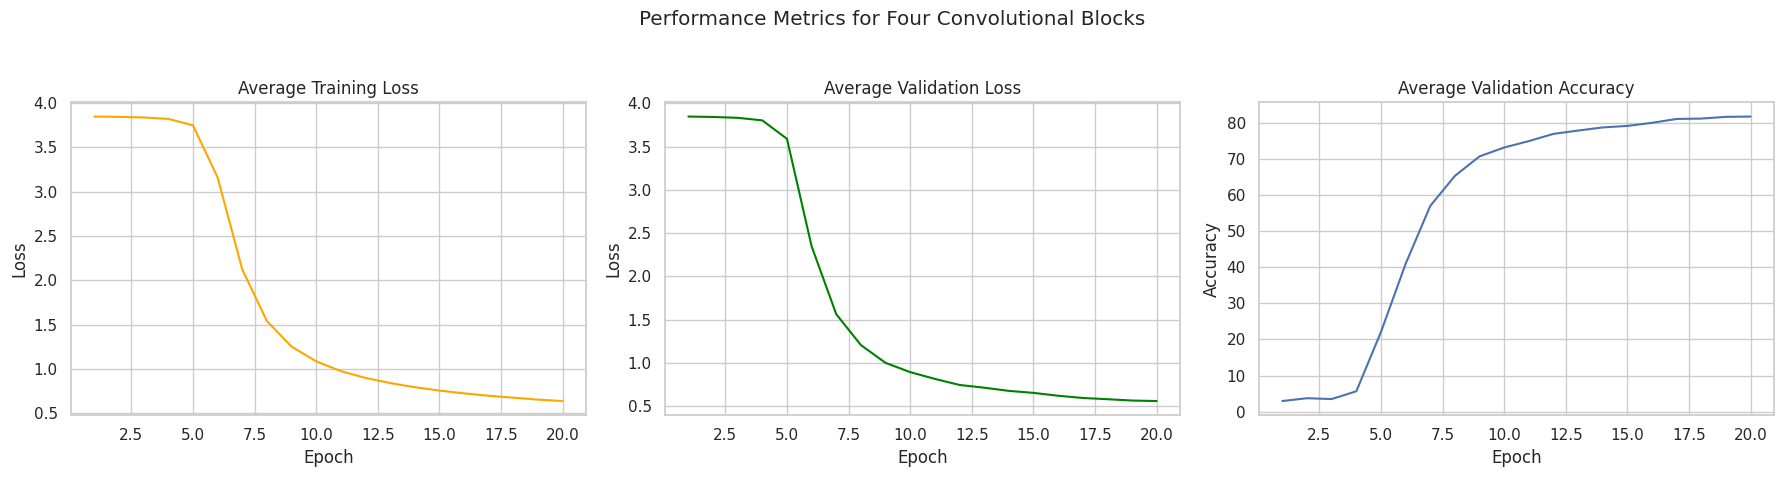

Final metrics for Four Convolutional Blocks: | Average Train Loss: 0.6386655289574531 | Average Validation Loss: 0.5595608382754855 | Average Validation Accuracy: 81.7872340425532



In [ ]:
# List of results for different numbers of layers
fold_results_list = [
    two_layer_cnn_fold_results,
    three_layer_cnn_fold_results,
    four_layer_cnn_fold_results
]

layer_names = ['Two Convolutional Blocks', 'Three Convolutional Blocks', 'Four Convolutional Blocks']

# Loop over each set of fold results
for fold_results, name in zip(fold_results_list, layer_names):
    # Calculating the average metrics
    avg_train_loss = np.mean([results['train_losses'] for results in fold_results], axis=0)
    avg_val_loss = np.mean([results['val_losses'] for results in fold_results], axis=0)
    avg_val_accuracy = np.mean([results['val_accuracies'] for results in fold_results], axis=0)

    epochs = range(1, len(avg_val_accuracy) + 1)

    # Plotting
    plt.figure(figsize=(18, 5))
    plt.suptitle(f'Performance Metrics for {name}')

    # Plot Training Loss
    plt.subplot(1, 3, 1)
    plt.plot(epochs, avg_train_loss, label='Average Training Loss', color='orange')
    plt.title('Average Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Validation Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, avg_val_loss, label='Average Validation Loss', color='green')
    plt.title('Average Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    # Plot Validation Accuracy
    plt.subplot(1, 3, 3)
    plt.plot(epochs, avg_val_accuracy, label='Average Validation Accuracy')
    plt.title('Average Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
    plt.show()

    print(f"Final metrics for {name}: | Average Train Loss: {avg_train_loss[-1]} | Average Validation Loss: {avg_val_loss[-1]} | Average Validation Accuracy: {avg_val_accuracy[-1]}\n")


**When assessing the baseline performance metrics, we find that the four layer CNN model performs the best, this baseline model will be used throughout the system**

### Learning Rates and Optimizers

Here we will test the three different optimizers listed below against different learning rates in order to find the best performing optimizer

three optimizers will be tested -

SGD - stochastic gradient descent, it iteratively updates model parameters using a randomly selected subset of training data, making it computationally efficient and suitable for large datasets.

ADAM - Adaptive Moment Estimation, it dynamically adjusts the learning rate for each parameter based on the gradients and past gradients' moments, effectively navigating complex optimization landscapes and accelerating convergence.

RMSprop - Root Mean Square Propagation, it adapts the learning rate for each parameter based on the magnitude of recent gradients, helping to mitigate vanishing or exploding gradients and facilitating stable training across different layers ad tasks..

In [ ]:
# redefining model constructor as the best performing model
def model_constructor():
    return FourLayerCNN(activation_fn = F.relu).to(device)

We do not need to redefine the optimiser functions as they have not changed, so we can go straight to grid searching

In [ ]:
grid_search_results = grid_search_optimizers_learning_rates(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    optimizers=optimizers,
    learning_rates=learning_rates,
    epochs=20,
    device=device
)


**Training model with RMSprop with learning rate: 0.001**

Starting fold 1/5


Epochs:  95%|█████████▌| 19/20 [02:36<00:08,  8.24s/it]


Early stopping triggered after 20 epochs.
Train time on cuda: 156.513 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 88.63%

Starting fold 2/5


Epochs:  85%|████████▌ | 17/20 [02:14<00:23,  7.93s/it]


Early stopping triggered after 18 epochs.
Train time on cuda: 134.755 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 88.01%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [02:37<00:00,  7.87s/it]


Train time on cuda: 157.460 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 88.70%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [02:34<00:00,  7.72s/it]


Train time on cuda: 154.397 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 88.87%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [02:11<00:00,  6.56s/it]


Train time on cuda: 131.176 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 88.48%


**Training model with RMSprop with learning rate: 0.01**

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [02:10<00:00,  6.50s/it]


Train time on cuda: 130.031 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 84.45%

Starting fold 2/5


Epochs:  55%|█████▌    | 11/20 [01:20<01:05,  7.32s/it]


Early stopping triggered after 12 epochs.
Train time on cuda: 80.505 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 2.13%

Starting fold 3/5


Epochs:  85%|████████▌ | 17/20 [01:56<00:20,  6.86s/it]


Early stopping triggered after 18 epochs.
Train time on cuda: 116.666 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 83.18%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [02:08<00:00,  6.45s/it]


Train time on cuda: 128.956 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 81.54%

Starting fold 5/5


Epochs:  65%|██████▌   | 13/20 [01:30<00:48,  6.94s/it]


Early stopping triggered after 14 epochs.
Train time on cuda: 90.219 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 82.10%


**Training model with RMSprop with learning rate: 0.1**

Starting fold 1/5


Epochs:  25%|██▌       | 5/20 [00:38<01:56,  7.76s/it]


Early stopping triggered after 6 epochs.
Train time on cuda: 38.827 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 2.13%

Starting fold 2/5


Epochs:  45%|████▌     | 9/20 [01:03<01:17,  7.09s/it]


Early stopping triggered after 10 epochs.
Train time on cuda: 63.822 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 2.13%

Starting fold 3/5


Epochs:  30%|███       | 6/20 [00:44<01:43,  7.42s/it]


Early stopping triggered after 7 epochs.
Train time on cuda: 44.562 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 2.13%

Starting fold 4/5


Epochs:  35%|███▌      | 7/20 [00:51<01:35,  7.32s/it]


Early stopping triggered after 8 epochs.
Train time on cuda: 51.279 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 2.13%

Starting fold 5/5


Epochs:  40%|████      | 8/20 [00:57<01:26,  7.19s/it]


Early stopping triggered after 9 epochs.
Train time on cuda: 57.568 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 2.13%


**Training model with SGD with learning rate: 0.001**

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [02:09<00:00,  6.48s/it]


Train time on cuda: 129.532 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 2.28%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [02:09<00:00,  6.45s/it]


Train time on cuda: 129.040 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 3.05%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [02:16<00:00,  6.81s/it]


Train time on cuda: 136.251 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 4.10%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [02:22<00:00,  7.12s/it]


Train time on cuda: 142.348 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 2.28%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [02:13<00:00,  6.68s/it]


Train time on cuda: 133.710 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 4.91%


**Training model with SGD with learning rate: 0.01**

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [02:11<00:00,  6.58s/it]


Train time on cuda: 131.597 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 82.65%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [02:11<00:00,  6.59s/it]


Train time on cuda: 131.862 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 81.40%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [02:16<00:00,  6.84s/it]


Train time on cuda: 136.854 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 81.38%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [02:09<00:00,  6.49s/it]


Train time on cuda: 129.715 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 81.83%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [02:08<00:00,  6.45s/it]


Train time on cuda: 128.938 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 82.66%


**Training model with SGD with learning rate: 0.1**

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [02:10<00:00,  6.52s/it]


Train time on cuda: 130.512 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 87.36%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


Train time on cuda: 130.151 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 85.04%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [02:11<00:00,  6.60s/it]


Train time on cuda: 131.937 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 87.90%

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [02:13<00:00,  6.68s/it]


Train time on cuda: 133.616 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 88.20%

Starting fold 5/5


Epochs:  80%|████████  | 16/20 [01:52<00:28,  7.02s/it]


Early stopping triggered after 17 epochs.
Train time on cuda: 112.311 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 85.60%


**Training model with Adam with learning rate: 0.001**

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [02:12<00:00,  6.61s/it]


Train time on cuda: 132.319 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 89.54%

Starting fold 2/5


Epochs:  90%|█████████ | 18/20 [02:04<00:13,  6.90s/it]


Early stopping triggered after 19 epochs.
Train time on cuda: 124.180 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 89.20%

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [02:09<00:00,  6.50s/it]


Train time on cuda: 129.975 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 89.35%

Starting fold 4/5


Epochs:  85%|████████▌ | 17/20 [01:57<00:20,  6.89s/it]


Early stopping triggered after 18 epochs.
Train time on cuda: 117.065 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 88.97%

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [02:09<00:00,  6.49s/it]


Train time on cuda: 129.833 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 89.59%


**Training model with Adam with learning rate: 0.01**

Starting fold 1/5


Epochs:  95%|█████████▌| 19/20 [02:09<00:06,  6.84s/it]


Early stopping triggered after 20 epochs.
Train time on cuda: 129.904 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 86.02%

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


Train time on cuda: 130.117 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 84.69%

Starting fold 3/5


Epochs:  70%|███████   | 14/20 [01:37<00:41,  6.96s/it]


Early stopping triggered after 15 epochs.
Train time on cuda: 97.506 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 85.95%

Starting fold 4/5


Epochs:  70%|███████   | 14/20 [01:37<00:41,  6.95s/it]


Early stopping triggered after 15 epochs.
Train time on cuda: 97.281 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 2.13%

Starting fold 5/5


Epochs:  65%|██████▌   | 13/20 [01:32<00:49,  7.08s/it]


Early stopping triggered after 14 epochs.
Train time on cuda: 92.049 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 86.93%


**Training model with Adam with learning rate: 0.1**

Starting fold 1/5


Epochs:  25%|██▌       | 5/20 [00:39<01:57,  7.80s/it]


Early stopping triggered after 6 epochs.
Train time on cuda: 39.033 seconds
Using device: cuda
Fold 1 completed. Validation accuracy: 2.13%

Starting fold 2/5


Epochs:  25%|██▌       | 5/20 [00:38<01:55,  7.71s/it]


Early stopping triggered after 6 epochs.
Train time on cuda: 38.553 seconds
Using device: cuda
Fold 2 completed. Validation accuracy: 2.13%

Starting fold 3/5


Epochs:  25%|██▌       | 5/20 [00:38<01:55,  7.73s/it]


Early stopping triggered after 6 epochs.
Train time on cuda: 38.653 seconds
Using device: cuda
Fold 3 completed. Validation accuracy: 2.13%

Starting fold 4/5


Epochs:  50%|█████     | 10/20 [01:10<01:10,  7.07s/it]


Early stopping triggered after 11 epochs.
Train time on cuda: 70.732 seconds
Using device: cuda
Fold 4 completed. Validation accuracy: 2.13%

Starting fold 5/5


Epochs:  30%|███       | 6/20 [00:45<01:46,  7.64s/it]

Early stopping triggered after 7 epochs.
Train time on cuda: 45.868 seconds
Using device: cuda
Fold 5 completed. Validation accuracy: 2.13%



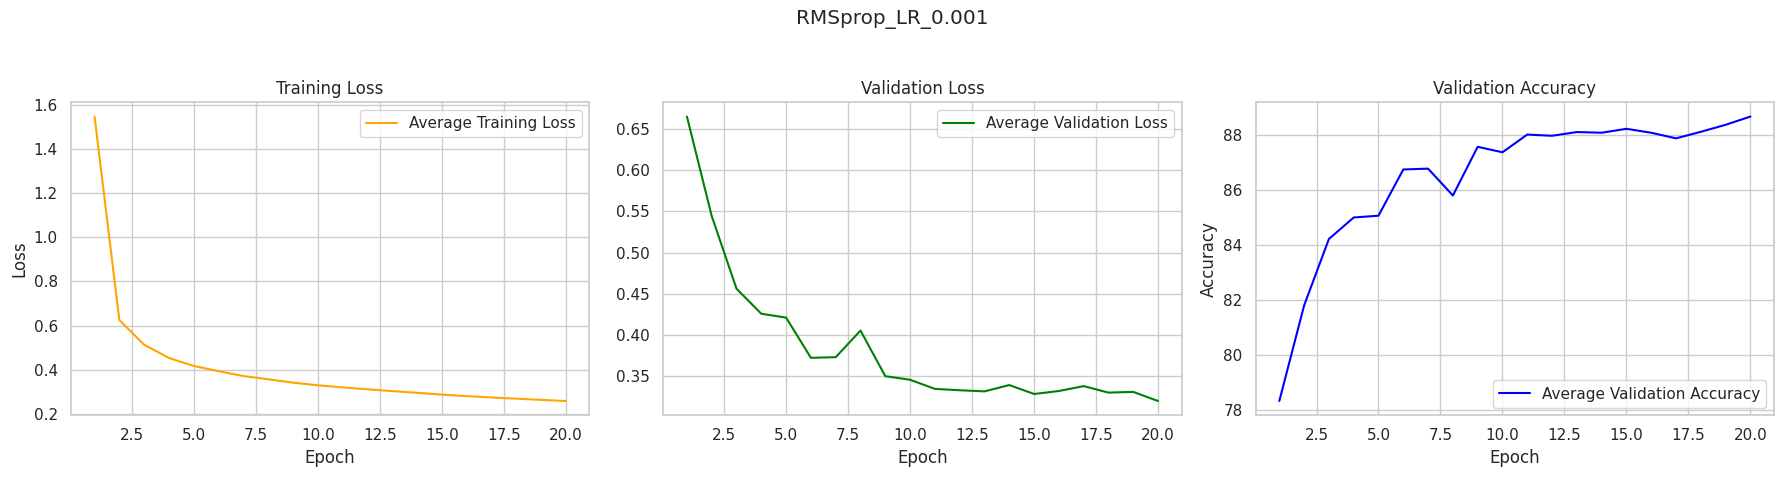

RMSprop_LR_0.001 - Final Average Training Loss: 0.258 | Final Average Validation Loss: 0.320 | Final Average Validation Accuracy: 88.67%



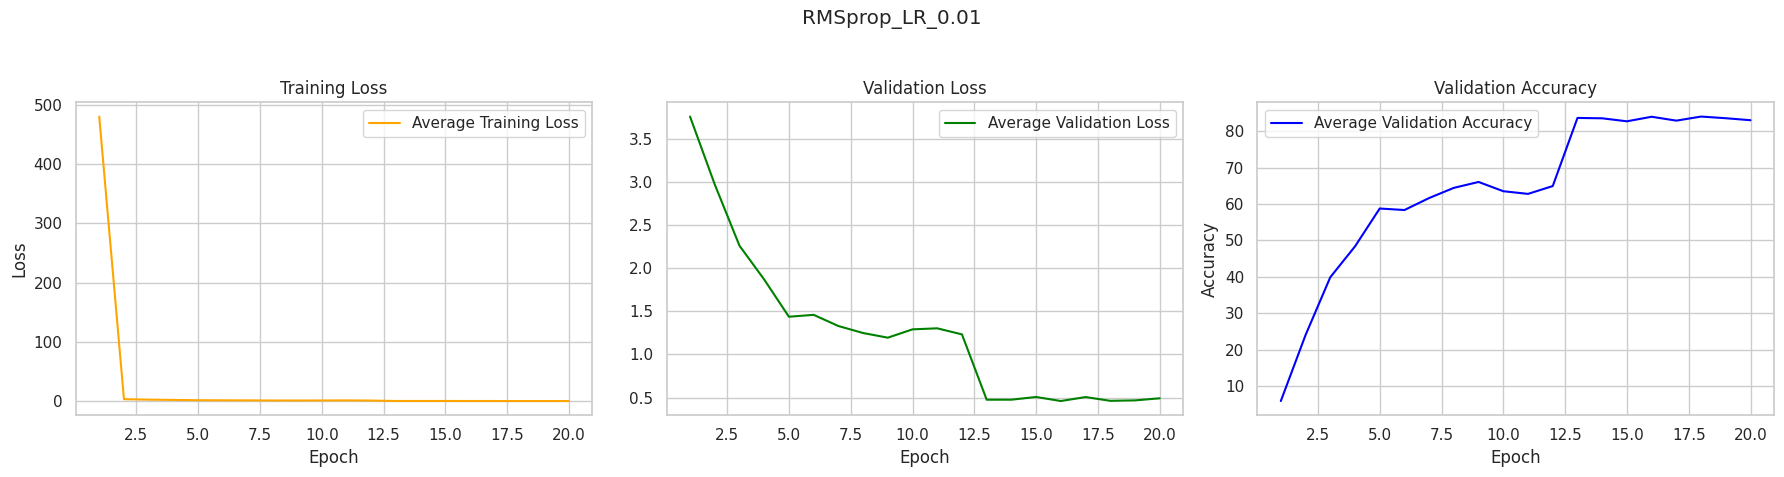

RMSprop_LR_0.01 - Final Average Training Loss: 0.467 | Final Average Validation Loss: 0.492 | Final Average Validation Accuracy: 82.99%



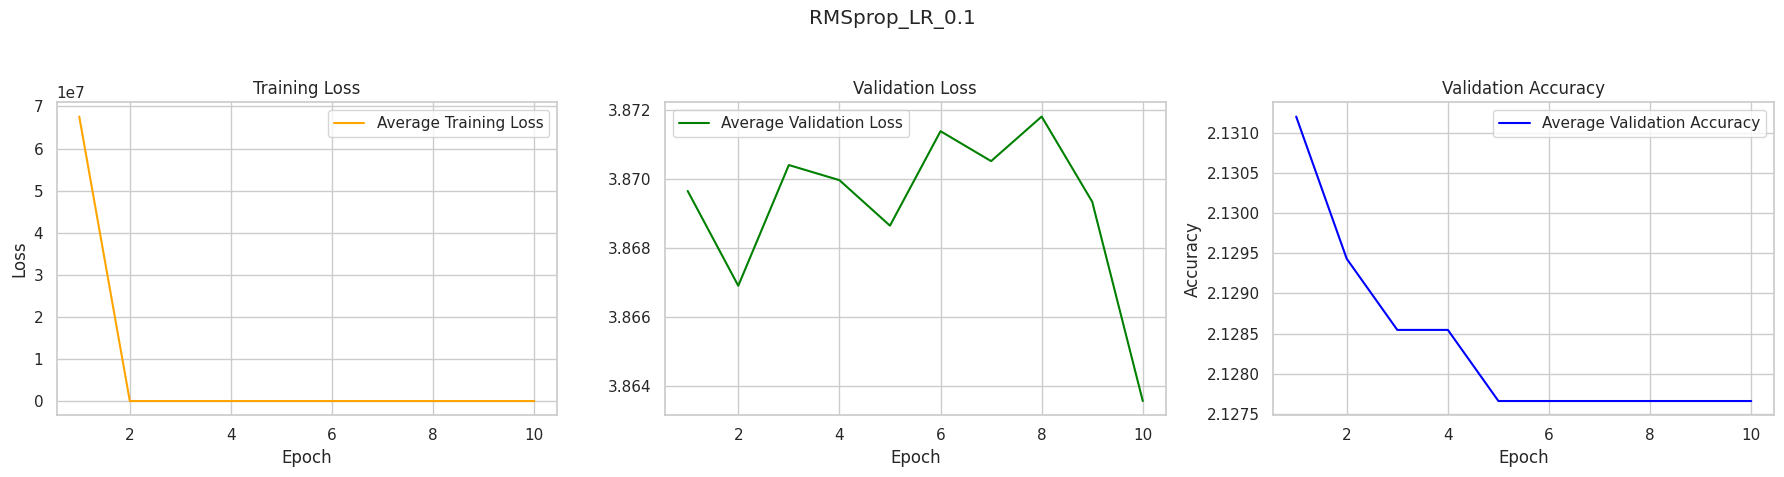

RMSprop_LR_0.1 - Final Average Training Loss: 3.858 | Final Average Validation Loss: 3.864 | Final Average Validation Accuracy: 2.13%



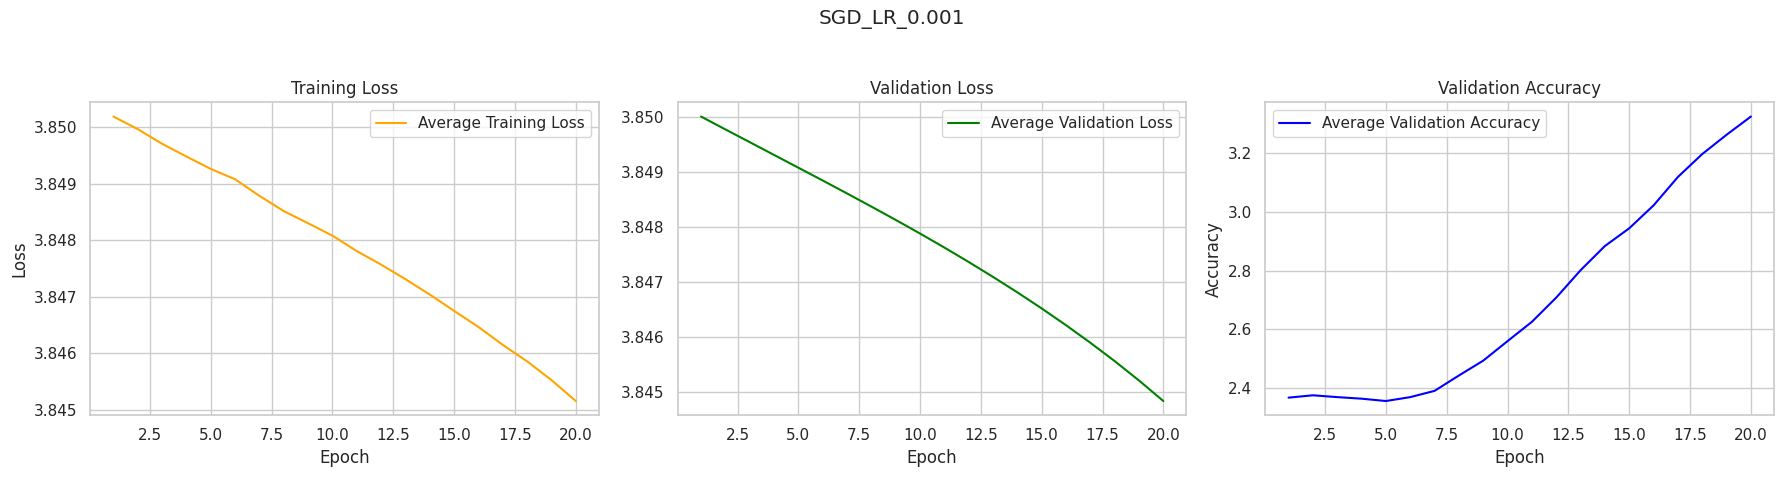

SGD_LR_0.001 - Final Average Training Loss: 3.845 | Final Average Validation Loss: 3.845 | Final Average Validation Accuracy: 3.32%



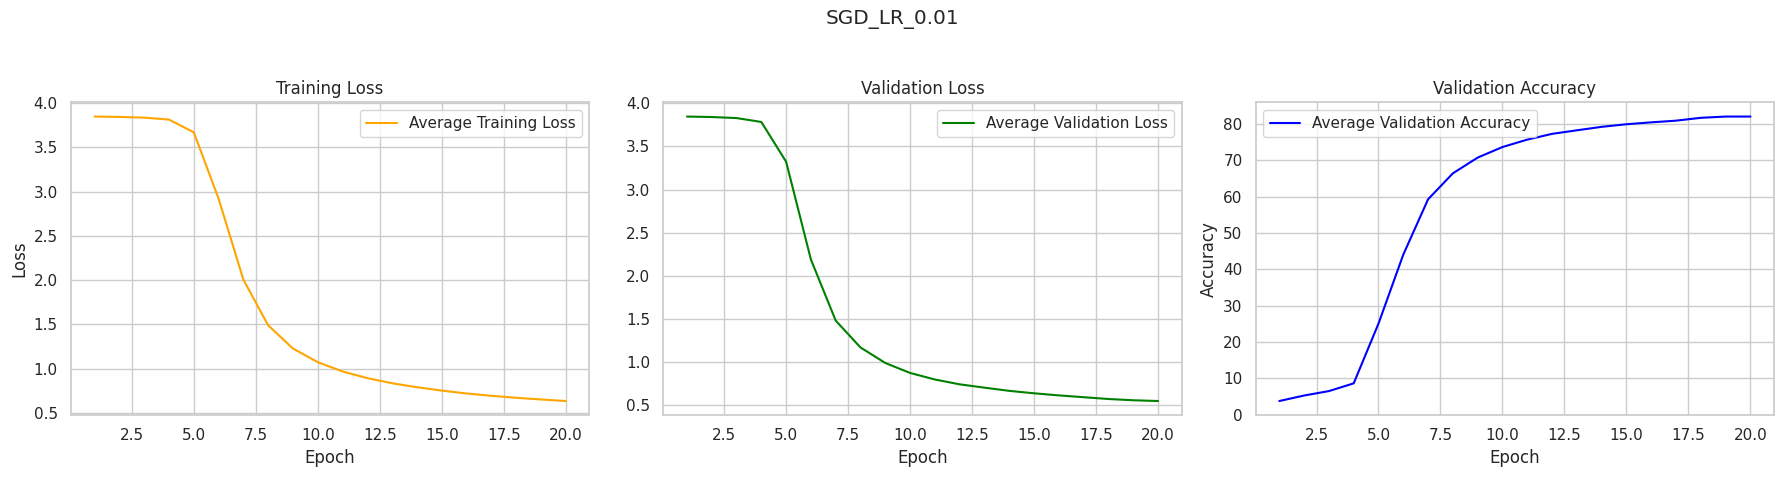

SGD_LR_0.01 - Final Average Training Loss: 0.634 | Final Average Validation Loss: 0.549 | Final Average Validation Accuracy: 81.98%



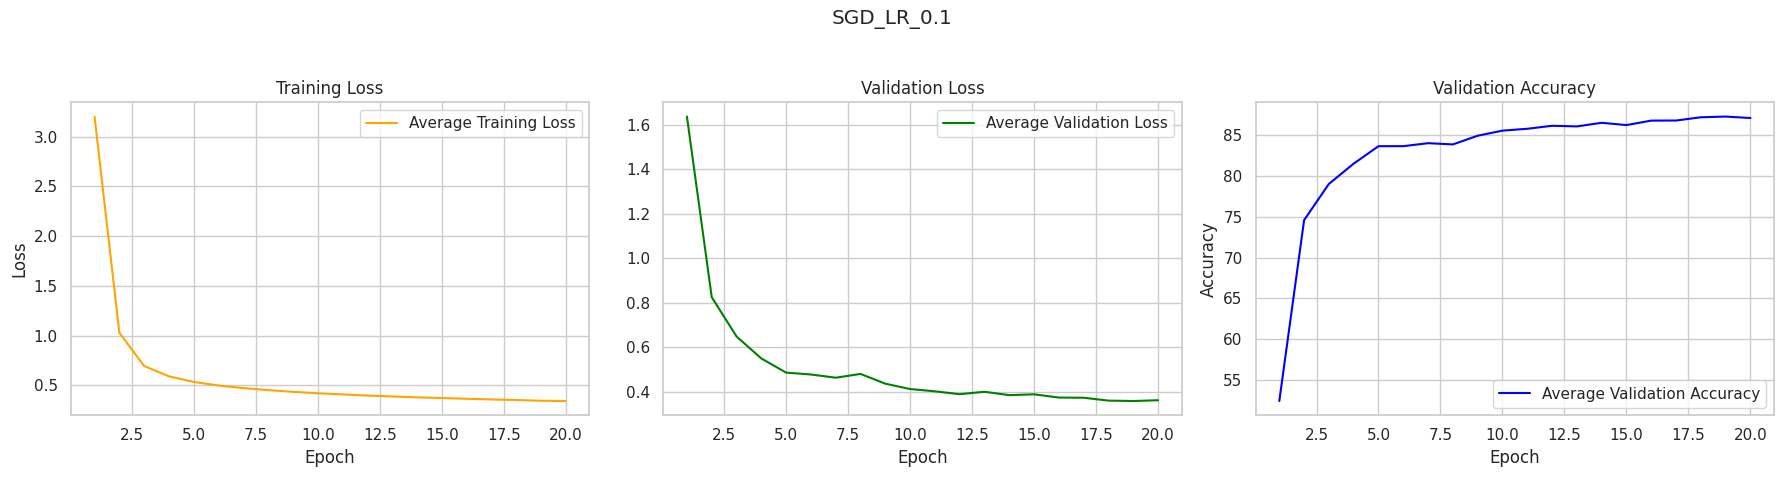

SGD_LR_0.1 - Final Average Training Loss: 0.341 | Final Average Validation Loss: 0.363 | Final Average Validation Accuracy: 87.12%



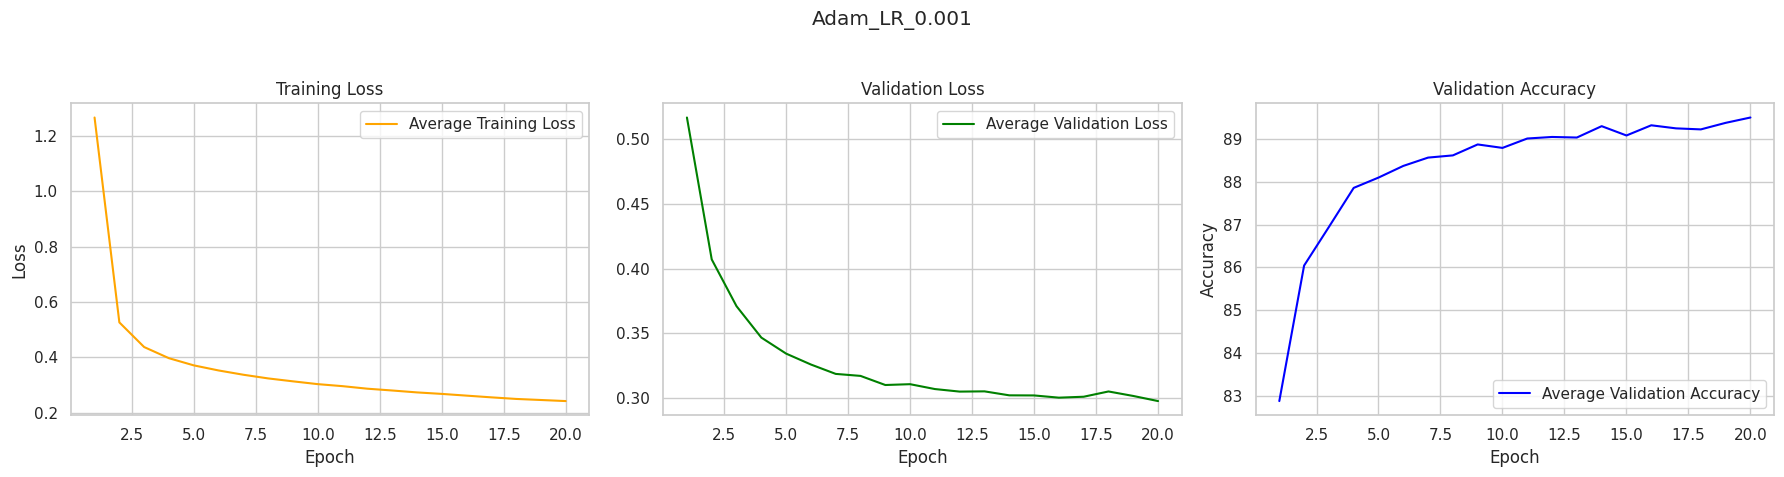

Adam_LR_0.001 - Final Average Training Loss: 0.242 | Final Average Validation Loss: 0.298 | Final Average Validation Accuracy: 89.50%



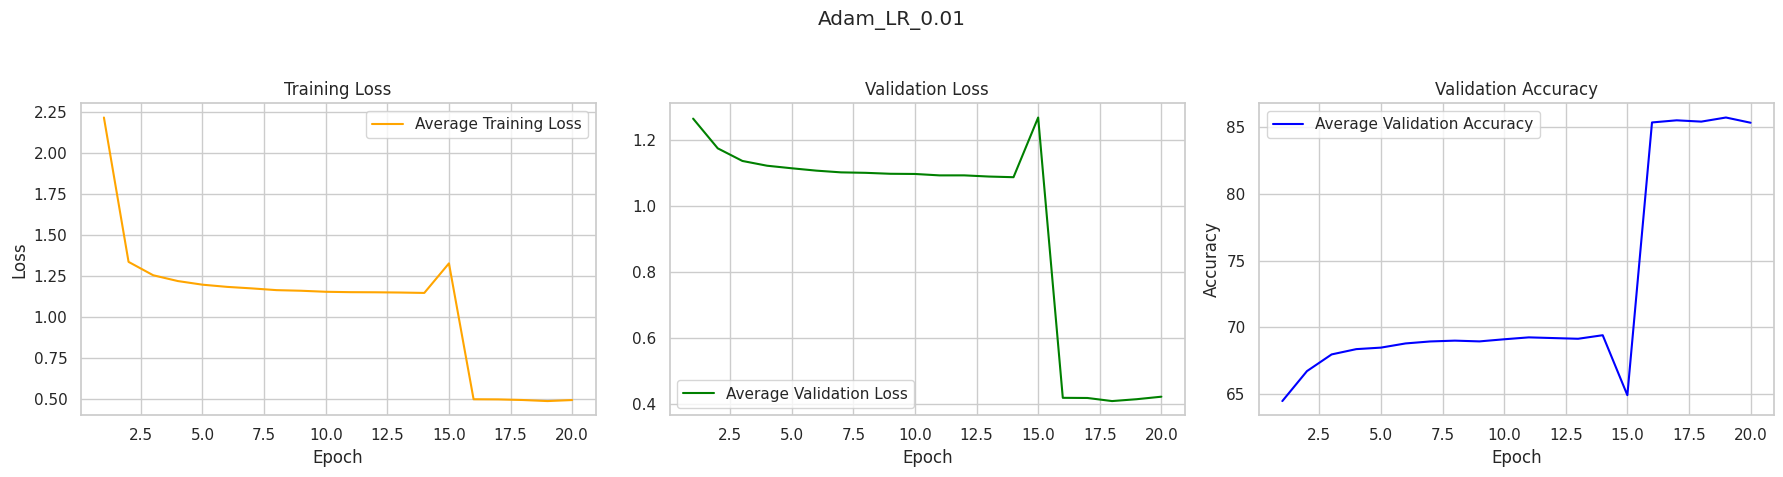

Adam_LR_0.01 - Final Average Training Loss: 0.496 | Final Average Validation Loss: 0.421 | Final Average Validation Accuracy: 85.35%



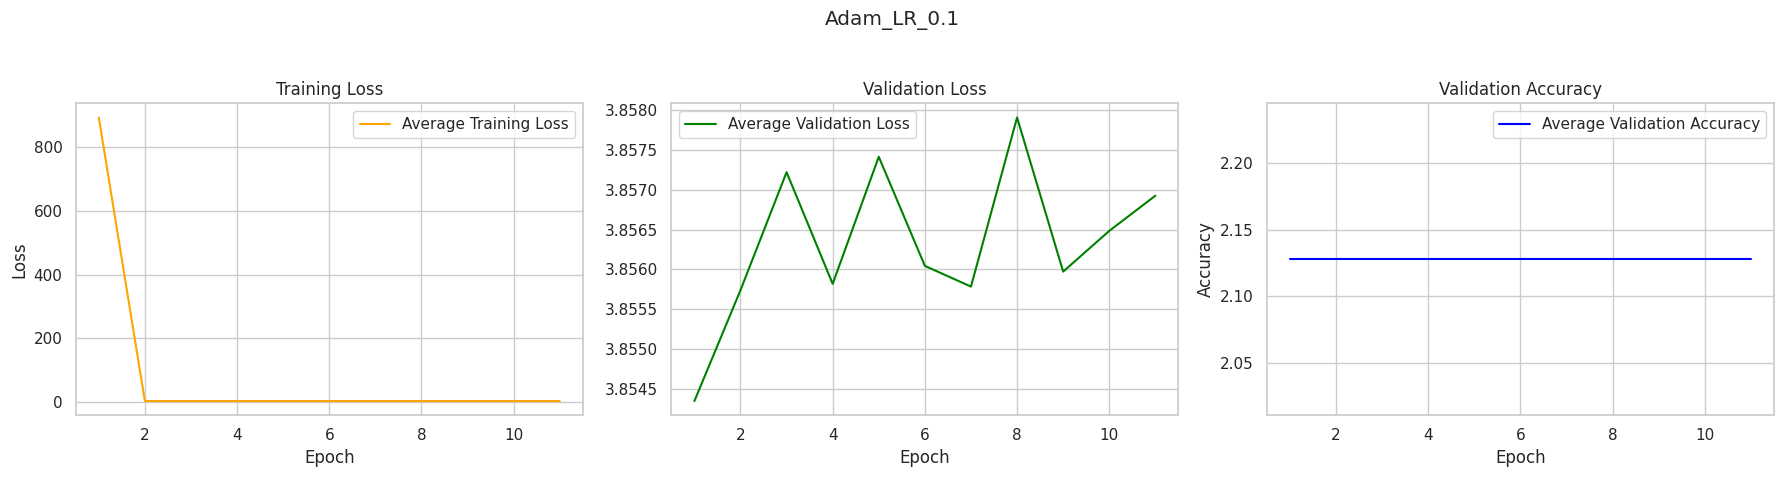

Adam_LR_0.1 - Final Average Training Loss: 3.857 | Final Average Validation Loss: 3.857 | Final Average Validation Accuracy: 2.13%



In [ ]:
# Let's initialise a list to hold a summary of the training results
results_summary_list = []

# We then loop through all combinations in grid_search_results
for combo_name, fold_results in grid_search_results.items():
    # Plot the results and capture the returned summary
    summary = plot_fold_results(fold_results, combo_name)

    # Add the summary to the list
    results_summary_list.append(summary)

In [ ]:
import pandas as pd

# Convert the list of dictionaries into a DataFrame
results_df = pd.DataFrame(results_summary_list)

# Ensure 'final_average_val_accuracy' is numeric (it should be, but this is just in case)
results_df['final_average_val_accuracy'] = pd.to_numeric(results_df['final_average_val_accuracy'])

# Sort the DataFrame by 'final_average_val_accuracy' in ascending order
results_df_sorted = results_df.sort_values('final_average_val_accuracy', ascending=False)

# Display the sorted DataFrame
display(results_df_sorted)

model_title  final_average_train_loss  final_average_val_loss  \
6     Adam_LR_0.001                  0.241868                0.297684   
0  RMSprop_LR_0.001                  0.257861                0.319649   
5        SGD_LR_0.1                  0.341301                0.362618   
7      Adam_LR_0.01                  0.496036                0.420993   
1   RMSprop_LR_0.01                  0.467045                0.491863   
4       SGD_LR_0.01                  0.634084                0.549460   
3      SGD_LR_0.001                  3.845158                3.844830   
2    RMSprop_LR_0.1                  3.857904                3.863575   
8       Adam_LR_0.1                  3.857209                3.856925   

   final_average_val_accuracy  
6                   89.496158  
0                   88.670213  
5                   87.122119  
7                   85.354610  
1                   82.994238  
4                   81.984043  
3                    3.324468  
2                    2.127660  
8                    2.127660

**The 3 best optimizers for our CNN model were:**
Adam @ lr = 0.001
RMSprop @ lr = 0.001
SGD @ lr = 0.1

Therefore each of these will be used in the upcoming grid search experiment


### Learning Rate Schedulers

To be able to explore learning rate schedulers, we need to define different optimizer and scheduler constructors, which we can also use in grid search. We'll use the 3 best optimizers that we previously discovered, and explore the impact that different learning rate schedulers have on the average validation accuracy across all k-fold

In [ ]:
def adam_optimizer(params, lr=0.001):
    return torch.optim.Adam(params, lr=lr)

def rmsprop_optimizer(params, lr=0.001):
    return torch.optim.RMSprop(params, lr=lr)

# Define lr_scheduler constructors, given a Learning Rate.

def step_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

def exponential_lr_scheduler(optimizer):
    return torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.2)

# We can then combine optimizers with schedulers in a dictionary, which we can loop over (effectively performing grid search).
optimizer_scheduler_combinations = {
    'SGD_StepLR': (sgd_optimizer, step_lr_scheduler, {'lr': 0.1}),
    'SGD_ExponentialLR': (sgd_optimizer, exponential_lr_scheduler, {'lr': 0.1}),
    'Adam_StepLR': (adam_optimizer, step_lr_scheduler, {'lr': 0.001}),
    'Adam_ExponentialLR': (adam_optimizer, exponential_lr_scheduler, {'lr': 0.001}),
    'RMSprop_StepLR': (rmsprop_optimizer, step_lr_scheduler, {'lr': 0.001}),
    'RMSprop_ExponentialLR': (rmsprop_optimizer, exponential_lr_scheduler, {'lr': 0.001}),
}

As before, we have to update our train_and_validate model function to accept an optimizer and a scheduler as arguments.

In [ ]:
def train_and_validate_model(train_loader, val_loader, model, optimizer, scheduler, epochs, device):
    from torch import no_grad
    from torch.nn import functional as F

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()  # Set model to training mode
        train_loss = 0

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)
            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Update the learning rate after each epoch
        scheduler.step()

        model.eval()
        val_loss = 0
        correct = 0
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                val_loss += F.cross_entropy(y_pred, y).item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)

    return train_losses, val_losses, val_accuracies

We also need to update our k-fold cross validation function:


In [ ]:

def stratified_k_fold_cross_validation(dataset, n_splits, model_constructor, setup_optimizer_scheduler, epochs, device):
    """
    Performs stratified k-fold cross-validation for the given dataset and model.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - optimizer_constructor: Function that takes a model's parameters and returns an optimizer.
    - setup_optimizer_scheduler:
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    """
    features = dataset.tensors[0].numpy()
    labels = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        # Start timing here
        fold_start_time = timer()

        # Splitting the dataset into training and validation for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Creating data loaders for the current fold
        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        # Initializing the model, optimizer and early stopping tollerance, for the current fold
        model = model_constructor().to(device)
        optimizer, scheduler = setup_optimizer_scheduler(model.parameters())

        # Training and validation for the current fold
        train_losses, val_losses, val_accuracies = train_and_validate_model(
            train_loader, val_loader, model, optimizer, scheduler, epochs, device
        )

         # End timing here
        fold_end_time = timer()

        fold_train_time = fold_end_time - fold_start_time

        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'train_time': fold_train_time
        })

        print_train_time(fold_start_time, fold_end_time, device)

        print(f"Fold {fold} completed. Validation accuracy: {val_accuracies[-1]:.2f}\n")

    return fold_results


In [ ]:
def grid_search_optimizers_schedulers(dataset, n_splits, model_constructor, optimizer_scheduler_combinations, epochs, device):
    all_results = {}

    for name, (optimizer_constructor, scheduler_constructor, optimizer_args) in optimizer_scheduler_combinations.items():
        print(f"Testing optimizer and scheduler combination: {name}\n")

        # Adjust the function to construct both optimizer and scheduler
        def optimizer_and_scheduler_constructor(params):
            optimizer = optimizer_constructor(params, **optimizer_args)
            scheduler = scheduler_constructor(optimizer)
            return optimizer, scheduler

        fold_results = stratified_k_fold_cross_validation(
            dataset=dataset,
            n_splits=n_splits,
            model_constructor=model_constructor,
            setup_optimizer_scheduler=optimizer_and_scheduler_constructor,
            epochs=epochs,
            device=device
        )

        all_results[name] = fold_results

    return all_results

In [ ]:
# call grid_search_optimizers_schedulers function and store results
optim_schedule_grid_search = grid_search_optimizers_schedulers(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    optimizer_scheduler_combinations=optimizer_scheduler_combinations,
    epochs=20,
    device=device
)

Testing optimizer and scheduler combination: SGD_StepLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:57<00:00,  5.87s/it]


Train time on cuda: 117.362 seconds
Fold 1 completed. Validation accuracy: 89.73

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:55<00:00,  5.77s/it]


Train time on cuda: 115.373 seconds
Fold 2 completed. Validation accuracy: 89.25

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:59<00:00,  5.99s/it]


Train time on cuda: 119.716 seconds
Fold 3 completed. Validation accuracy: 89.56

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [02:16<00:00,  6.85s/it]


Train time on cuda: 136.919 seconds
Fold 4 completed. Validation accuracy: 89.56

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [02:14<00:00,  6.72s/it]


Train time on cuda: 134.365 seconds
Fold 5 completed. Validation accuracy: 89.29

Testing optimizer and scheduler combination: SGD_ExponentialLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [02:16<00:00,  6.81s/it]


Train time on cuda: 136.158 seconds
Fold 1 completed. Validation accuracy: 86.08

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:55<00:00,  5.80s/it]


Train time on cuda: 115.981 seconds
Fold 2 completed. Validation accuracy: 85.60

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:55<00:00,  5.75s/it]


Train time on cuda: 115.091 seconds
Fold 3 completed. Validation accuracy: 85.66

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:54<00:00,  5.72s/it]


Train time on cuda: 114.455 seconds
Fold 4 completed. Validation accuracy: 86.00

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:54<00:00,  5.73s/it]


Train time on cuda: 114.674 seconds
Fold 5 completed. Validation accuracy: 86.02

Testing optimizer and scheduler combination: Adam_StepLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:58<00:00,  5.91s/it]


Train time on cuda: 118.315 seconds
Fold 1 completed. Validation accuracy: 89.78

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [02:06<00:00,  6.32s/it]


Train time on cuda: 126.326 seconds
Fold 2 completed. Validation accuracy: 89.55

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [02:08<00:00,  6.42s/it]


Train time on cuda: 128.396 seconds
Fold 3 completed. Validation accuracy: 89.94

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [02:01<00:00,  6.09s/it]


Train time on cuda: 121.743 seconds
Fold 4 completed. Validation accuracy: 89.90

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:58<00:00,  5.93s/it]


Train time on cuda: 118.566 seconds
Fold 5 completed. Validation accuracy: 89.90

Testing optimizer and scheduler combination: Adam_ExponentialLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [02:04<00:00,  6.22s/it]


Train time on cuda: 124.357 seconds
Fold 1 completed. Validation accuracy: 88.18

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:59<00:00,  5.99s/it]


Train time on cuda: 119.874 seconds
Fold 2 completed. Validation accuracy: 87.61

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:59<00:00,  5.96s/it]


Train time on cuda: 119.237 seconds
Fold 3 completed. Validation accuracy: 88.06

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:58<00:00,  5.92s/it]


Train time on cuda: 118.473 seconds
Fold 4 completed. Validation accuracy: 88.05

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:58<00:00,  5.95s/it]


Train time on cuda: 118.945 seconds
Fold 5 completed. Validation accuracy: 87.72

Testing optimizer and scheduler combination: RMSprop_StepLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:56<00:00,  5.81s/it]


Train time on cuda: 116.223 seconds
Fold 1 completed. Validation accuracy: 89.72

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [02:02<00:00,  6.11s/it]


Train time on cuda: 122.154 seconds
Fold 2 completed. Validation accuracy: 89.51

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:57<00:00,  5.87s/it]


Train time on cuda: 117.450 seconds
Fold 3 completed. Validation accuracy: 89.77

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:56<00:00,  5.84s/it]


Train time on cuda: 116.831 seconds
Fold 4 completed. Validation accuracy: 89.79

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:56<00:00,  5.80s/it]


Train time on cuda: 116.102 seconds
Fold 5 completed. Validation accuracy: 89.77

Testing optimizer and scheduler combination: RMSprop_ExponentialLR

Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:56<00:00,  5.84s/it]


Train time on cuda: 116.877 seconds
Fold 1 completed. Validation accuracy: 87.34

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:57<00:00,  5.86s/it]


Train time on cuda: 117.256 seconds
Fold 2 completed. Validation accuracy: 86.95

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [02:09<00:00,  6.46s/it]


Train time on cuda: 129.258 seconds
Fold 3 completed. Validation accuracy: 86.94

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:56<00:00,  5.82s/it]


Train time on cuda: 116.463 seconds
Fold 4 completed. Validation accuracy: 86.61

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:55<00:00,  5.79s/it]

Train time on cuda: 115.730 seconds
Fold 5 completed. Validation accuracy: 87.03



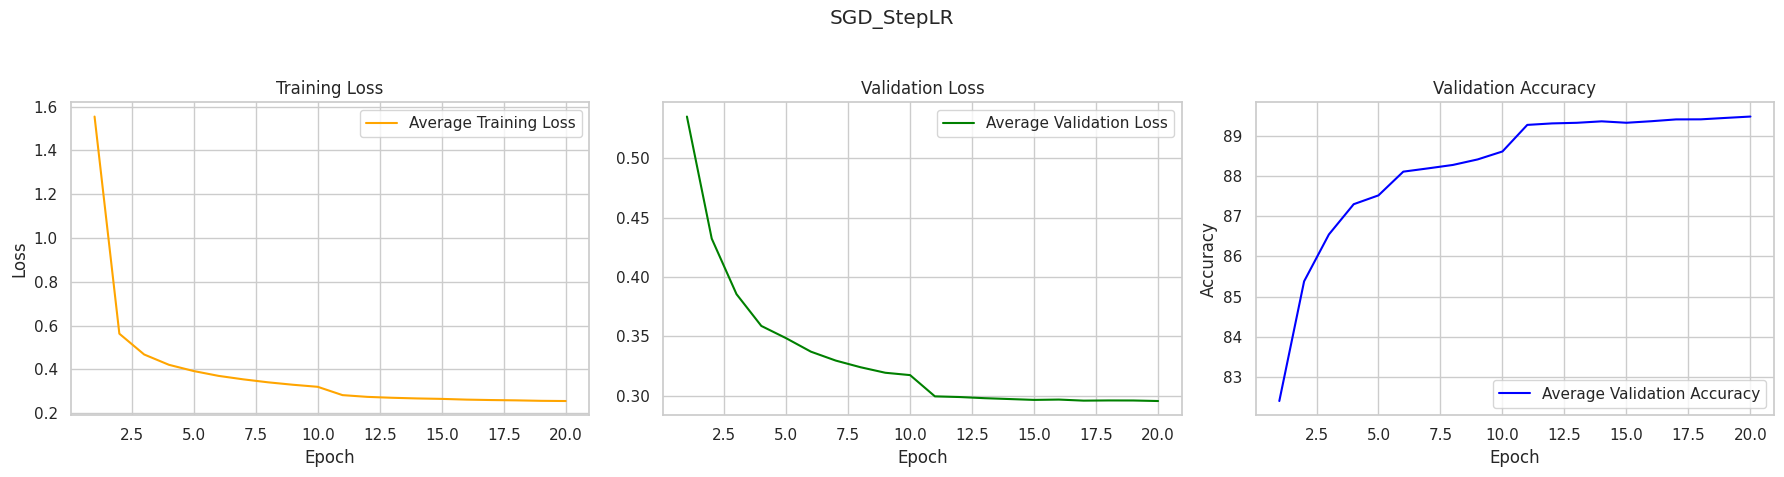

SGD_StepLR - Final Average Training Loss: 0.256 | Final Average Validation Loss: 0.296 | Final Average Validation Accuracy: 89.48%



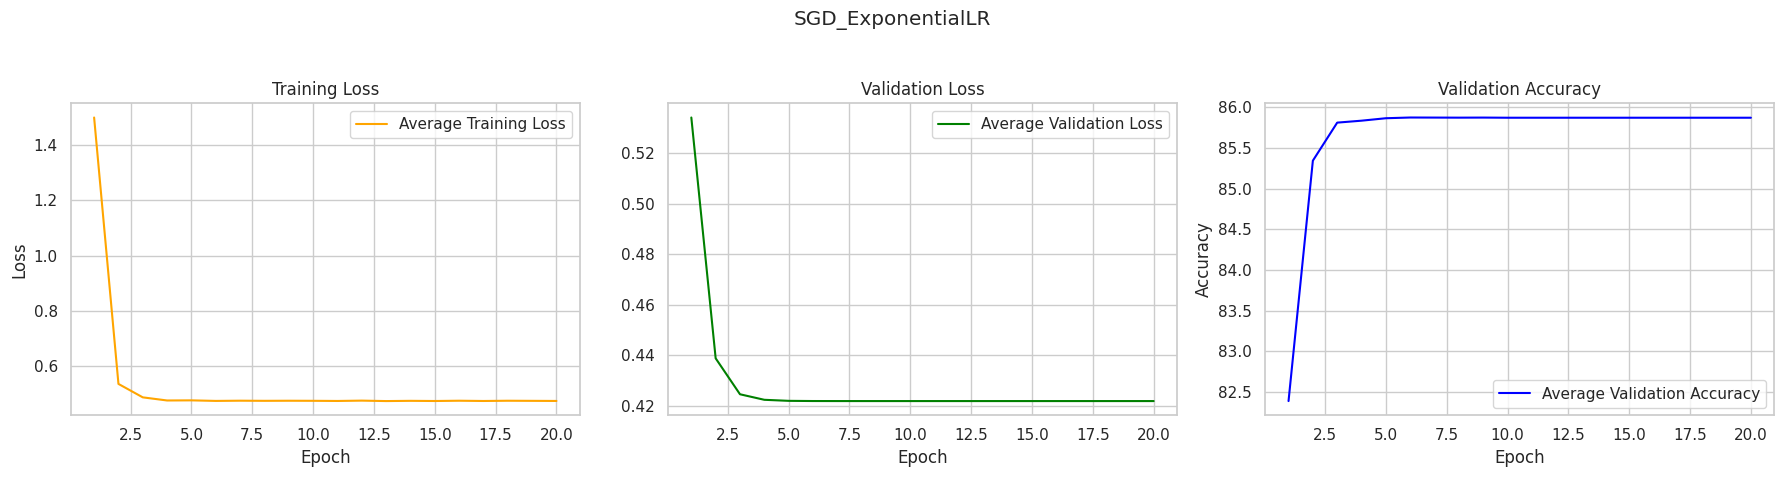

SGD_ExponentialLR - Final Average Training Loss: 0.475 | Final Average Validation Loss: 0.422 | Final Average Validation Accuracy: 85.87%



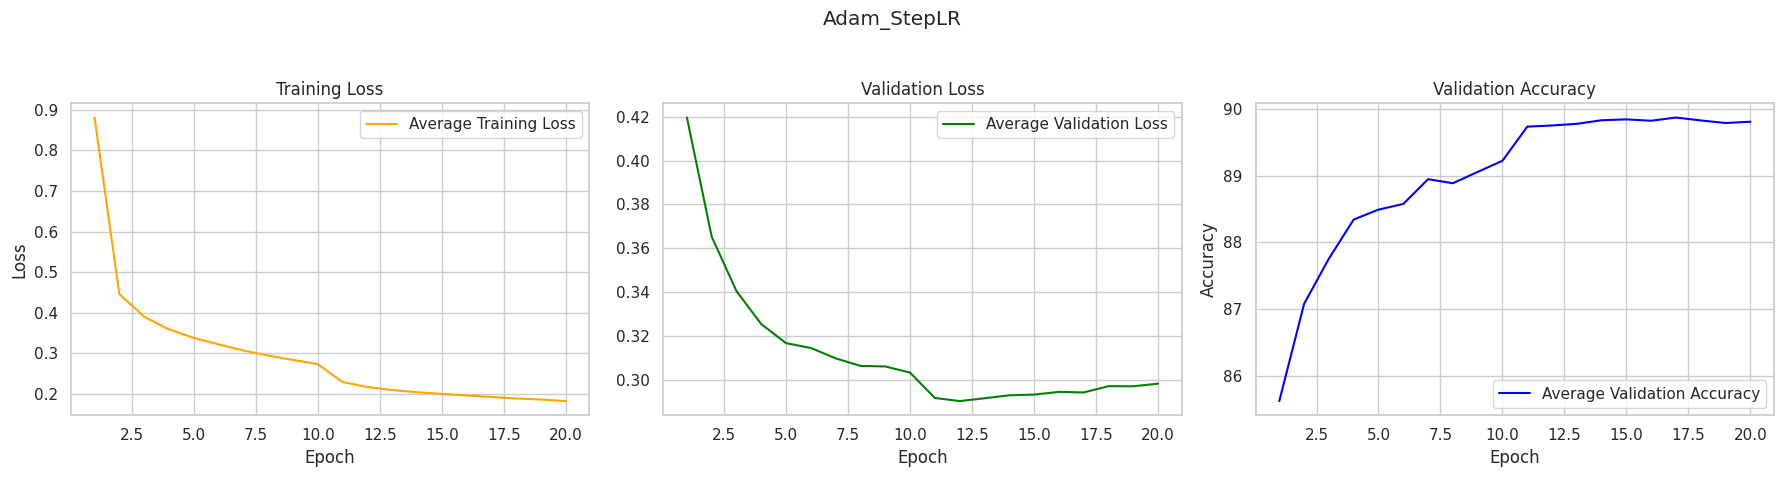

Adam_StepLR - Final Average Training Loss: 0.183 | Final Average Validation Loss: 0.298 | Final Average Validation Accuracy: 89.81%



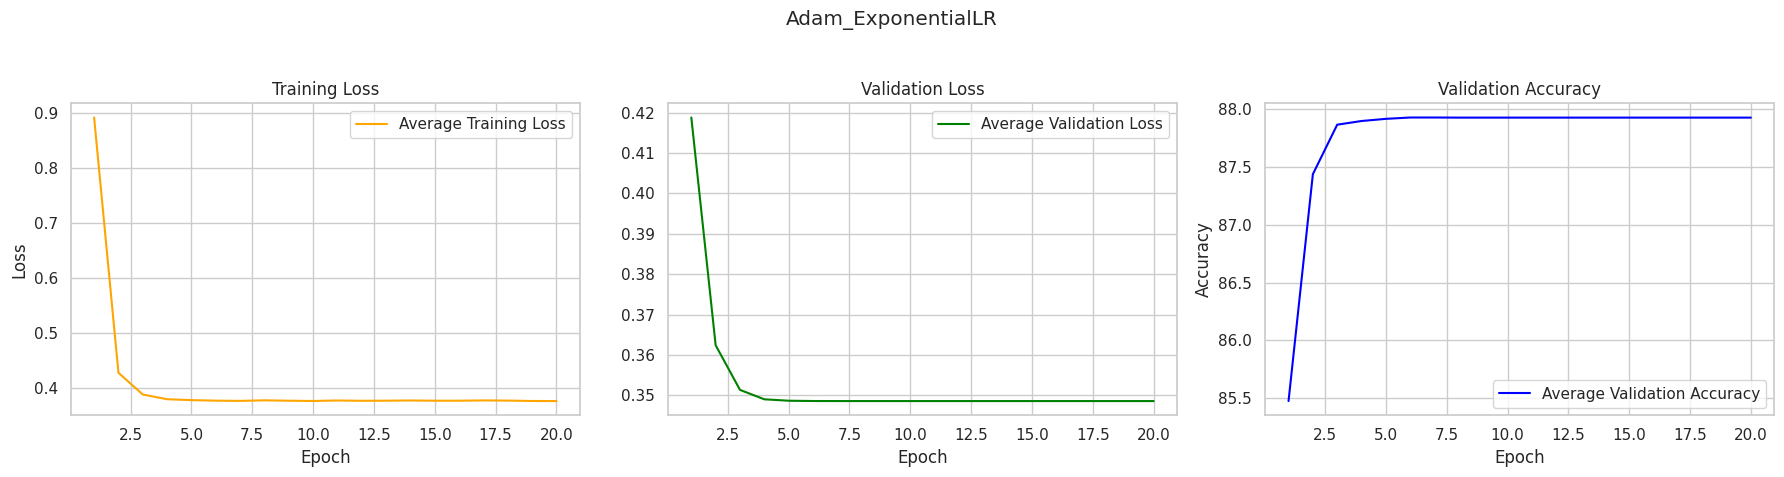

Adam_ExponentialLR - Final Average Training Loss: 0.376 | Final Average Validation Loss: 0.349 | Final Average Validation Accuracy: 87.92%



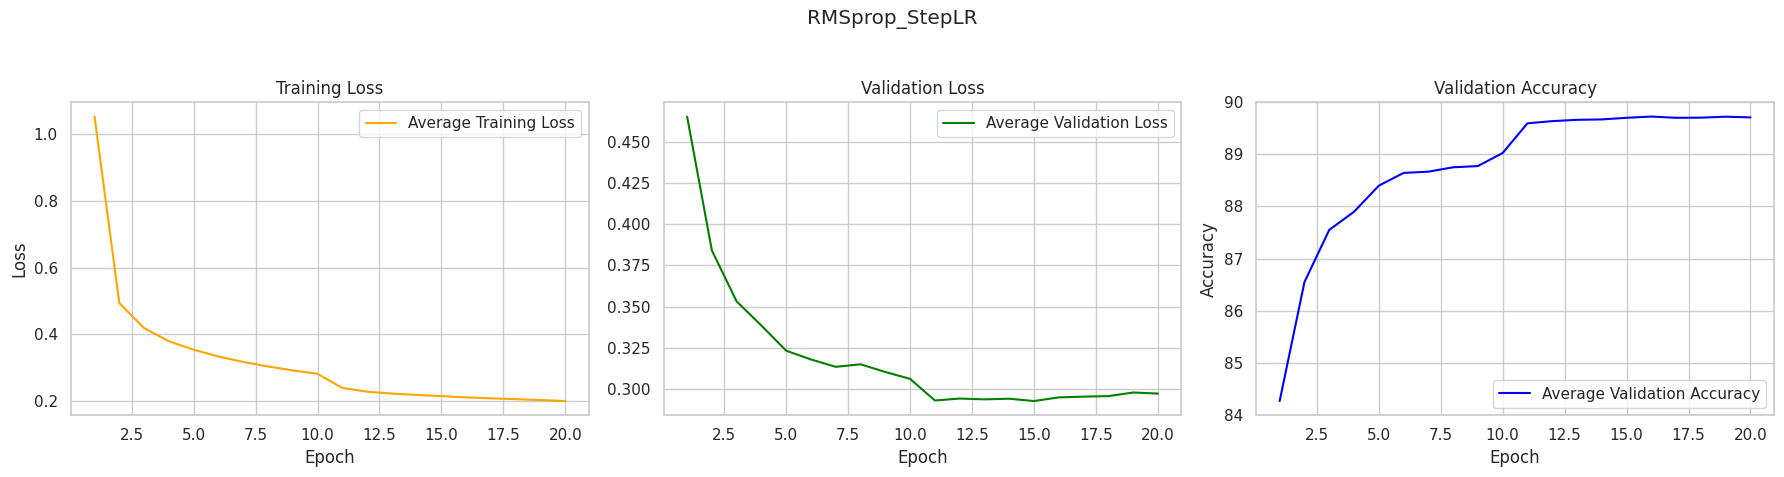

RMSprop_StepLR - Final Average Training Loss: 0.200 | Final Average Validation Loss: 0.297 | Final Average Validation Accuracy: 89.71%



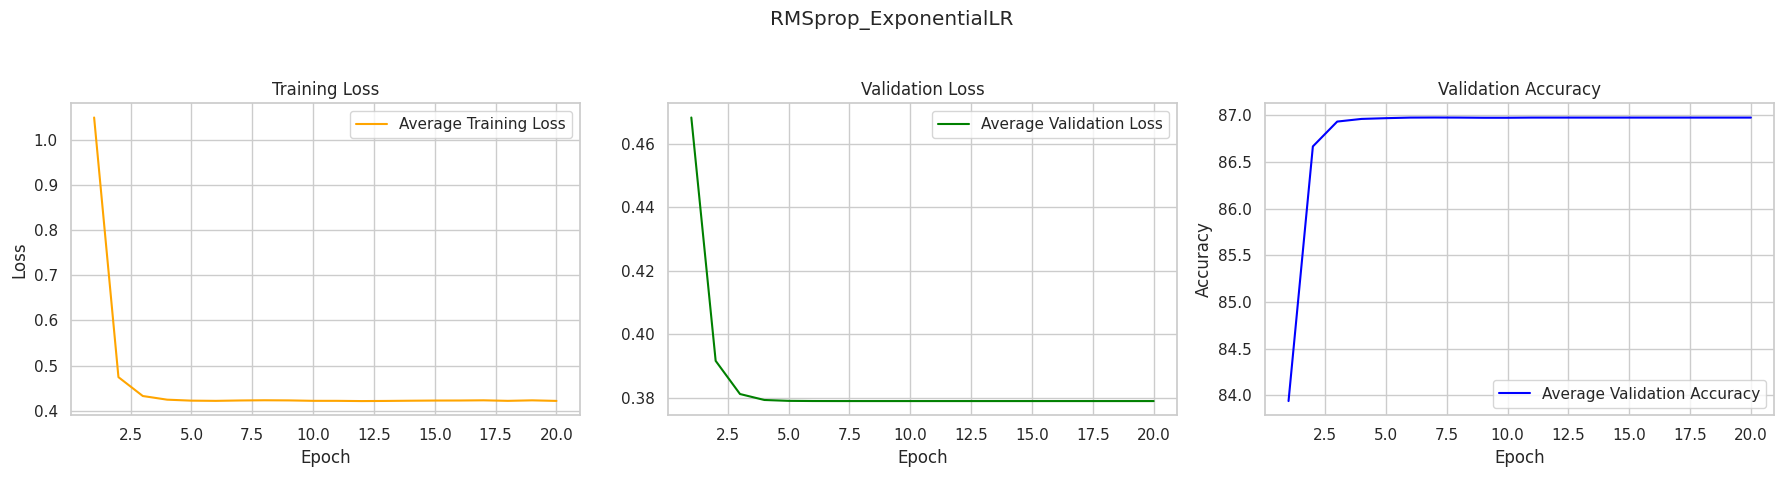

RMSprop_ExponentialLR - Final Average Training Loss: 0.422 | Final Average Validation Loss: 0.379 | Final Average Validation Accuracy: 86.97%



In [ ]:
# Let's initialise a new list to hold a summary of the training results
scheduler_results_summary_list = []

# We then loop through all combinations in grid_search_results
for combo_name, fold_results in optim_schedule_grid_search.items():
    # Plot the results and capture the returned summary
    summary = plot_fold_results(fold_results, combo_name)

    # Add the summary to the list
    scheduler_results_summary_list.append(summary)

In [ ]:
import pandas as pd

# Convert the list of dictionaries into a DataFrame
scheduler_results_df = pd.DataFrame(scheduler_results_summary_list)

# Ensure 'final_average_val_accuracy' is numeric (it should be, but this is just in case)
scheduler_results_df['final_average_val_accuracy'] = pd.to_numeric(scheduler_results_df['final_average_val_accuracy'])

# Sort the DataFrame by 'final_average_val_accuracy' in ascending order
scheduler_results_df_sorted = scheduler_results_df.sort_values('final_average_val_accuracy', ascending=False)

# Display the sorted DataFrame
display(scheduler_results_df_sorted)

model_title  final_average_train_loss  final_average_val_loss  \
2            Adam_StepLR                  0.182868                0.298105   
4         RMSprop_StepLR                  0.200176                0.297096   
0             SGD_StepLR                  0.255564                0.295658   
3     Adam_ExponentialLR                  0.376408                0.348567   
5  RMSprop_ExponentialLR                  0.421854                0.378932   
1      SGD_ExponentialLR                  0.475407                0.421961   

   final_average_val_accuracy  
2                   89.814716  
4                   89.710993  
0                   89.476064  
3                   87.923759  
5                   86.973404  
1                   85.874113

As shown in the table above, The Adam optimizer with the StepLR scheduler performs the best, only slightly outperforming RMSprop optimizer with StepLR, we will therefore use the Adam_StepLR, optimizer/scheduler combo for our next set of tests

### Activation Functions

we will compare The performance of 3 different activation functions On the current best performing model, that being the ADAM optimizer using the StepLR scheduler with a 4-layer MLP model

In [ ]:
activation_functions = {
    'ReLU': F.relu,
    'LeakyReLU': F.leaky_relu,
    'ELU': F.elu
}

In [ ]:
def get_model_constructor(activation_fn):
    def model_constructor():
        return FourLayerCNN(activation_fn=activation_fn)
    return model_constructor


Running cross-validation with ReLU activation function.
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:55<00:00,  5.78s/it]


Train time on cuda: 115.530 seconds
Fold 1 completed. Validation accuracy: 89.98

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


Train time on cuda: 130.211 seconds
Fold 2 completed. Validation accuracy: 89.45

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:59<00:00,  5.96s/it]


Train time on cuda: 119.210 seconds
Fold 3 completed. Validation accuracy: 89.85

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:55<00:00,  5.78s/it]


Train time on cuda: 115.551 seconds
Fold 4 completed. Validation accuracy: 89.86

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:56<00:00,  5.81s/it]


Train time on cuda: 116.153 seconds
Fold 5 completed. Validation accuracy: 89.69



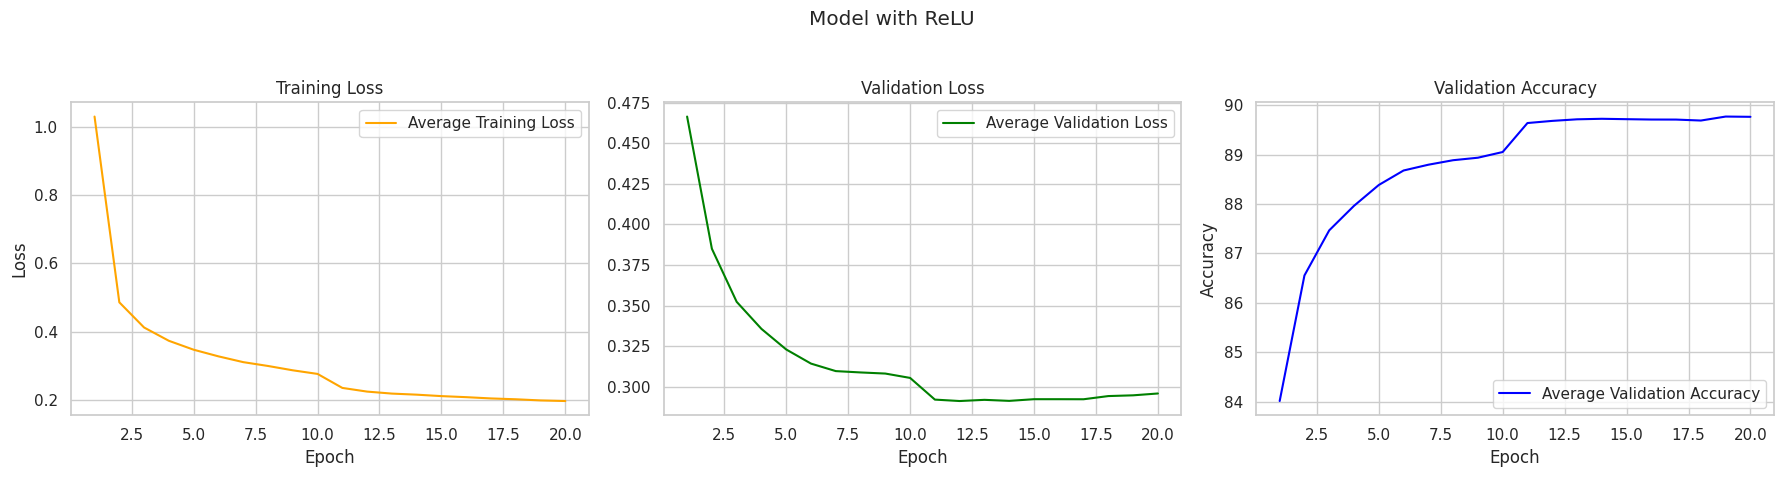

Model with ReLU - Final Average Training Loss: 0.197 | Final Average Validation Loss: 0.296 | Final Average Validation Accuracy: 89.77%

Running cross-validation with LeakyReLU activation function.
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:55<00:00,  5.78s/it]


Train time on cuda: 115.624 seconds
Fold 1 completed. Validation accuracy: 89.92

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:56<00:00,  5.82s/it]


Train time on cuda: 116.423 seconds
Fold 2 completed. Validation accuracy: 89.53

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:55<00:00,  5.77s/it]


Train time on cuda: 115.389 seconds
Fold 3 completed. Validation accuracy: 89.77

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:56<00:00,  5.80s/it]


Train time on cuda: 116.108 seconds
Fold 4 completed. Validation accuracy: 89.78

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:55<00:00,  5.77s/it]


Train time on cuda: 115.414 seconds
Fold 5 completed. Validation accuracy: 89.82



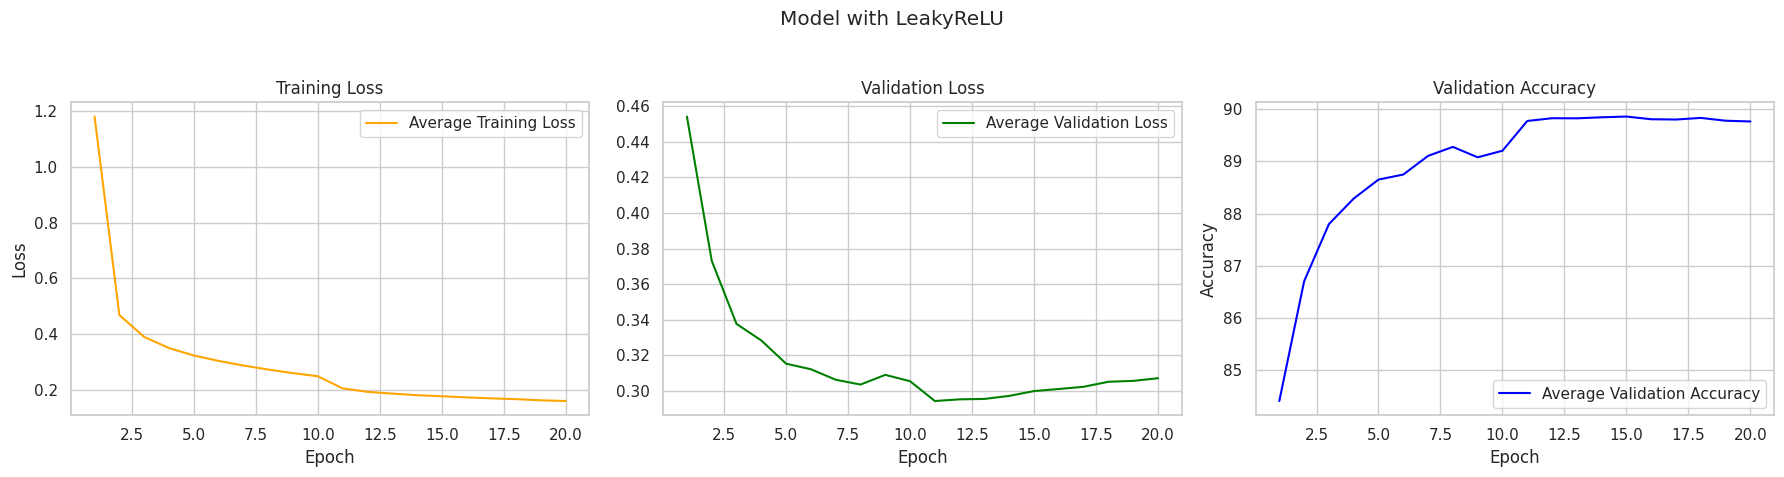

Model with LeakyReLU - Final Average Training Loss: 0.161 | Final Average Validation Loss: 0.307 | Final Average Validation Accuracy: 89.77%

Running cross-validation with ELU activation function.
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:56<00:00,  5.81s/it]


Train time on cuda: 116.206 seconds
Fold 1 completed. Validation accuracy: 89.25

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:55<00:00,  5.77s/it]


Train time on cuda: 115.441 seconds
Fold 2 completed. Validation accuracy: 88.73

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:56<00:00,  5.80s/it]


Train time on cuda: 116.027 seconds
Fold 3 completed. Validation accuracy: 89.29

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:55<00:00,  5.78s/it]


Train time on cuda: 115.647 seconds
Fold 4 completed. Validation accuracy: 89.35

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:56<00:00,  5.81s/it]


Train time on cuda: 116.304 seconds
Fold 5 completed. Validation accuracy: 89.49



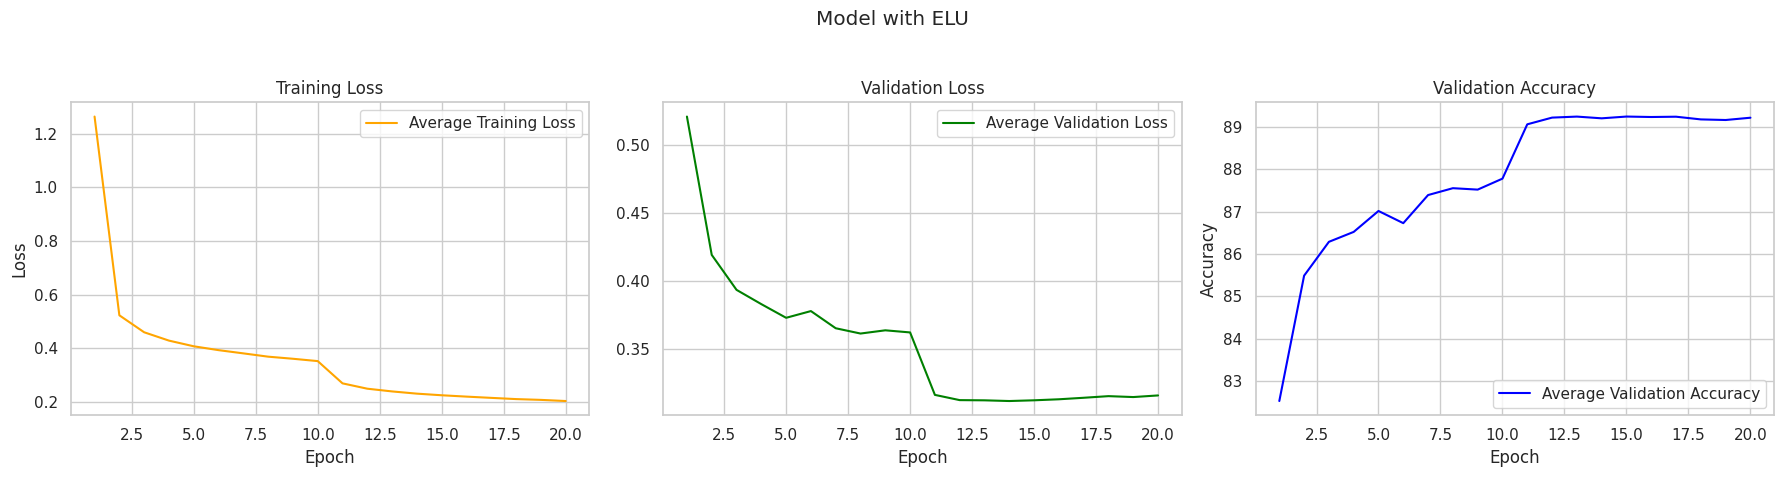

Model with ELU - Final Average Training Loss: 0.203 | Final Average Validation Loss: 0.315 | Final Average Validation Accuracy: 89.22%



In [ ]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001)  # Best optimizer from previous experiment.
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

activation_metrics_list = []

for activation_name, activation_fn in activation_functions.items():
    print(f"Running cross-validation with {activation_name} activation function.")

    # Get a model constructor for the current activation function
    model_constructor = get_model_constructor(activation_fn)

    # Perform stratified k-fold cross-validation
    fold_results = stratified_k_fold_cross_validation(
        dataset=train_dataset,
        n_splits=5,
        model_constructor=model_constructor,
        setup_optimizer_scheduler=setup_optimizer_scheduler,
        epochs=20,
        device=device
    )

    # Plot the results
    plot_fold_results(fold_results, f"Model with {activation_name}")

    # Calculate summary statistics
    avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
    avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
    avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

    # Append metrics to metrics list
    activation_metrics_list.append({
        'Activation Function': activation_name,
        'Average Final Training Loss': avg_final_train_loss,
        'Average Final Validation Loss': avg_final_val_loss,
        'Average Final Validation Accuracy': avg_final_val_accuracy
    })


In [ ]:
# Convert the list of dictionaries to a DataFrame
activation_metrics_df = pd.DataFrame(activation_metrics_list)

# Sort the DataFrame by 'Average Final Validation Accuracy'
sorted_activation_metrics_df = activation_metrics_df.sort_values('Average Final Validation Accuracy', ascending=False)

# Display the sorted DataFrame
display(sorted_activation_metrics_df)

Activation Function  Average Final Training Loss  \
0                ReLU                     0.197132   
1           LeakyReLU                     0.161103   
2                 ELU                     0.203065   

   Average Final Validation Loss  Average Final Validation Accuracy  
0                       0.295836                          89.765071  
1                       0.307171                          89.765071  
2                       0.315443                          89.222518

The results show that the Relu activation function performs the best, with an Average Final Validation Accuracy of 89.77%

### Batch Normalisation

Batch normalization will be used to normalize the activations of each layer by adjusting and scaling them based on the mean and variance of the mini-batch during training.

Batch normalisation is implemented by re-defining the four layer MLP model to accept a boolean parameter that will include batch normalisation functions within the model if a condition is met (boolean = True), allowing for ease of use when testing Batch normalisation.

In [ ]:
class FourLayerCNN_with_BN(nn.Module):
    def __init__(self, num_classes=47, use_dropout=True, activation_fn=F.relu):
        super(FourLayerCNN_with_BN, self).__init__()
        self.activation_fn = activation_fn

        # Define the first convolutional layer
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # Input size (1, 28, 28)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (32, 14, 14)

        # Define the second convolutional layer
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (64, 7, 7)

        # Define the third convolutional layer
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        # Define the fourth convolutional layer
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: (128, 3, 3)

        # Optional dropout layer
        self.dropout = nn.Dropout(0.5) if use_dropout else nn.Identity()

        # Define the output layer
        self.fc = nn.Linear(128 * 3 * 3, num_classes)

    def forward(self, x):
        x = self.pool1(self.activation_fn(self.bn1(self.conv1(x))))
        x = self.pool2(self.activation_fn(self.bn2(self.conv2(x))))
        x = self.activation_fn(self.bn3(self.conv3(x)))
        x = self.pool4(self.activation_fn(self.bn4(self.conv4(x))))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

In [ ]:
def get_model_constructor(activation_fn):
    def model_constructor():
        return FourLayerCNN_with_BN(activation_fn= F.relu) #best performing activation function
    return model_constructor

Running cross-validation with Batch normalisation on current best model
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [02:37<00:00,  7.85s/it]


Train time on cuda: 157.094 seconds
Fold 1 completed. Validation accuracy: 89.58

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [02:18<00:00,  6.93s/it]


Train time on cuda: 138.655 seconds
Fold 2 completed. Validation accuracy: 88.78

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [02:30<00:00,  7.53s/it]


Train time on cuda: 150.661 seconds
Fold 3 completed. Validation accuracy: 89.41

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [02:25<00:00,  7.29s/it]


Train time on cuda: 145.890 seconds
Fold 4 completed. Validation accuracy: 89.42

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [02:12<00:00,  6.63s/it]


Train time on cuda: 132.589 seconds
Fold 5 completed. Validation accuracy: 89.69



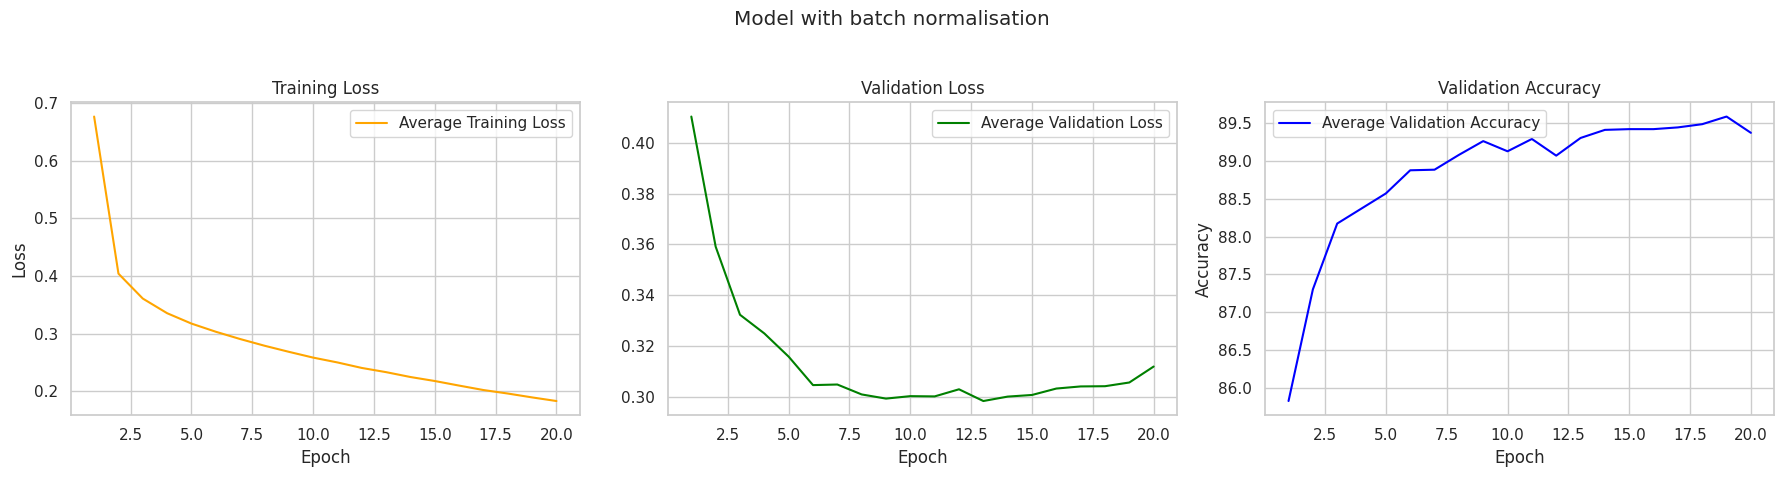

Model with batch normalisation - Final Average Training Loss: 0.183 | Final Average Validation Loss: 0.312 | Final Average Validation Accuracy: 89.38%



In [ ]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001)  # Best optimizer from previous experiment.
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

BN_metrics_list = []


print(f"Running cross-validation with Batch normalisation on current best model")

# Get a model constructor for the current activation function
model_constructor = get_model_constructor(activation_fn)

fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device
)

    # Plot the results
plot_fold_results(fold_results, f"Model with batch normalisation")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

# Append metrics to metrics list
BN_metrics_list.append({
    'Activation Function': activation_name,
    'Average Final Training Loss': avg_final_train_loss,
    'Average Final Validation Loss': avg_final_val_loss,
    'Average Final Validation Accuracy': avg_final_val_accuracy
})

Using Batch normalisation we find a Final average Validation accuracy of 89.382%, comparing this to the 89.794% we found without using batch normalisation, we can conclude that batch normalisation does not improve the model and that we will therefore not use it.

### L1 and L2 regularisation

L1 and L2 regularization are used to prevent overfitting by adding penalty terms to the loss function based on the magnitudes of model weights. L1 regularization encourages sparsity by penalizing the absolute values of weights, while L2 regularization penalizes the squared magnitudes, promoting smoother and more generalized models.

In [ ]:
def model_constructor():
  return FourLayerCNN() # Best performing model so far


### L2 regularisation

L2 regularisation can be implemented by adding weight decay > 0, this is because it is simply an addition of alpha * weight for gradient of every weight, which is exactly what pytorch uses in weight_decay

Running cross-validation with best model using L2 regularisation
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [01:56<00:00,  5.83s/it]


Train time on cuda: 116.617 seconds
Fold 1 completed. Validation accuracy: 89.53

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [01:57<00:00,  5.86s/it]


Train time on cuda: 117.190 seconds
Fold 2 completed. Validation accuracy: 89.01

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [01:56<00:00,  5.85s/it]


Train time on cuda: 116.951 seconds
Fold 3 completed. Validation accuracy: 89.14

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [01:57<00:00,  5.88s/it]


Train time on cuda: 117.583 seconds
Fold 4 completed. Validation accuracy: 88.82

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [01:56<00:00,  5.85s/it]


Train time on cuda: 116.984 seconds
Fold 5 completed. Validation accuracy: 89.33



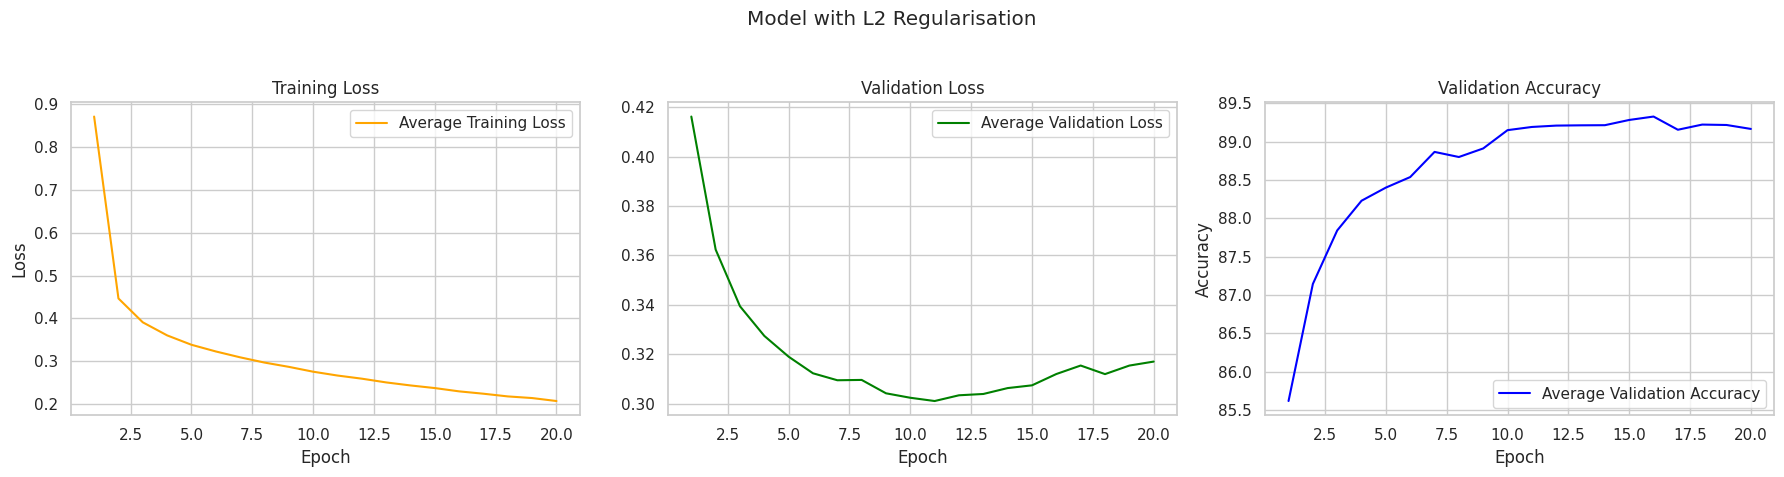

Model with L2 Regularisation - Final Average Training Loss: 0.207 | Final Average Validation Loss: 0.317 | Final Average Validation Accuracy: 89.17%

Average final train loss: 0.20710044755157853
Average final validation loss: 0.3170168106502059
Average final validation accuracy: 89.16578014184397


In [ ]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001,weight_decay=1e-5)  # implementing l2 Regularisation
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

l2_reg_metric_list = []


print(f"Running cross-validation with best model using L2 regularisation")

fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device
)

    # Plot the results
plot_fold_results(fold_results, f"Model with L2 Regularisation")

# Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

print("Average final train loss:", avg_final_train_loss)
print("Average final validation loss:", avg_final_val_loss)
print("Average final validation accuracy:", avg_final_val_accuracy)


We do not see an improvement in performance using L2 regularisation, with an decline of 0.35%, as without L2 normalisation our model's validation accuracy is 89.794%, and with L2 regularisation the accuracy is 89.44%

### L1 regularisation

L1 regularisation can be implemented by computing the L1 norm of the model parameters and adding it to the original loss function with a scaling factor (lambda_l1) to control the regularization strength. This is typically achieved by summing the absolute values of each parameter in the model and then adding this term to the original loss function.

To do this, we must re-define the train and validate function and stratified k-fold function to compute L1 regularisation and handle the cross validation

In [ ]:
def train_and_validate_model_with_l1(train_loader, val_loader, model, optimizer, scheduler, epochs, device, lambda_l1):
    """
    Trains and validates the model using the given data loaders, optimizer, scheduler, and number of epochs, including L1 regularization.

    Parameters:
    - train_loader: DataLoader for the training data.
    - val_loader: DataLoader for the validation data.
    - model: The neural network model to train.
    - optimizer: The optimizer to use for training.
    - scheduler: The scheduler to use for training.
    - epochs: Number of epochs to train for.
    - device: The device (CPU or GPU) to use for training and evaluation.
    - lambda_l1: L1 regularization strength.

    Returns:
    - A tuple containing the average training loss, average validation loss, and average validation accuracy.
    """
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in tqdm(range(epochs), desc="Epochs", leave=True):
        model.train()
        train_loss = 0

        for batch, (X, y) in enumerate(train_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = F.cross_entropy(y_pred, y)

            # Compute the L1 loss (regularization) term
            l1_norm = sum(p.abs().sum() for p in model.parameters())

            # Combine the cross-entropy loss and L1 regularization
            loss += lambda_l1 * l1_norm

            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        scheduler.step()

        model.eval()
        val_loss = 0
        correct = 0
        with no_grad():
            for X, y in val_loader:
                X, y = X.to(device), y.to(device)
                y_pred = model(X)
                loss = F.cross_entropy(y_pred, y)

                val_loss += loss.item()
                correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / len(val_loader.dataset) * 100
        val_accuracies.append(accuracy)

    return train_losses, val_losses, val_accuracies

In [ ]:
def stratified_k_fold_cross_validation_with_l1(dataset, n_splits, model_constructor, setup_optimizer_scheduler, epochs, device, l1):
    """
    Performs stratified k-fold cross-validation for the given dataset, model, and includes L1 regularization.

    Parameters:
    - dataset: The entire dataset (TensorDataset) to be used for cross-validation.
    - n_splits: Number of folds for the k-fold cross-validation.
    - model_constructor: Function that returns a new instance of the desired model.
    - setup_optimizer_scheduler: Function that takes a model's parameters and returns a tuple of optimizer and scheduler.
    - epochs: Number of epochs to train for each fold.
    - device: The device (CPU or GPU) to use for training and evaluation.
    - l1: L1 regularization strength.
    """
    features = dataset.tensors[0].numpy()
    labels = dataset.tensors[1].numpy()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(features, labels), start=1):
        print(f"Starting fold {fold}/{n_splits}")

        # Timer start
        fold_start_time = timer()

        # Splitting the dataset into training and validation subsets for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Creating data loaders
        train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

        # Initializing the model, optimizer, and scheduler for the current fold
        model = model_constructor().to(device)
        optimizer, scheduler = setup_optimizer_scheduler(model)

        # Training and validating the model with L1 regularization
        train_losses, val_losses, val_accuracies = train_and_validate_model_with_l1(
            train_loader, val_loader, model, optimizer, scheduler, epochs, device, l1
        )

        # Timer end
        fold_end_time = timer()

        # Calculating fold training time
        fold_train_time = fold_end_time - fold_start_time

        # Collecting results for this fold
        fold_results.append({
            'train_losses': train_losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
            'train_time': fold_train_time
        })

        print(f"Fold {fold} completed. Validation accuracy: {val_accuracies[-1]:.2f}\n")

    return fold_results

Running cross-validation with best model using L1 regularisation
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [02:18<00:00,  6.92s/it]


Fold 1 completed. Validation accuracy: 76.77

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [02:20<00:00,  7.00s/it]


Fold 2 completed. Validation accuracy: 78.50

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [02:20<00:00,  7.03s/it]


Fold 3 completed. Validation accuracy: 78.90

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [02:21<00:00,  7.05s/it]


Fold 4 completed. Validation accuracy: 80.10

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [02:18<00:00,  6.91s/it]


Fold 5 completed. Validation accuracy: 78.80



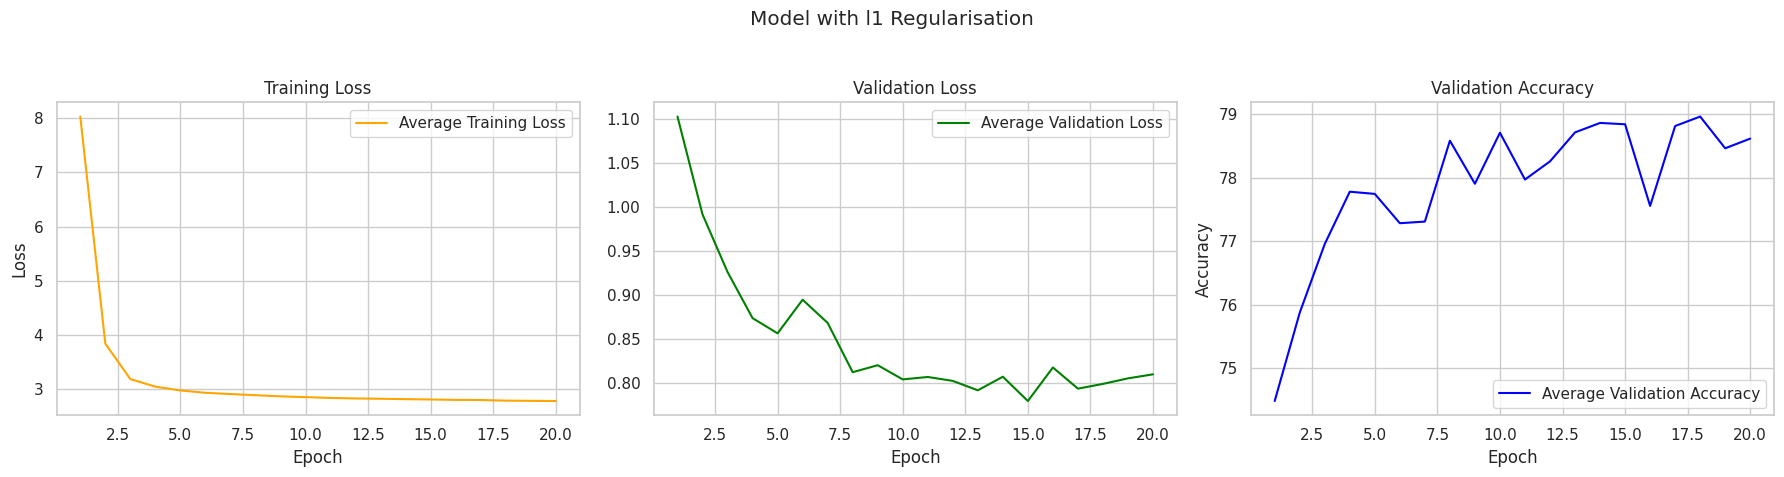

Model with l1 Regularisation - Final Average Training Loss: 2.774 | Final Average Validation Loss: 0.810 | Final Average Validation Accuracy: 78.61%



In [ ]:
def setup_optimizer_scheduler(model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler

print(f"Running cross-validation with best model using L1 regularisation")

model_constructor = get_model_constructor(activation_fn)

# Assuming all other functions (cross-validation, plotting, etc.) are defined correctly
fold_results = stratified_k_fold_cross_validation_with_l1(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device,
    l1 = 0.01
)

    # Plot the results
plot_fold_results(fold_results, f"Model with l1 Regularisation")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

print("Average final train loss:", avg_final_train_loss)
print("Average final validation loss:", avg_final_val_loss)
print("Average final validation accuracy:", avg_final_val_accuracy)


In [ ]:
"""
//// THIS TEXT BLOCK WOULD NOT RENDER PROPERLY IN MARKDOWN, SO MUST BE A COMMENT

we see very poor returns using L1 regularisation,

from : https://discuss.pytorch.org/t/how-is-your-experience-of-using-l1-regularization/153565/2

L2 pushes large parameters strongly towards zero, but pushes small
parameters only weakly, whereas L1 pushes all parameters with the
same strength, regardless of their size. So, according to my intuition,
L2 gives more “breathing room” to small (and moderate) parameters,
while pushing back on abnormally large parameters. On the other hand,
L1 might be preventing small and moderate parameters from reaching
their appropriate values.

This could explain the poor performance with our model values.
"""

as we have found no improvement using L1 or L2 regularisation, Neither will be incorporated into the final model

### Dropout

During training, randomly zeroes some of the elements of the input tensor with probability p.

The zeroed elements are chosen independently for each forward call and are sampled from a Bernoulli distribution.

Each channel will be zeroed out independently on every forward call.

This has proven to be an effective technique for regularization and preventing the co-adaptation of neurons as described in the paper Improving neural networks by preventing co-adaptation of feature detectors

https://arxiv.org/abs/1207.0580

from : https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html

as the baseline has dropout = true, we will test if dropout is false

In [ ]:
def model_constructor():
    return FourLayerCNN(use_dropout=False) #best performing activation function


Running cross-validation with best model using without dropout
Starting fold 1/5


Epochs: 100%|██████████| 20/20 [02:01<00:00,  6.06s/it]


Train time on cuda: 121.175 seconds
Fold 1 completed. Validation accuracy: 87.23

Starting fold 2/5


Epochs: 100%|██████████| 20/20 [02:11<00:00,  6.60s/it]


Train time on cuda: 131.957 seconds
Fold 2 completed. Validation accuracy: 87.03

Starting fold 3/5


Epochs: 100%|██████████| 20/20 [02:21<00:00,  7.06s/it]


Train time on cuda: 141.320 seconds
Fold 3 completed. Validation accuracy: 87.42

Starting fold 4/5


Epochs: 100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


Train time on cuda: 130.209 seconds
Fold 4 completed. Validation accuracy: 87.45

Starting fold 5/5


Epochs: 100%|██████████| 20/20 [02:02<00:00,  6.14s/it]


Train time on cuda: 122.867 seconds
Fold 5 completed. Validation accuracy: 87.15



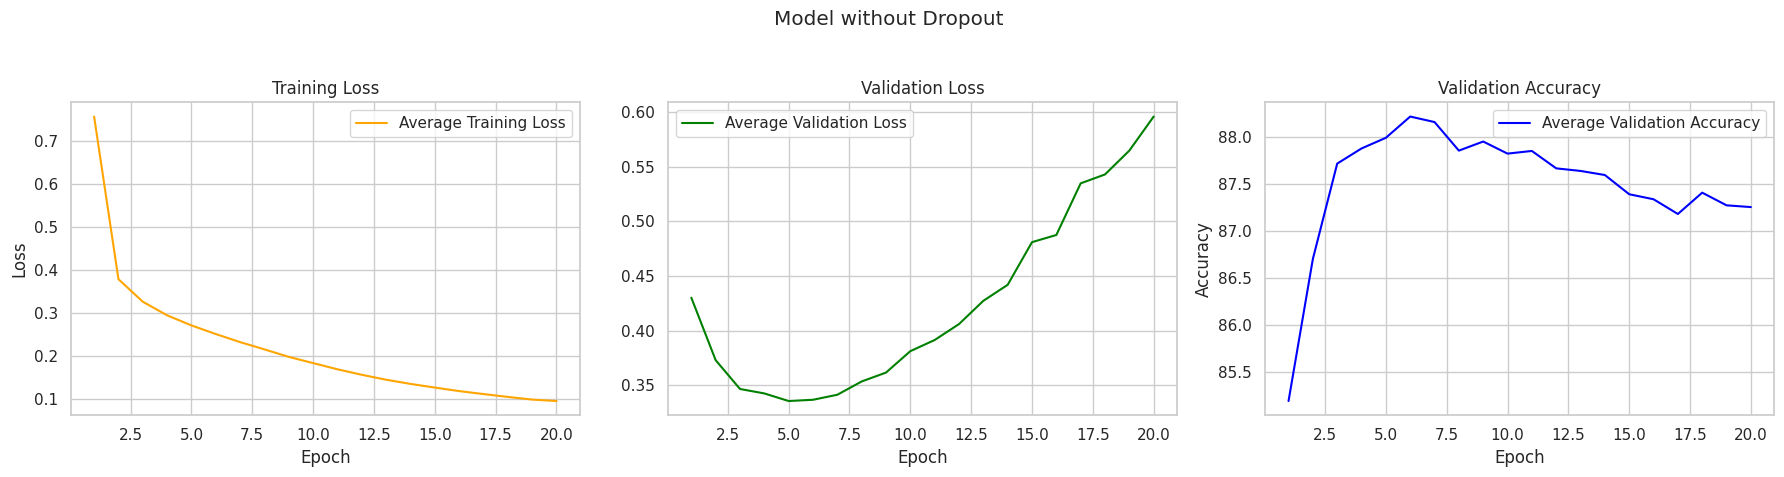

Model without Dropout  - Final Average Training Loss: 0.095 | Final Average Validation Loss: 0.596 | Final Average Validation Accuracy: 87.26%

Average final train loss: 0.09478764664408162
Average final validation loss: 0.5958352362031991
Average final validation accuracy: 87.25531914893617


In [ ]:
def setup_optimizer_scheduler(params):
    optimizer = torch.optim.Adam(params, lr=0.001)  # Best Model Optimizer
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # Best scheduler from previous experiment.
    return optimizer, scheduler


print(f"Running cross-validation with best model using without dropout")

fold_results = stratified_k_fold_cross_validation(
    dataset=train_dataset,
    n_splits=5,
    model_constructor=model_constructor,
    setup_optimizer_scheduler=setup_optimizer_scheduler,
    epochs=20,
    device=device
)

    # Plot the results
plot_fold_results(fold_results, "Model without Dropout ")

    # Calculate summary statistics
avg_final_train_loss = np.mean([fold['train_losses'][-1] for fold in fold_results])
avg_final_val_loss = np.mean([fold['val_losses'][-1] for fold in fold_results])
avg_final_val_accuracy = np.mean([fold['val_accuracies'][-1] for fold in fold_results])

print("Average final train loss:", avg_final_train_loss)
print("Average final validation loss:", avg_final_val_loss)
print("Average final validation accuracy:", avg_final_val_accuracy)

We find that not including dropout returns a validation accuracy of 87.25%, significantly worse than our previous result of 89.794%, therefore dropout will be included in our final model

Now that we have tested all of the hyper parameters, we can test the model on the test dataset and assess its performance metrics

### Best performing model on test Dataset

In [ ]:
best_cnn_model = FourLayerCNN().to(device) #Best model from our results, uses Relu and Dropout
optimizer = torch.optim.RMSprop(best_cnn_model.parameters(), lr=0.001)  # Best optimizer from previous experiment.
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)  # Best scheduler from previous experiment.

In [ ]:
# Set the number of epochs
num_epochs = 20

# Record our model loss through training.
cnn_train_losses = []
cnn_test_losses = []
cnn_test_accuracy = []

# Training loop
for epoch in range(num_epochs):
    # Set model to train mode
    best_cnn_model.train()

    # Initialize variables to track loss and accuracy
    total_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    # Training loop
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = best_cnn_model(X)
        loss = F.cross_entropy(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Calculate average training loss across the data
    avg_train_loss = total_loss / len(train_loader)

    # Append to our recording
    train_losses.append(avg_train_loss)

    # Set model to evaluation mode
    best_cnn_model.eval()

    # Initialize variables to track loss and accuracy for testing
    test_loss = 0.0
    correct = 0
    total = 0

    # Initialize variables to track evaluation metrics
    cnn_evaluation_metrics = {}

    # Initialize lists to store true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Test loop
    with torch.no_grad():
        for batch, (X_test, y_test) in enumerate(test_loader):
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = best_cnn_model(X_test)
            loss = F.cross_entropy(outputs, y_test)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_test.size(0)
            correct += (predicted == y_test).sum().item()

            # Append true labels and predicted labels
            true_labels.extend(y_test.cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    # Calculate average testing loss across the data
    avg_test_loss = test_loss / len(test_loader)
    test_losses.append(avg_test_loss)

    print(f"Epoch: {epoch+1} | Train Loss: {avg_train_loss} | Test Loss: {avg_test_loss} | Test Accuracy: {(correct / total) * 100:.2f}%")

Epoch: 1 | Train Loss: 1.4093997257327602 | Test Loss: 0.6444389030740068 | Test Accuracy: 79.36%
Epoch: 2 | Train Loss: 0.5867932552126198 | Test Loss: 0.48748520097217046 | Test Accuracy: 83.30%
Epoch: 3 | Train Loss: 0.48700643947760985 | Test Loss: 0.48998495453112834 | Test Accuracy: 83.58%
Epoch: 4 | Train Loss: 0.436092911802266 | Test Loss: 0.41056512336473205 | Test Accuracy: 85.72%
Epoch: 5 | Train Loss: 0.40098369269888867 | Test Loss: 0.3913647016963443 | Test Accuracy: 85.69%
Epoch: 6 | Train Loss: 0.3788517427660221 | Test Loss: 0.36954612506402507 | Test Accuracy: 87.24%
Epoch: 7 | Train Loss: 0.35732457850853244 | Test Loss: 0.35093761054245204 | Test Accuracy: 87.68%
Epoch: 8 | Train Loss: 0.3445751526776482 | Test Loss: 0.33621746865478724 | Test Accuracy: 88.15%
Epoch: 9 | Train Loss: 0.33052372015439546 | Test Loss: 0.3311485930069073 | Test Accuracy: 88.22%
Epoch: 10 | Train Loss: 0.3190749327386666 | Test Loss: 0.3439592988909902 | Test Accuracy: 87.84%
Epoch: 11 

### Evaluating our Best CNN

Now that we've trained our best model, we can evaluate the performance on the test data:

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Evaluate model on test set
best_cnn_model.eval()  # Set model to evaluation mode
true_labels = []
best_cnn_preds = []

with torch.no_grad():
    for X_test, y_test in test_loader:
        X_test, y_test = X_test.to(device), y_test.to(device)
        outputs = best_cnn_model(X_test)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(y_test.cpu().numpy())
        best_cnn_preds.extend(predicted.cpu().numpy())

# Convert lists to numpy arrays for compatibility with scikit-learn metrics
true_labels = np.array(true_labels)
best_cnn_preds = np.array(best_cnn_preds)

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, best_cnn_preds)
precision = precision_score(true_labels, best_cnn_preds, average='macro')
recall = recall_score(true_labels, best_cnn_preds, average='macro')
f1 = f1_score(true_labels, best_cnn_preds, average='macro')

final_model_metrics.append({'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1})

# Print all evaluation results
print("Best CNN Results:")
print('Accuracy: %.4f' % accuracy)
print('Precision: %.4f' % precision)
print('Recall: %.4f' % recall)
print('F1 Score: %.4f' % f1)


Best CNN Results:
Accuracy: 0.8887
Precision: 0.8908
Recall: 0.8887
F1 Score: 0.8872


Next, we'll show the top 6 items from the test loader

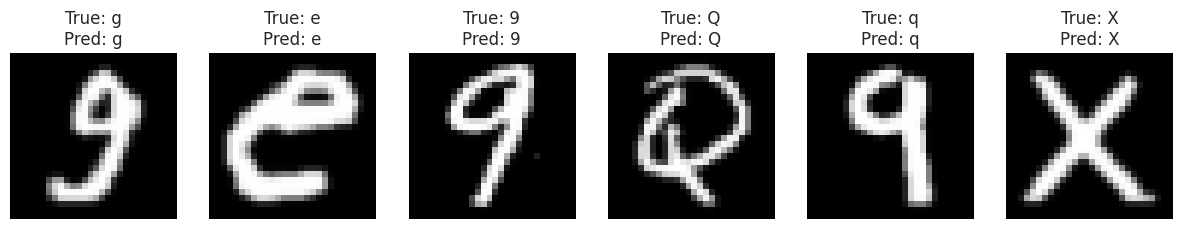

In [ ]:
plot_top_samples(test_loader, label_char_mapping, best_cnn_preds)

We can also create a confusion matrix to clearly show where the model is making mistakes:

In [ ]:
mapping_file_path = 'emnist-balanced-mapping.txt'
label_char_mapping = load_label_mapping(mapping_file_path)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(labels, preds, label_char_mapping=label_char_mapping, num_classes=47):
    """
    Plot confusion matrix using matplotlib and seaborn with custom labels from EMNIST.
    """
    cm = confusion_matrix(labels, preds, labels=range(num_classes))
    plt.figure(figsize=(20, 15))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[label_char_mapping[i] for i in range(num_classes)],
                yticklabels=[label_char_mapping[i] for i in range(num_classes)])
    plt.xlabel('Predicted Labels', fontsize=12)
    plt.ylabel('True Labels', fontsize=12)
    plt.title('Confusion Matrix', fontsize=14)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

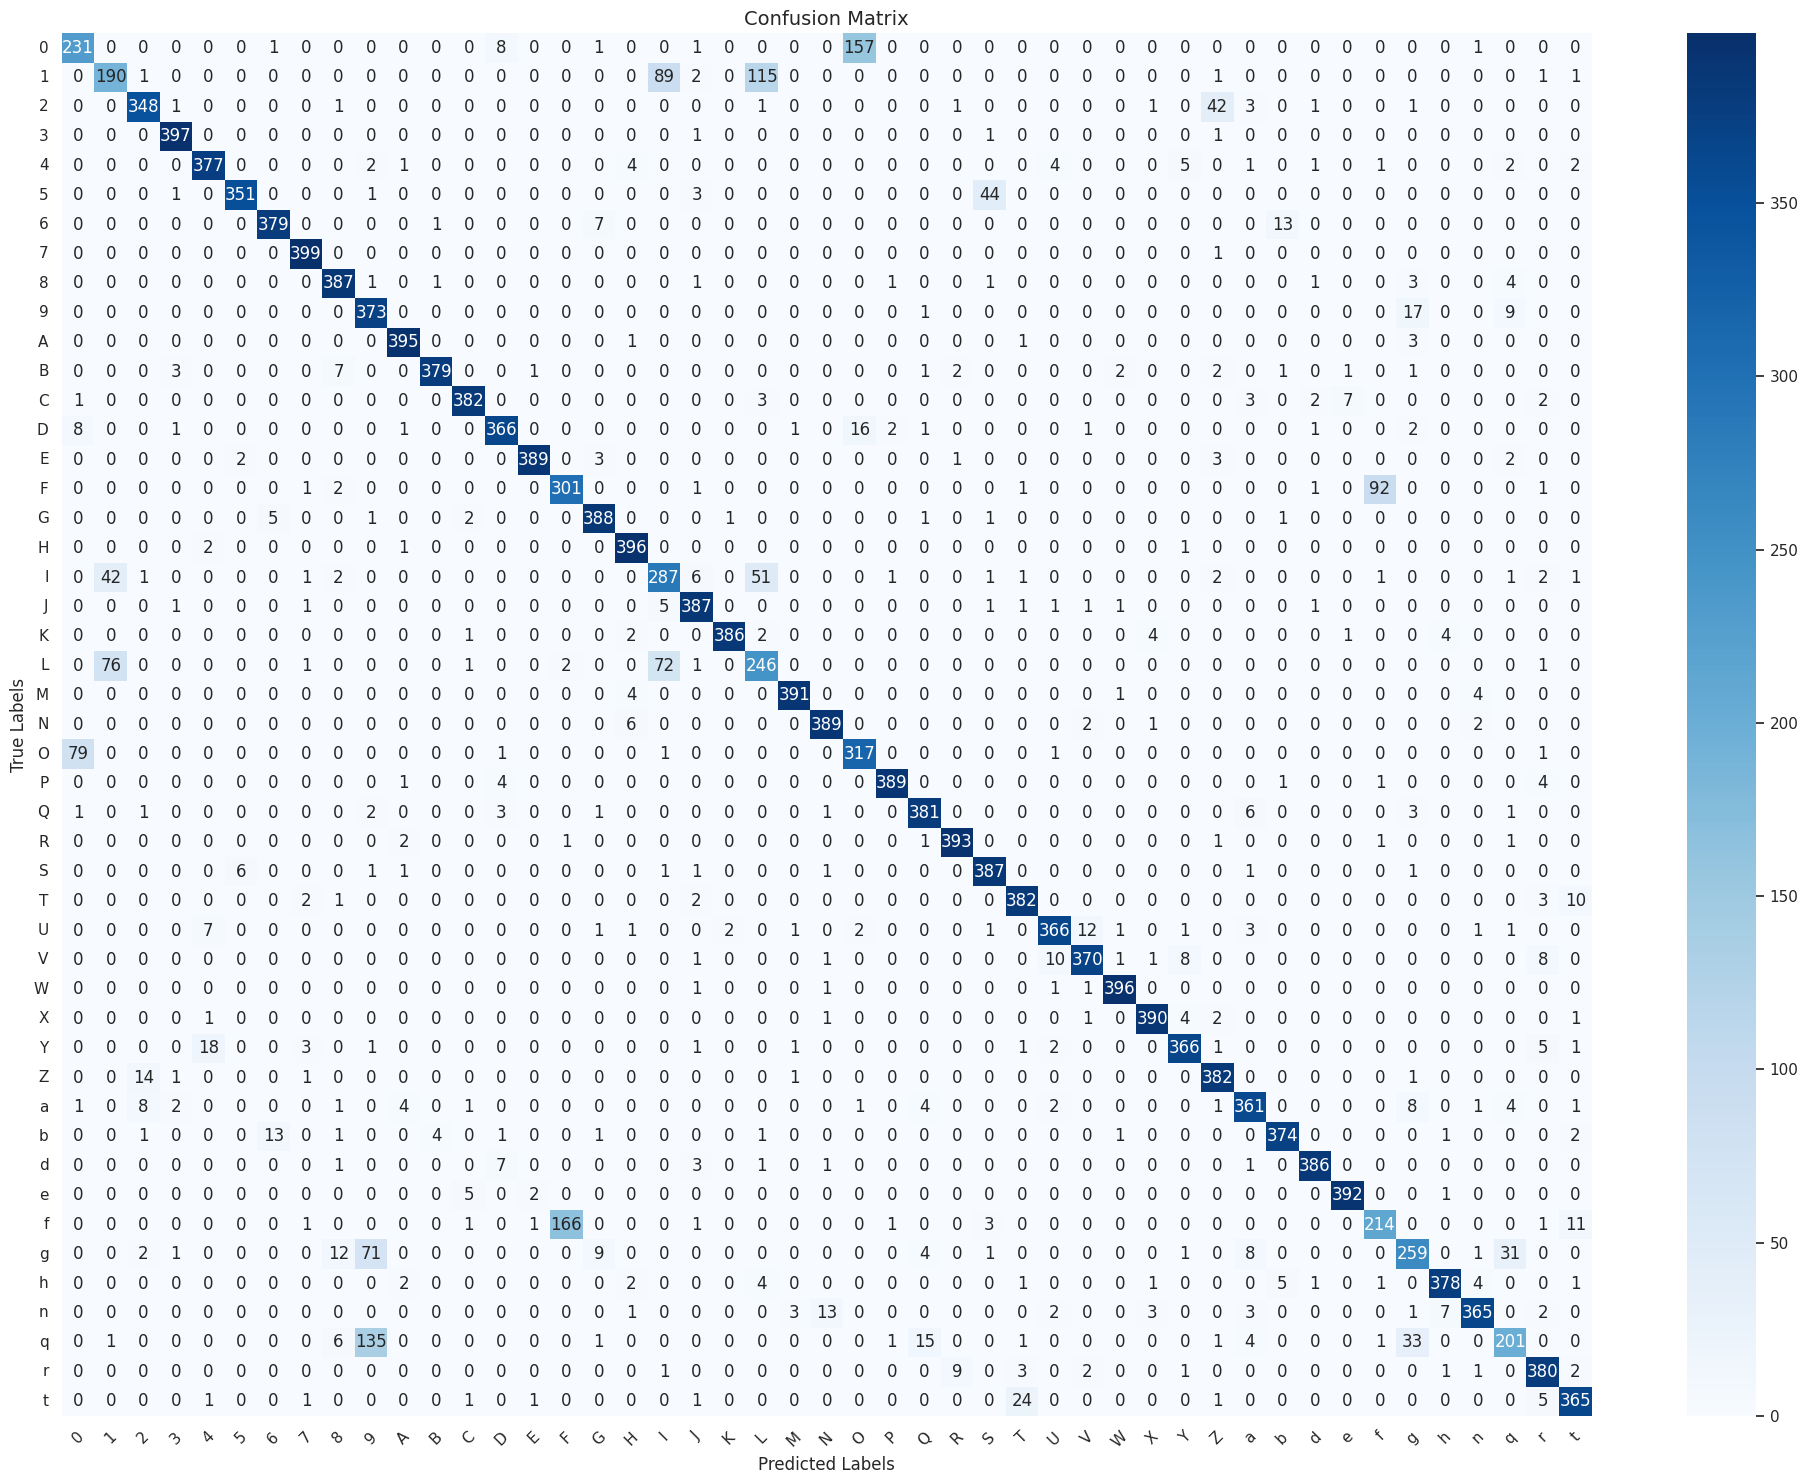

In [ ]:
plot_confusion_matrix(true_labels, best_cnn_preds)

**we find Validation accuracy: 85.03, Precision: 0.86, Recall: 0.85, F1-Score: 0.85 for the CNN model**

**comparing this to MLP model , that returns a validation accuracy of 77.95 on the test dataset , with Precision: 0.79, Recall: 0.78, F1-Score: 0.78, we can conclude that the CNN model performs better on the emnist dataset

## Comparing our Two Models

In [ ]:
# Convert model_metrics list to DataFrame
final_model_metrics_df = pd.DataFrame(final_model_metrics, index=['MLP', 'CNN'])

# Show DataFrame as a table
print(final_model_metrics_df)

     accuracy  precision    recall  f1_score
MLP  0.850479   0.852977  0.850479  0.850562
CNN  0.888723   0.890789  0.888723  0.887210
